## Homework6: Bayesian Normal Error Regression

The data are 93 bank employees salary data. The response is beginning salary, and the predictors are sex, years of education, months of experience, and number of months from jan 1, 1969 to hire. 

We will fit a multiple linear regression model using all four variables. We will ise the Gamma(.01,.01) for the precision $\tau$. Let's consider three different models with different priors on $\beta$:

1. Independent normal priors: $\beta \sim N(0,100^2)$
2. Use the default Zellner's g-prior for $\beta$ with $c^2=n$
3. Use a conservative Zeller's g-prior for $\beta$ with $c^2=1000$

### Brief Summary of Data:

In [1]:
df = read.csv("BankSalaryData.csv")

In [2]:
summary(df)

     BegSal          Sex              Educ           Exper      
 Min.   :3.90   Min.   :0.0000   Min.   : 8.00   Min.   :  0.0  
 1st Qu.:4.98   1st Qu.:0.0000   1st Qu.:12.00   1st Qu.: 35.5  
 Median :5.40   Median :0.0000   Median :12.00   Median : 70.0  
 Mean   :5.42   Mean   :0.3441   Mean   :12.51   Mean   :100.9  
 3rd Qu.:6.00   3rd Qu.:1.0000   3rd Qu.:15.00   3rd Qu.:144.0  
 Max.   :8.10   Max.   :1.0000   Max.   :16.00   Max.   :381.0  
      Time      
 Min.   : 1.00  
 1st Qu.: 9.00  
 Median :15.00  
 Mean   :16.72  
 3rd Qu.:25.00  
 Max.   :34.00  

### Typical Regression Model:


In [3]:
lmod = lm(BegSal~., data=df)
summary(lmod)


Call:
lm(formula = BegSal ~ ., data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.23890 -0.35305 -0.01661  0.28002  1.56880 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 3.5263818  0.3277225  10.760  < 2e-16 ***
Sex         0.7223029  0.1178246   6.130 2.42e-08 ***
Educ        0.0900191  0.0246932   3.646 0.000451 ***
Exper       0.0012679  0.0005871   2.160 0.033526 *  
Time        0.0234276  0.0052001   4.505 2.03e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5074 on 88 degrees of freedom
Multiple R-squared:  0.5109,	Adjusted R-squared:  0.4887 
F-statistic: 22.98 on 4 and 88 DF,  p-value: 5.068e-13


In [4]:
# Confidence intervals for Coefficients. 
confint(lmod, 'Sex', level=0.95)
confint(lmod, 'Educ', level=0.95)
confint(lmod, 'Exper', level=0.95)
confint(lmod, 'Time', level=0.95)


,2.5 %,97.5 %
Sex,0.4881513,0.9564545


,2.5 %,97.5 %
Educ,0.04094657,0.1390916


,2.5 %,97.5 %
Exper,0.0001011426,0.002434652


,2.5 %,97.5 %
Time,0.01309355,0.03376161


## Model 1: independent normal priors on $\beta$

In [5]:
library(rstan)
library(coda)

Loading required package: ggplot2
Loading required package: StanHeaders
rstan (Version 2.14.2, packaged: 2017-03-19 00:42:29 UTC, GitRev: 5fa1e80eb817)
For execution on a local, multicore CPU with excess RAM we recommend calling
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())

Attaching package: ‘coda’

The following object is masked from ‘package:rstan’:

    traceplot



In [6]:
stan2coda3 <- function(fit3) {
     mcmc.list(lapply(1:4, function(x) mcmc(as.array(fit3)[,x,])))
}

In [7]:
n = length(df$BegSal)
v = var(df$BegSal)

In [8]:
# create the Stan model:
stanmod="
data{
    int<lower=1> n; // number of obs
    vector[n] y; // data
    vector[n] sex; //covariate
    vector[n] edu; //covariate
    vector[n] expr; //covariate
    vector[n] time; //covariate
    real<lower=0> v; // sample variance of y
}
parameters {
    real<lower=0> prec;
    real beta0;
    real beta1;
    real beta2;
    real beta3;
    real beta4;
}
transformed parameters{
    real<lower=0> sigma;
    sigma = sqrt(1/prec);   
}
model {
  //specify priors
    beta0 ~ normal(0.0, 10000);
    beta1 ~ normal(0.0, 10000); 
    beta2 ~ normal(0.0, 10000);
    beta3 ~ normal(0.0, 10000);
    beta4 ~ normal(0.0, 10000);
    prec ~ gamma(0.01, 0.01); 

    for(i in 1:n){
        y[i]~normal(beta0 + beta1*sex[i] + beta2*edu[i] + beta3*expr[i] + beta4*time[i],sigma);
    }
}
generated quantities {
    real<lower=0> sigmasq;
    real Rbsq;
    sigmasq = 1/prec;
    Rbsq = 1-sigmasq / v;
}
"

In [9]:
stan_dat = list(n=n, y=df$BegSal, sex = df$Sex, edu = df$Educ,
                expr = df$Exper, time = df$Time, v=v)

In [10]:
# fit the model using stan with 4-chains:
fit1 = stan(model_code=stanmod, data=stan_dat, iter=100000, chains = 4)

In file included from /home/len/R/x86_64-pc-linux-gnu-library/3.3/RcppEigen/include/Eigen/Core:276:0,
                 from /home/len/R/x86_64-pc-linux-gnu-library/3.3/RcppEigen/include/Eigen/Dense:1,
                 from /home/len/R/x86_64-pc-linux-gnu-library/3.3/StanHeaders/include/stan/math/prim/mat/fun/Eigen.hpp:4,
                 from /home/len/R/x86_64-pc-linux-gnu-library/3.3/StanHeaders/include/stan/math/rev/mat/fun/Eigen_NumTraits.hpp:4,
                 from /home/len/R/x86_64-pc-linux-gnu-library/3.3/StanHeaders/include/stan/math/rev/core/matrix_vari.hpp:4,
                 from /home/len/R/x86_64-pc-linux-gnu-library/3.3/StanHeaders/include/stan/math/rev/core.hpp:14,
                 from /home/len/R/x86_64-pc-linux-gnu-library/3.3/StanHeaders/include/stan/math/rev/mat.hpp:4,
                 from /home/len/R/x86_64-pc-linux-gnu-library/3.3/StanHeaders/include/stan/math.hpp:4,
                 from /home/len/R/x86_64-pc-linux-gnu-library/3.3/StanHeaders/include/src/stan/

In [11]:
# summary of fitted values
summary(fit1)$summary[1:7,]

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
prec,3.880766696,1.422849e-03,0.5835980351,2.825263e+00,3.4723205153,3.851672594,4.256319754,5.10495674,168232.6,1.0000136
beta0,3.527720632,1.035184e-03,0.3322286371,2.874758e+00,3.3056985105,3.527985270,3.749320855,4.18170499,103000.3,1.0000573
beta1,0.722646604,2.922824e-04,0.1189936820,4.889585e-01,0.6428495386,0.722687071,0.802424763,0.95583075,165745.8,0.9999896
beta2,0.089922602,7.785268e-05,0.0250819793,4.047396e-02,0.0731933918,0.089880702,0.106689229,0.13907866,103795.0,1.0000602
beta3,0.001266517,1.328766e-06,0.0005942423,9.689974e-05,0.0008675564,0.001266848,0.001665159,0.00243670,200000.0,1.0000056
beta4,0.023413765,1.261724e-05,0.0052396439,1.315346e-02,0.0199065339,0.023407978,0.026934379,0.03369169,172454.7,0.9999932
sigma,0.511975139,9.521355e-05,0.0389604374,4.425924e-01,0.4847110011,0.509536522,0.536648719,0.59493641,167436.5,1.0000107


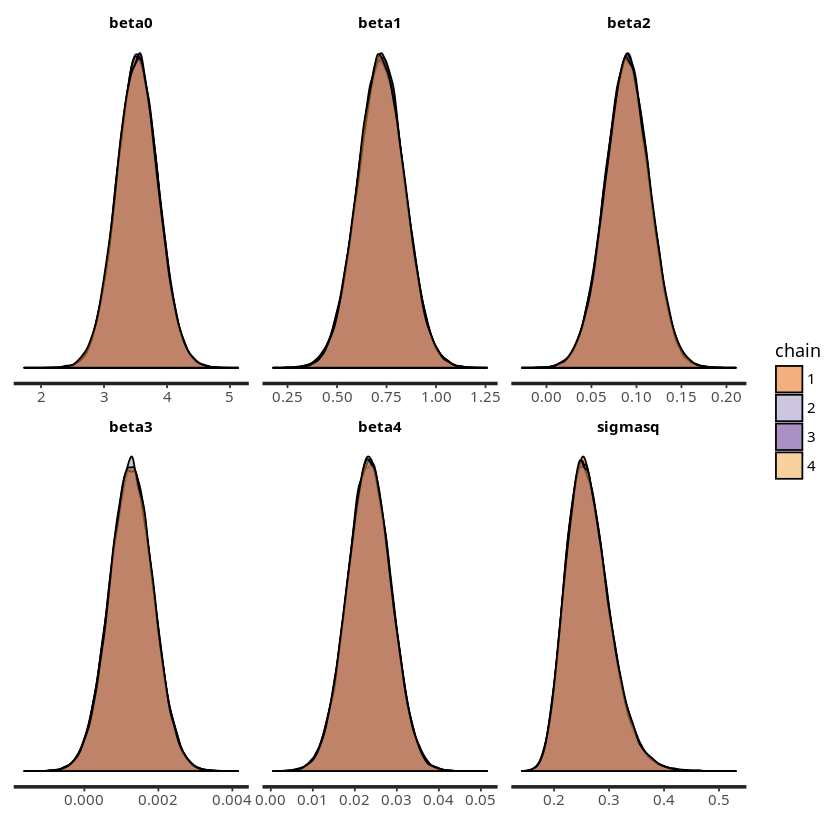

In [12]:
# plot of densities
stan_dens(fit1, par = c("beta0", "beta1", "beta2","beta3","beta4", "sigmasq"),
          separate_chains = TRUE)

In [13]:
# check convergence with gelman-rubin statistics
summary(fit1)$summary[,"Rhat"]

prec     beta0     beta1     beta2     beta3     beta4     sigma   sigmasq 
1.0000136 1.0000573 0.9999896 1.0000602 1.0000056 0.9999932 1.0000107 1.0000096 
     Rbsq      lp__ 
1.0000096 1.0000182

In [14]:
# 95% central posterior intervals
summary(fit1)$summary[,c("2.5%", "97.5%")]

,2.5%,97.5%
prec,2.825263e+00,5.10495674
beta0,2.874758e+00,4.18170499
beta1,4.889585e-01,0.95583075
beta2,4.047396e-02,0.13907866
beta3,9.689974e-05,0.00243670
beta4,1.315346e-02,0.03369169
sigma,4.425924e-01,0.59493641
sigmasq,1.958880e-01,0.35394934
Rbsq,2.970418e-01,0.61095811
lp__,1.167109e+01,18.49352728


In [15]:
# posterior means
summary(fit1)$summary[,"mean"]

prec        beta0        beta1        beta2        beta3        beta4 
 3.880766696  3.527720632  0.722646604  0.089922602  0.001266517  0.023413765 
       sigma      sigmasq         Rbsq         lp__ 
 0.511975139  0.263636451  0.476406937 16.039158293

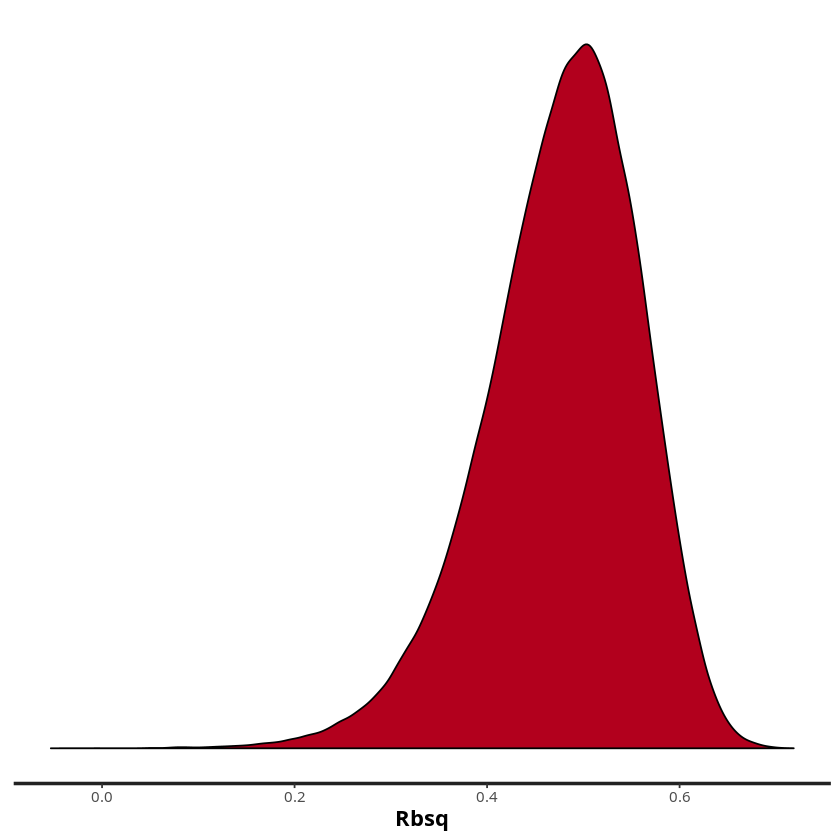

In [16]:
# distribution of Rb^2
stan_dens(fit1, "Rbsq")

In [17]:
#traceplot(fit1,par = c("beta0","beta1","beta2","beta3","beta4", "sigmasq","prec"))

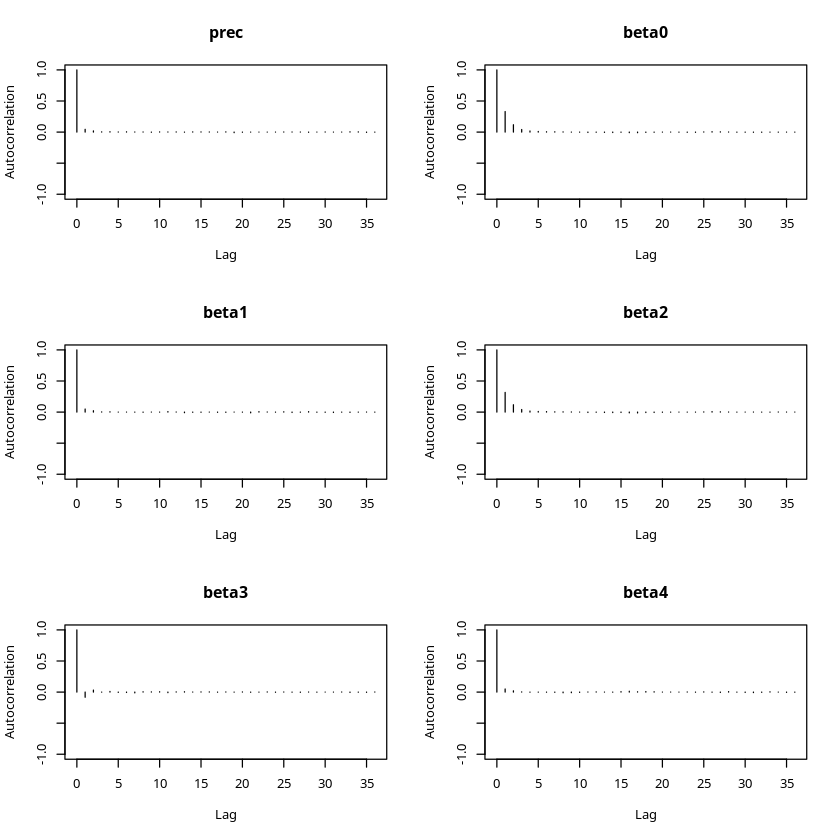

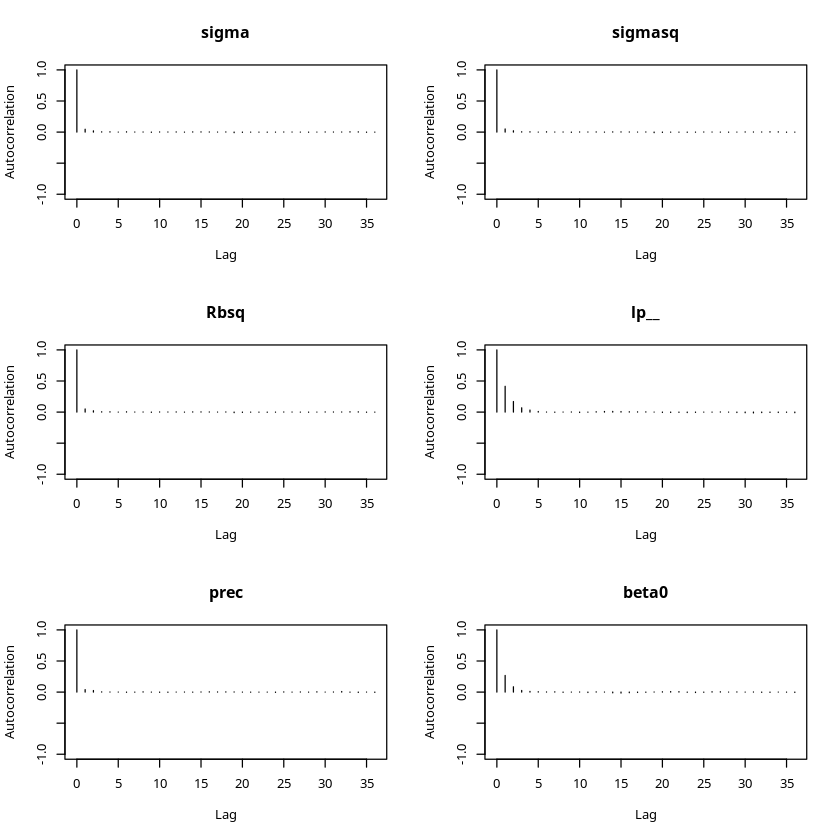

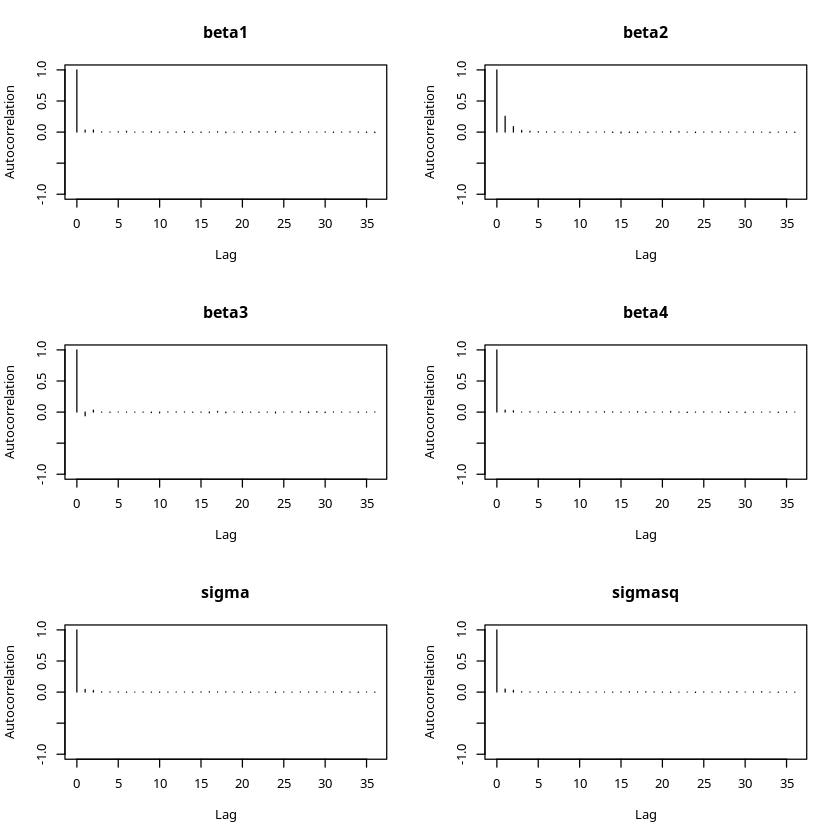

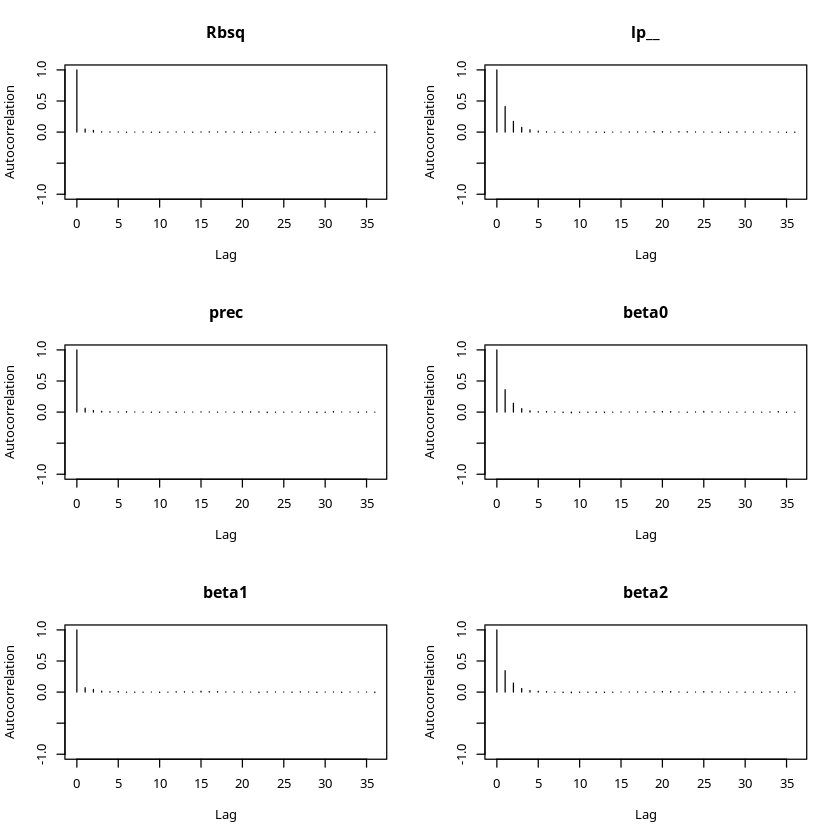

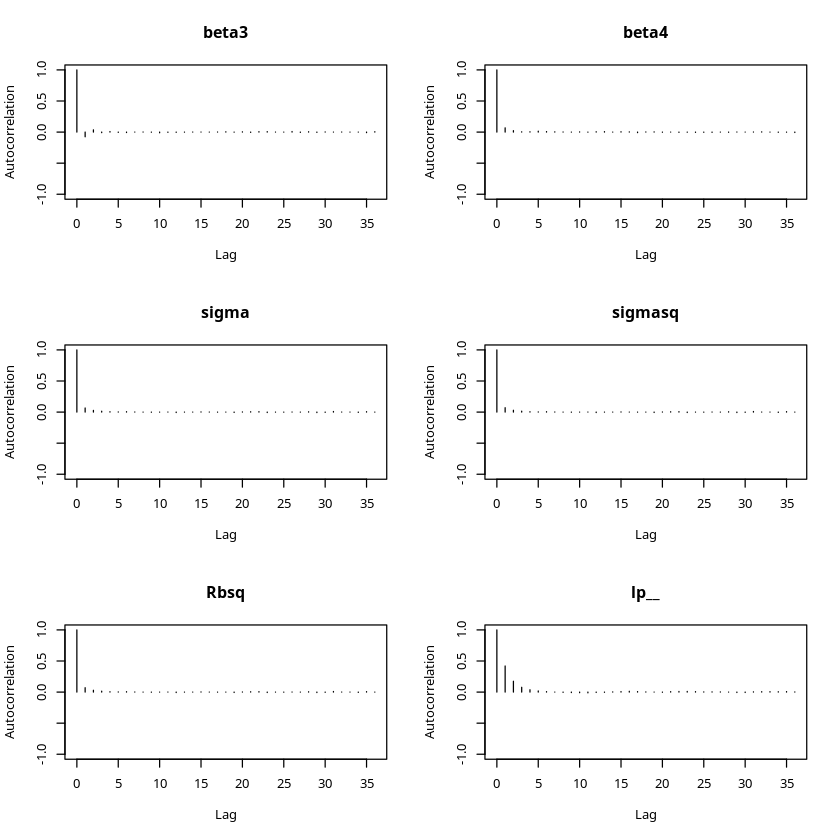

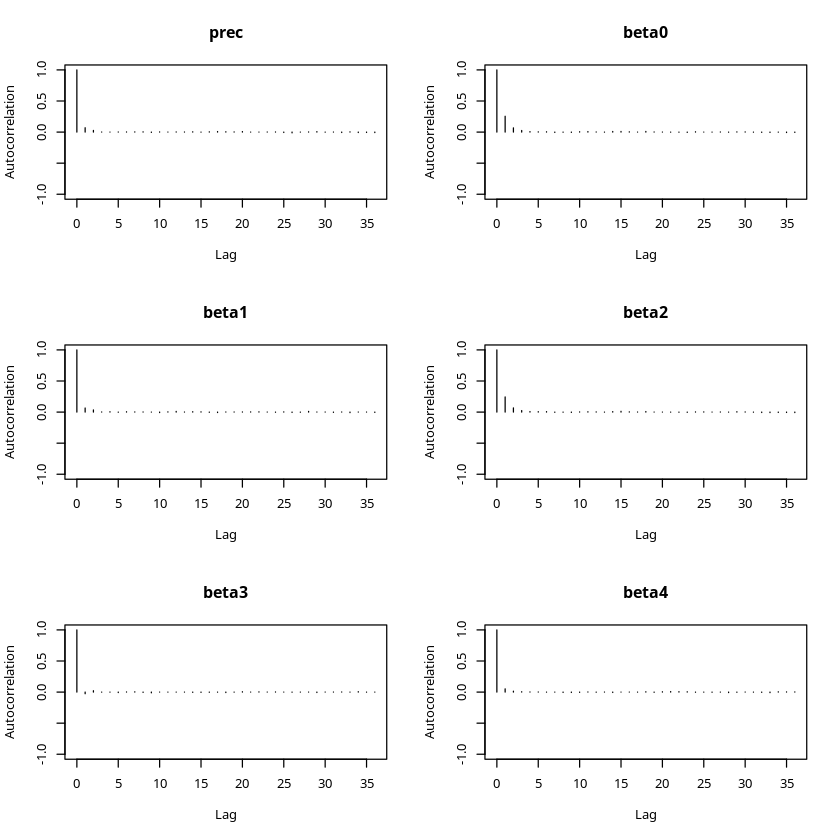

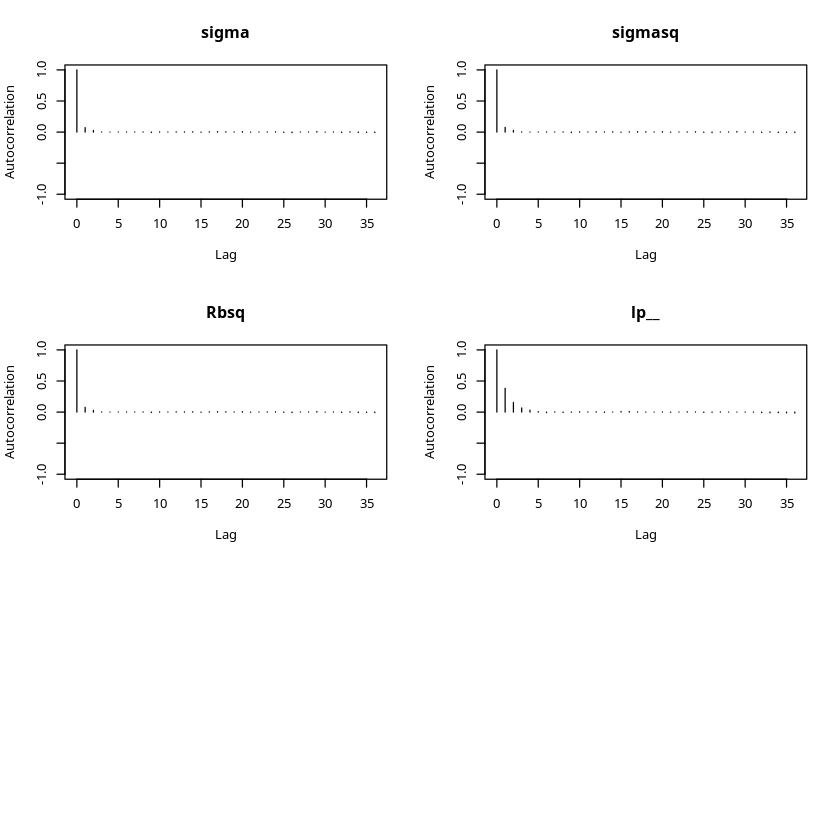

In [18]:
autocorr.plot(stan2coda3(fit1))

## Model 2: use the default Zellner's g-prior for $\beta$ where $c^2=n$

In [19]:
# create the Stan model:
stanmod="
data {
    int<lower=1> n; // number of observations 
    vector[n] y; // data
    matrix[n, 5] X; //covariates
    vector[5] mu0; //prior mean for beta
    cov_matrix[5] V; //V part of Zellner's g-prior
    cov_matrix[n] I; //nxn identity matrix
    real<lower=0> csq; //constant for Zellner's g-prior
    real<lower=0> v; //sample variance
}
parameters {
    real<lower=0> prec;
    vector[5] beta;


}
transformed parameters{
    real<lower=0> sigmasq;
    vector[n] mu;
    sigmasq = 1/prec;
    mu = X*beta;

}
model {
    //specify priors
    beta ~ multi_normal(mu0, sigmasq*csq*V);
    prec ~ gamma(0.01, 0.01); 
    // we have independet data  
    //y~multi_normal(X*beta,sigmasq*I);
    for(i in 1:n) y[i] ~ normal(mu[i],sqrt(sigmasq));
}
generated quantities {
    real Rbsq;
    Rbsq = 1-sigmasq/v;
}"

In [20]:

X = cbind(1,df$Sex, df$Educ, df$Exper, df$Time)

In [21]:
# make list stan data
stan_dat <- list(n = n, y = df$BegSal,
                X = X, mu0 = c(0, 0, 0, 0, 0), V = solve(crossprod(X)), 
                I = diag(n), csq = n, v = v)

In [22]:
# fit model using stan with 4 chains
fit2 <- stan(model_code = stanmod, data = stan_dat, 
            iter = 100000, chains = 4)


In file included from /home/len/R/x86_64-pc-linux-gnu-library/3.3/RcppEigen/include/Eigen/Core:276:0,
                 from /home/len/R/x86_64-pc-linux-gnu-library/3.3/RcppEigen/include/Eigen/Dense:1,
                 from /home/len/R/x86_64-pc-linux-gnu-library/3.3/StanHeaders/include/stan/math/prim/mat/fun/Eigen.hpp:4,
                 from /home/len/R/x86_64-pc-linux-gnu-library/3.3/StanHeaders/include/stan/math/rev/mat/fun/Eigen_NumTraits.hpp:4,
                 from /home/len/R/x86_64-pc-linux-gnu-library/3.3/StanHeaders/include/stan/math/rev/core/matrix_vari.hpp:4,
                 from /home/len/R/x86_64-pc-linux-gnu-library/3.3/StanHeaders/include/stan/math/rev/core.hpp:14,
                 from /home/len/R/x86_64-pc-linux-gnu-library/3.3/StanHeaders/include/stan/math/rev/mat.hpp:4,
                 from /home/len/R/x86_64-pc-linux-gnu-library/3.3/StanHeaders/include/stan/math.hpp:4,
                 from /home/len/R/x86_64-pc-linux-gnu-library/3.3/StanHeaders/include/src/stan/

The following numerical problems occurred the indicated number of times on chain 1
                                                                                                     count
Exception thrown at line 27: multi_normal_log: Covariance matrix is not symmetric. Covariance matrix    18
When a numerical problem occurs, the Hamiltonian proposal gets rejected.
See http://mc-stan.org/misc/warnings.html#exception-hamiltonian-proposal-rejected
If the number in the 'count' column is small, there is no need to ask about this message on stan-users.



SAMPLING FOR MODEL '5a2f02ff087d39001b6d13ac91e61ad3' NOW (CHAIN 2).

Chain 2, Iteration:     1 / 100000 [  0%]  (Warmup)
Chain 2, Iteration: 10000 / 100000 [ 10%]  (Warmup)
Chain 2, Iteration: 20000 / 100000 [ 20%]  (Warmup)
Chain 2, Iteration: 30000 / 100000 [ 30%]  (Warmup)
Chain 2, Iteration: 40000 / 100000 [ 40%]  (Warmup)
Chain 2, Iteration: 50000 / 100000 [ 50%]  (Warmup)
Chain 2, Iteration: 50001 / 100000 [ 50%]  (Sampling)
Chain 2, Iteration: 60000 / 100000 [ 60%]  (Sampling)
Chain 2, Iteration: 70000 / 100000 [ 70%]  (Sampling)
Chain 2, Iteration: 80000 / 100000 [ 80%]  (Sampling)
Chain 2, Iteration: 90000 / 100000 [ 90%]  (Sampling)
Chain 2, Iteration: 100000 / 100000 [100%]  (Sampling)
 Elapsed Time: 20.5756 seconds (Warm-up)
               26.6346 seconds (Sampling)
               47.2102 seconds (Total)



The following numerical problems occurred the indicated number of times on chain 2
                                                                                                     count
Exception thrown at line 27: multi_normal_log: Covariance matrix is not symmetric. Covariance matrix    19
When a numerical problem occurs, the Hamiltonian proposal gets rejected.
See http://mc-stan.org/misc/warnings.html#exception-hamiltonian-proposal-rejected
If the number in the 'count' column is small, there is no need to ask about this message on stan-users.



SAMPLING FOR MODEL '5a2f02ff087d39001b6d13ac91e61ad3' NOW (CHAIN 3).

Chain 3, Iteration:     1 / 100000 [  0%]  (Warmup)
Chain 3, Iteration: 10000 / 100000 [ 10%]  (Warmup)
Chain 3, Iteration: 20000 / 100000 [ 20%]  (Warmup)
Chain 3, Iteration: 30000 / 100000 [ 30%]  (Warmup)
Chain 3, Iteration: 40000 / 100000 [ 40%]  (Warmup)
Chain 3, Iteration: 50000 / 100000 [ 50%]  (Warmup)
Chain 3, Iteration: 50001 / 100000 [ 50%]  (Sampling)
Chain 3, Iteration: 60000 / 100000 [ 60%]  (Sampling)
Chain 3, Iteration: 70000 / 100000 [ 70%]  (Sampling)
Chain 3, Iteration: 80000 / 100000 [ 80%]  (Sampling)
Chain 3, Iteration: 90000 / 100000 [ 90%]  (Sampling)
Chain 3, Iteration: 100000 / 100000 [100%]  (Sampling)
 Elapsed Time: 20.7112 seconds (Warm-up)
               24.0902 seconds (Sampling)
               44.8014 seconds (Total)



The following numerical problems occurred the indicated number of times on chain 3
                                                                                                     count
Exception thrown at line 27: multi_normal_log: Covariance matrix is not symmetric. Covariance matrix    14
When a numerical problem occurs, the Hamiltonian proposal gets rejected.
See http://mc-stan.org/misc/warnings.html#exception-hamiltonian-proposal-rejected
If the number in the 'count' column is small, there is no need to ask about this message on stan-users.



SAMPLING FOR MODEL '5a2f02ff087d39001b6d13ac91e61ad3' NOW (CHAIN 4).

Chain 4, Iteration:     1 / 100000 [  0%]  (Warmup)
Chain 4, Iteration: 10000 / 100000 [ 10%]  (Warmup)
Chain 4, Iteration: 20000 / 100000 [ 20%]  (Warmup)
Chain 4, Iteration: 30000 / 100000 [ 30%]  (Warmup)
Chain 4, Iteration: 40000 / 100000 [ 40%]  (Warmup)
Chain 4, Iteration: 50000 / 100000 [ 50%]  (Warmup)
Chain 4, Iteration: 50001 / 100000 [ 50%]  (Sampling)
Chain 4, Iteration: 60000 / 100000 [ 60%]  (Sampling)
Chain 4, Iteration: 70000 / 100000 [ 70%]  (Sampling)
Chain 4, Iteration: 80000 / 100000 [ 80%]  (Sampling)
Chain 4, Iteration: 90000 / 100000 [ 90%]  (Sampling)
Chain 4, Iteration: 100000 / 100000 [100%]  (Sampling)
 Elapsed Time: 20.1597 seconds (Warm-up)
               26.9774 seconds (Sampling)
               47.1371 seconds (Total)



The following numerical problems occurred the indicated number of times on chain 4
                                                                                                     count
Exception thrown at line 27: multi_normal_log: Covariance matrix is not symmetric. Covariance matrix    15
When a numerical problem occurs, the Hamiltonian proposal gets rejected.
See http://mc-stan.org/misc/warnings.html#exception-hamiltonian-proposal-rejected
If the number in the 'count' column is small, there is no need to ask about this message on stan-users.


This is taking too long as gives this error along the way. Not sure if it makes sense to use 100000 as the number of iterations. 

In [23]:
summary(fit2)$summary[1:7,c("mean")]

prec     beta[1]     beta[2]     beta[3]     beta[4]     beta[5] 
1.789227325 3.491805776 0.715001102 0.088882081 0.001251417 0.023142187 
    sigmasq 
0.571114797

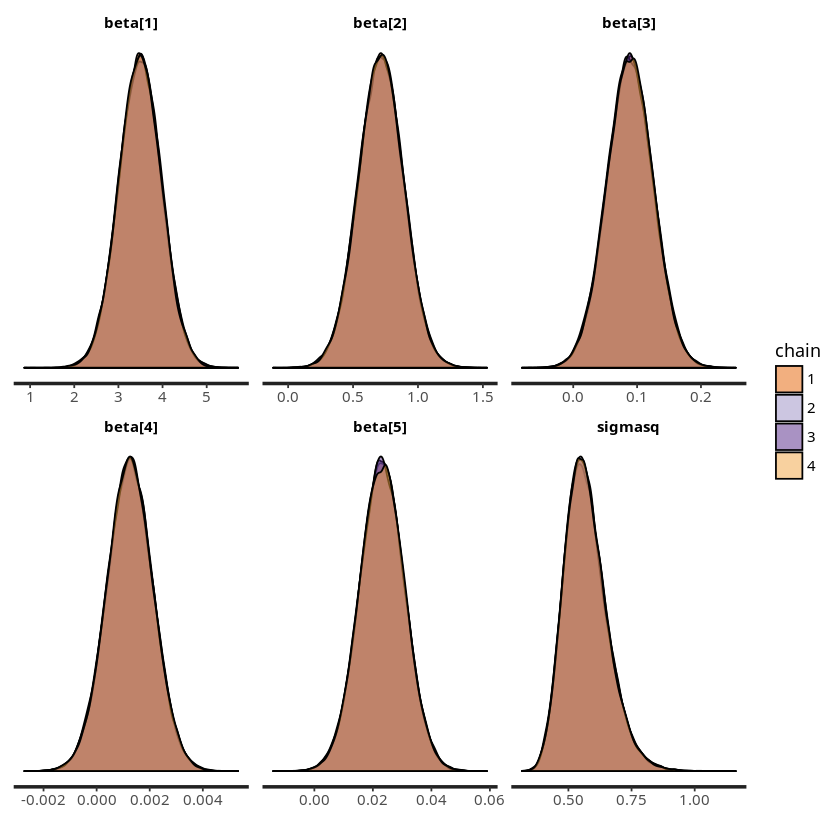

In [24]:
# plot of densities
stan_dens(fit2, par = c("beta", "sigmasq"), separate_chains = TRUE)


In [25]:
summary(fit2)$summary[,"Rhat"][1:7]

prec   beta[1]   beta[2]   beta[3]   beta[4]   beta[5]   sigmasq 
0.9999905 1.0000394 1.0000115 1.0000541 0.9999903 0.9999892 0.9999909

In [26]:
# 95% central posterior intervals
summary(fit2)$summary[1:7,c("2.5%", "97.5%")]

,2.5%,97.5%
prec,1.3140582553,2.34059056
beta[1],2.5444526541,4.43993966
beta[2],0.3710877298,1.05799526
beta[3],0.0171894920,0.16037419
beta[4],-0.0004731761,0.00296546
beta[5],0.0080405606,0.03825620
sigmasq,0.4272426022,0.76100127


In [27]:

summary(fit2)$summary[,"mean"][1:7]

prec     beta[1]     beta[2]     beta[3]     beta[4]     beta[5] 
1.789227325 3.491805776 0.715001102 0.088882081 0.001251417 0.023142187 
    sigmasq 
0.571114797

In [28]:
#traceplot(fit2,par = c("beta", "sigmasq","prec"))


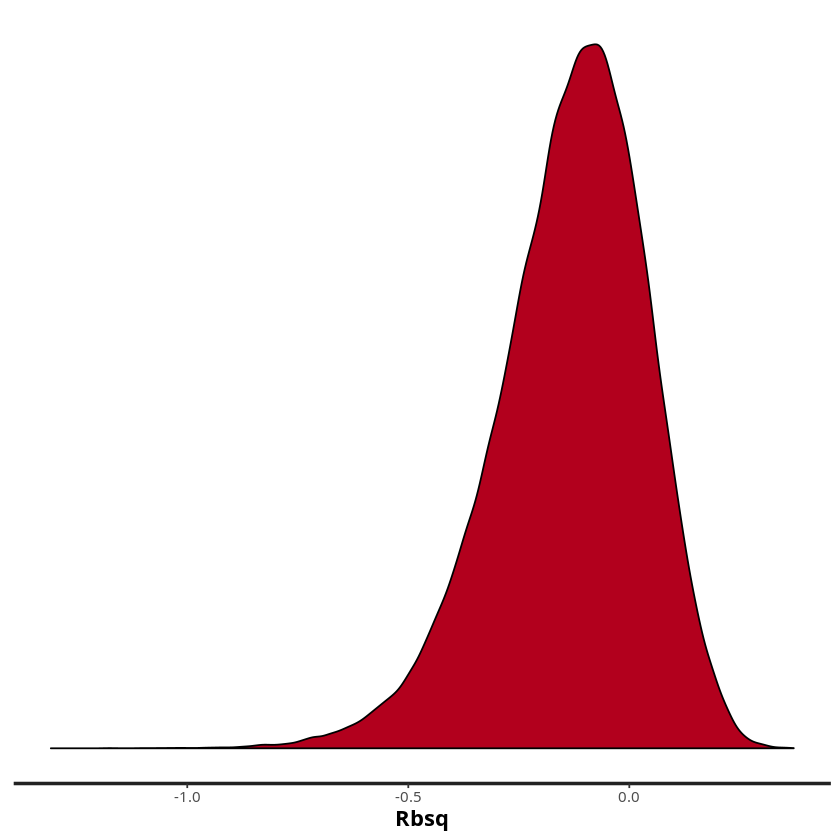

In [29]:
# distribution of Rb^2
stan_dens(fit2, "Rbsq")


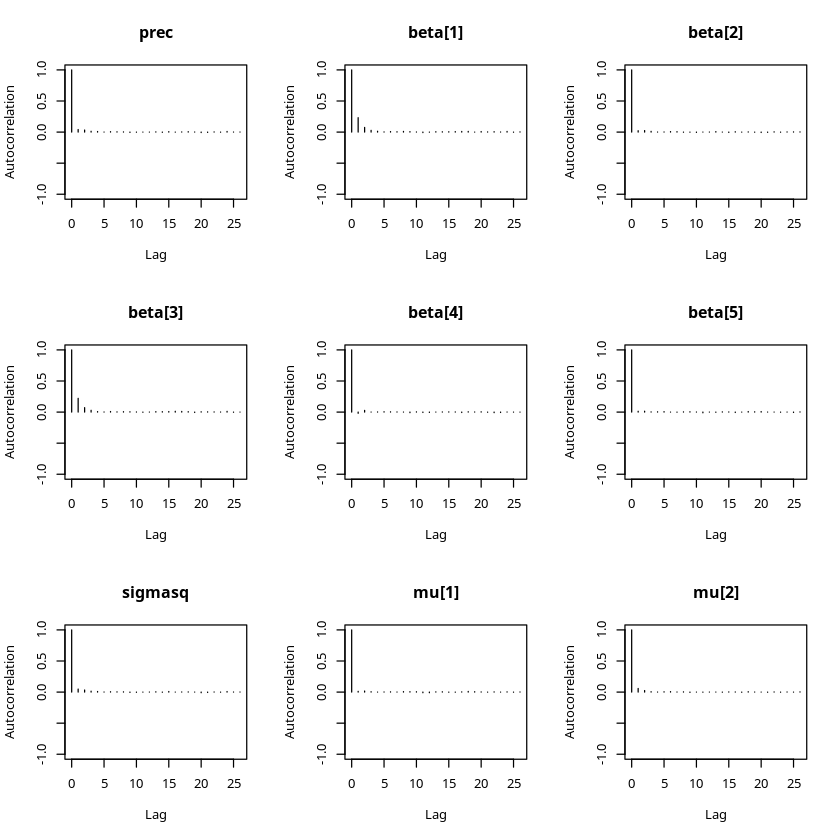

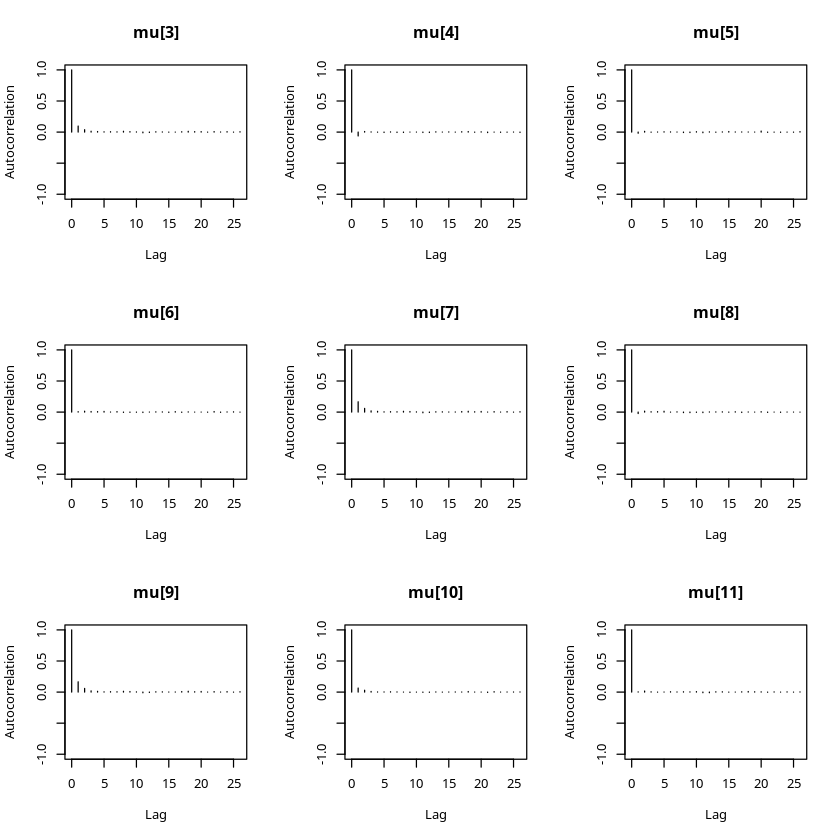

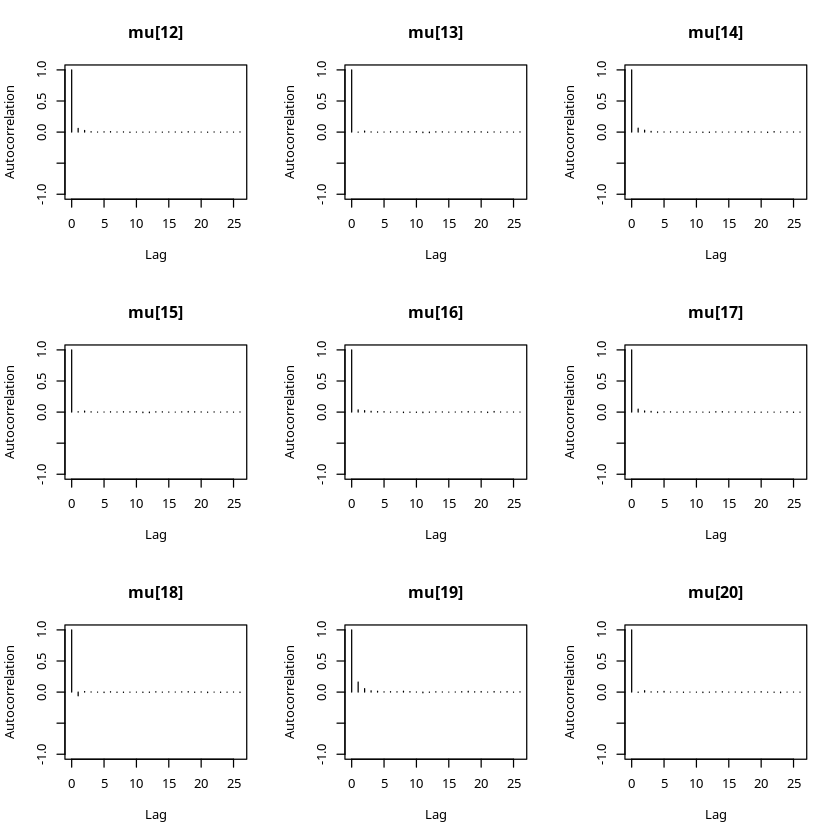

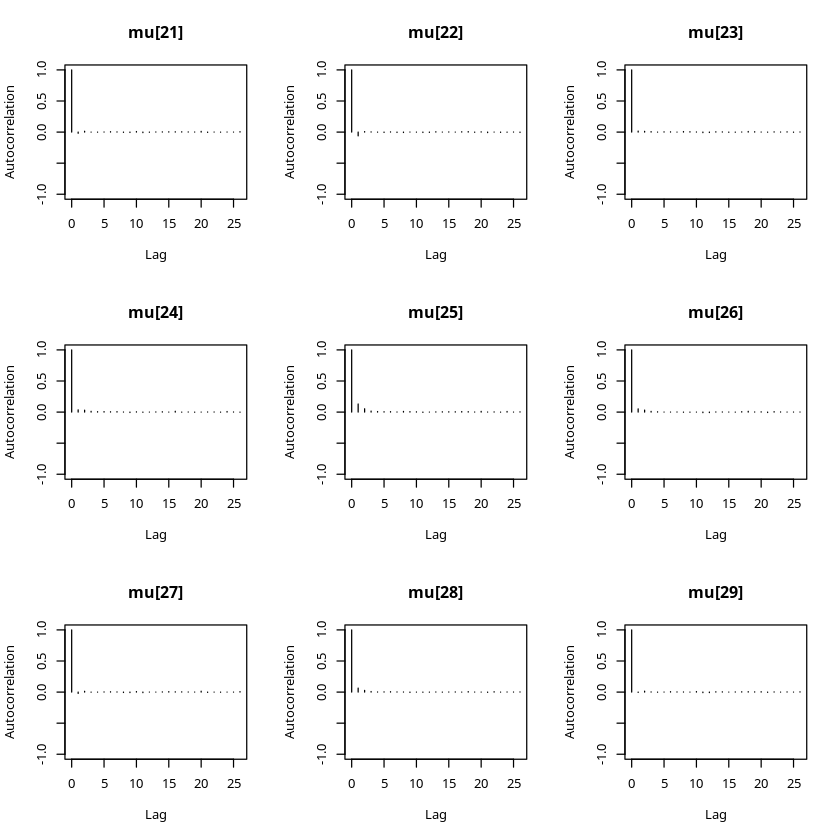

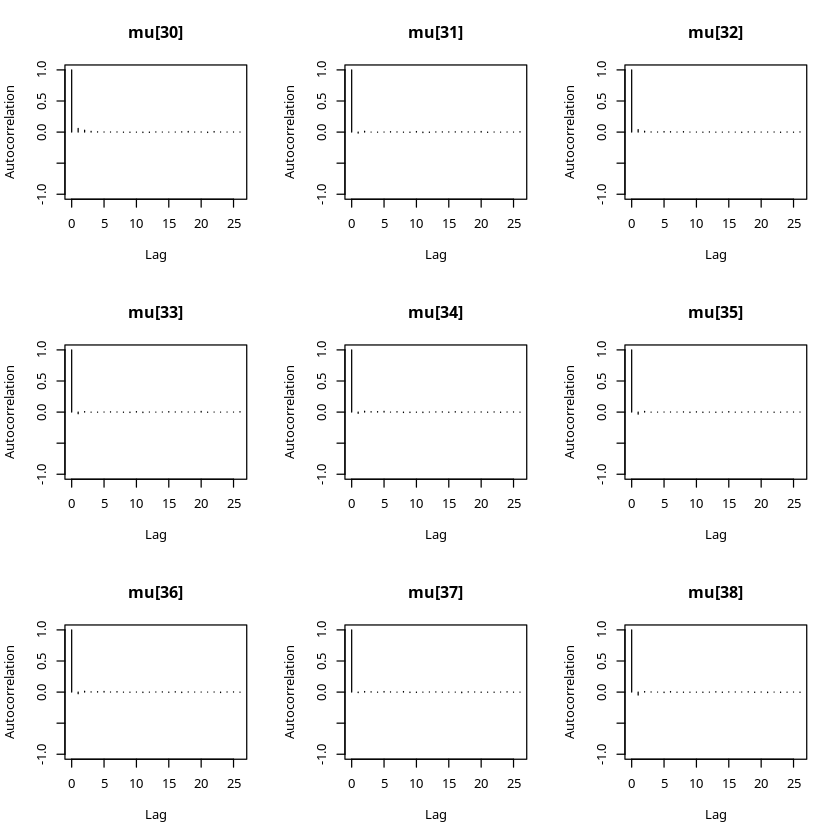

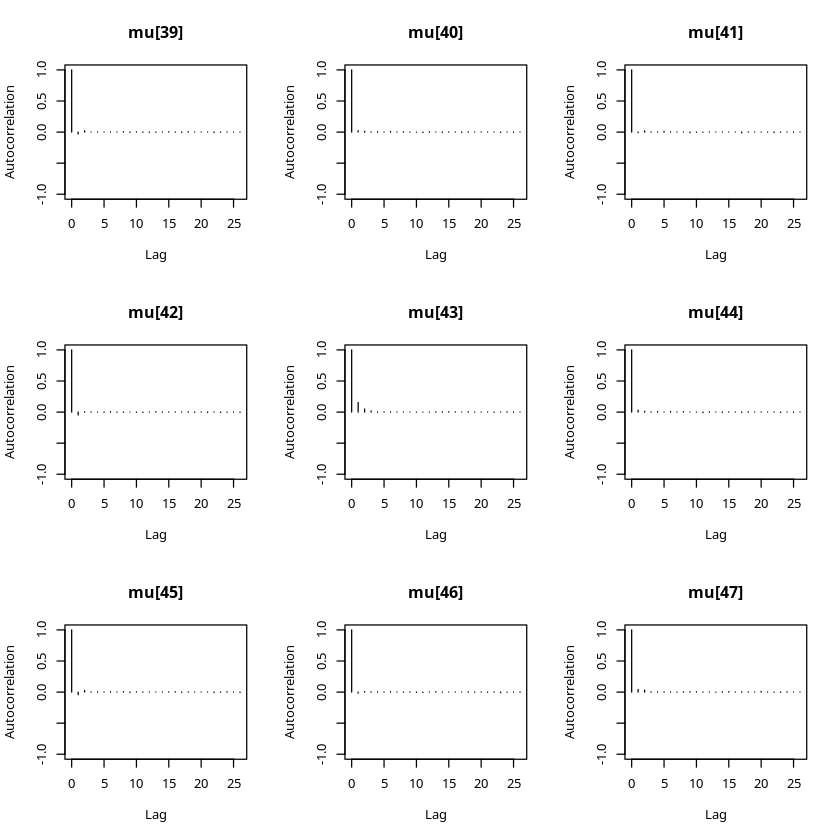

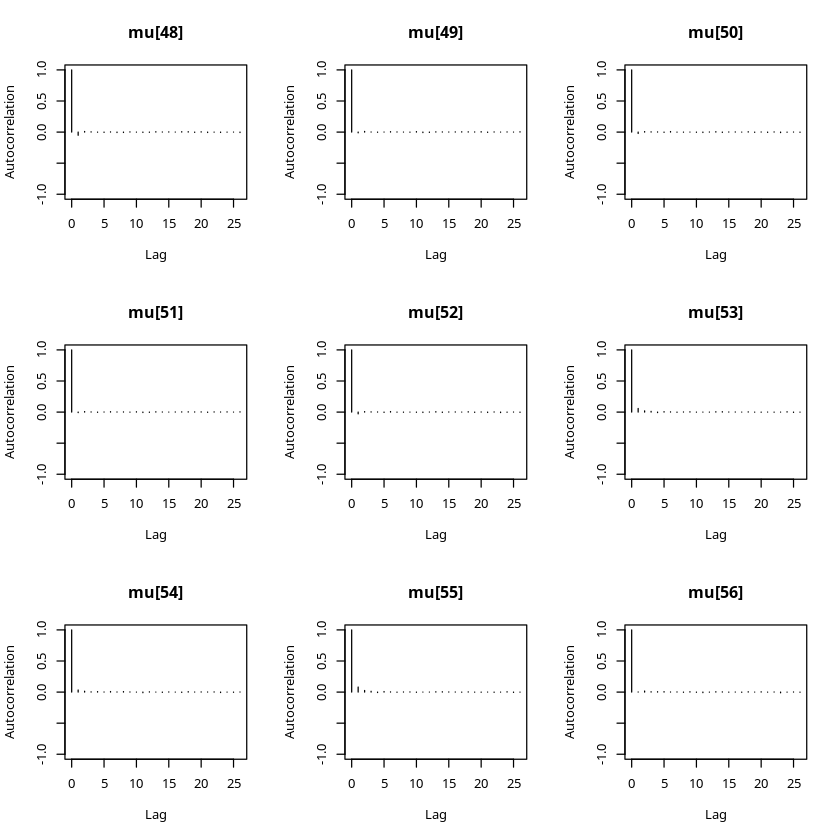

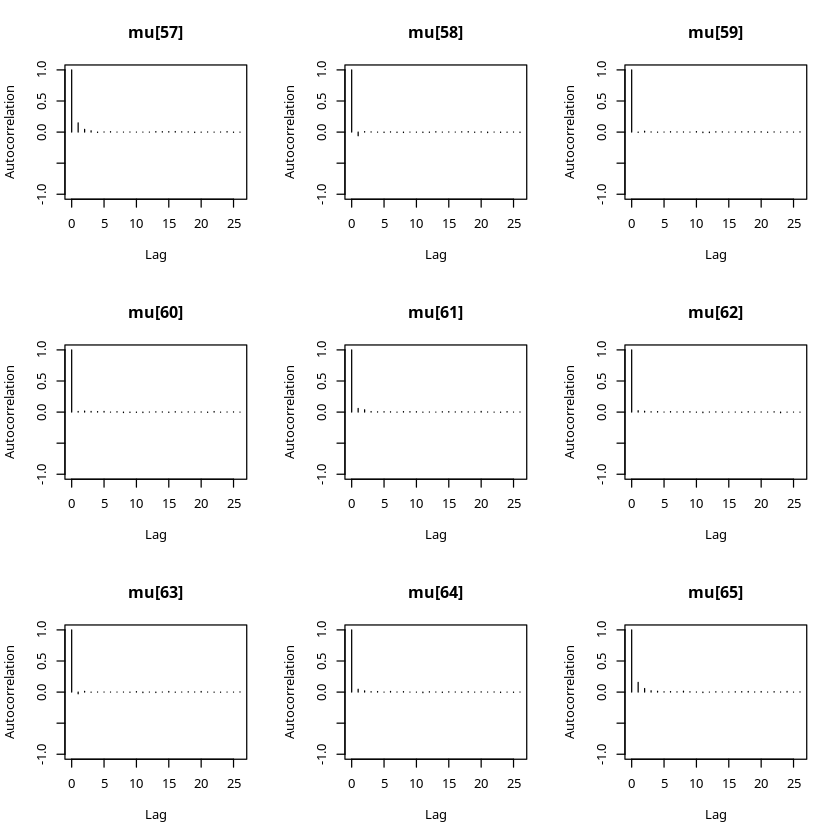

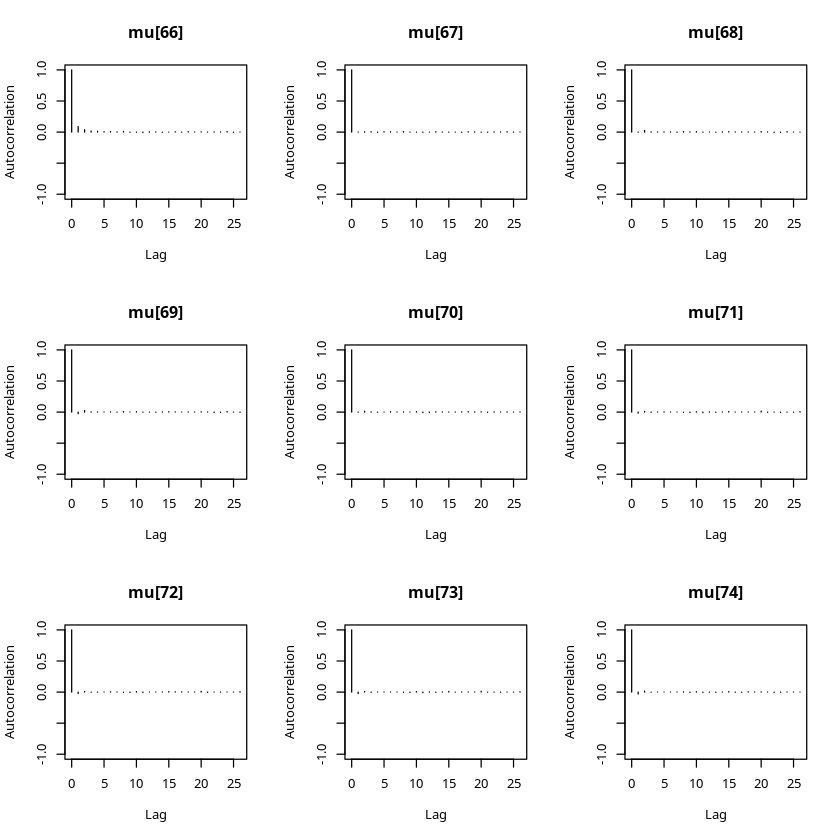

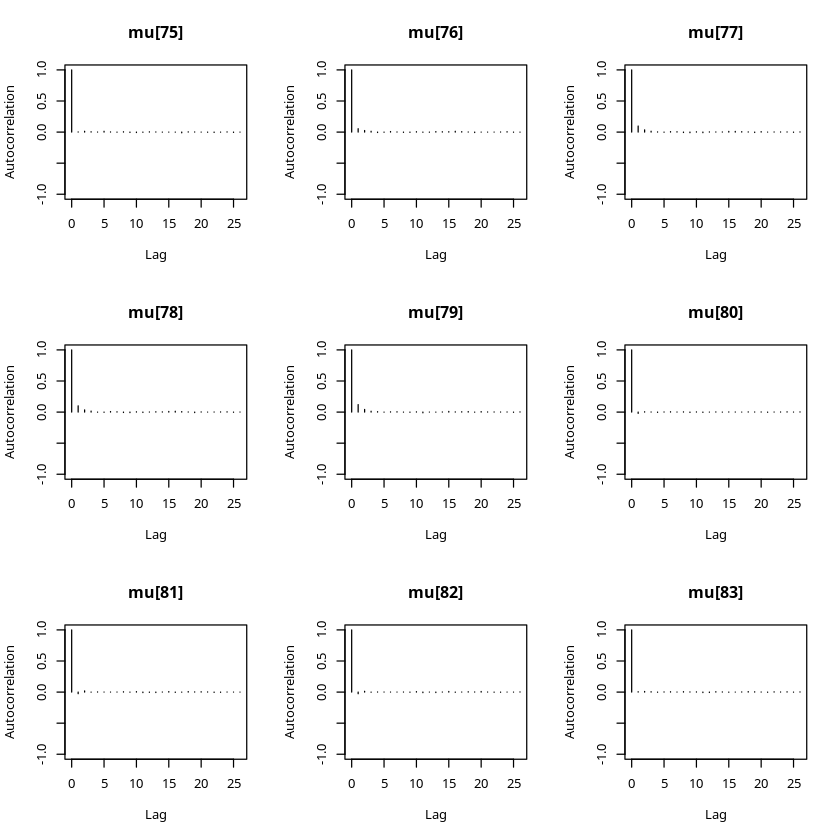

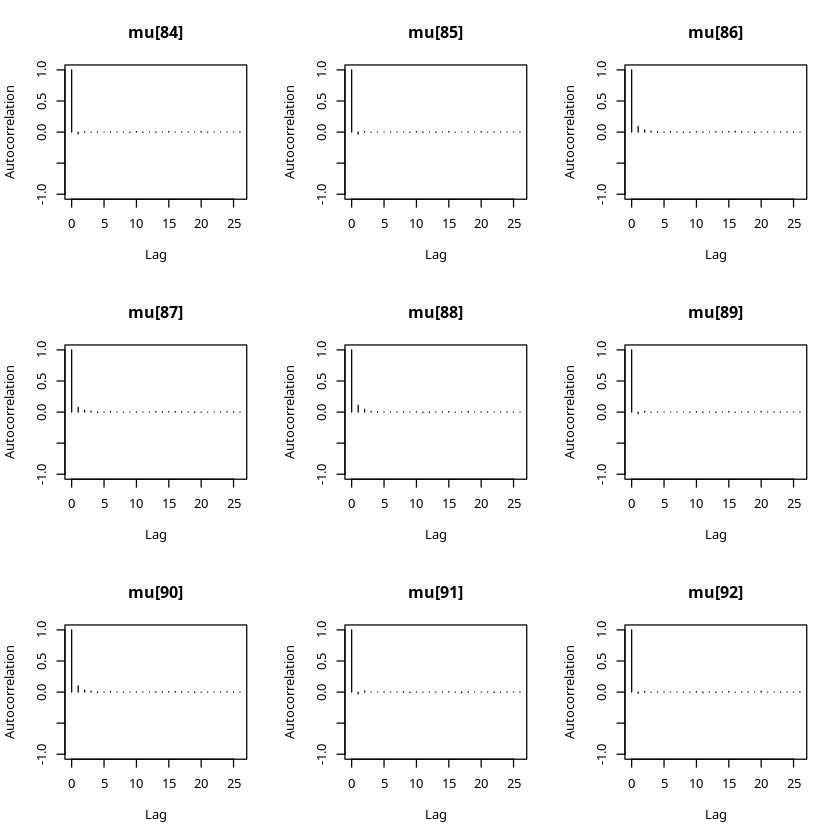

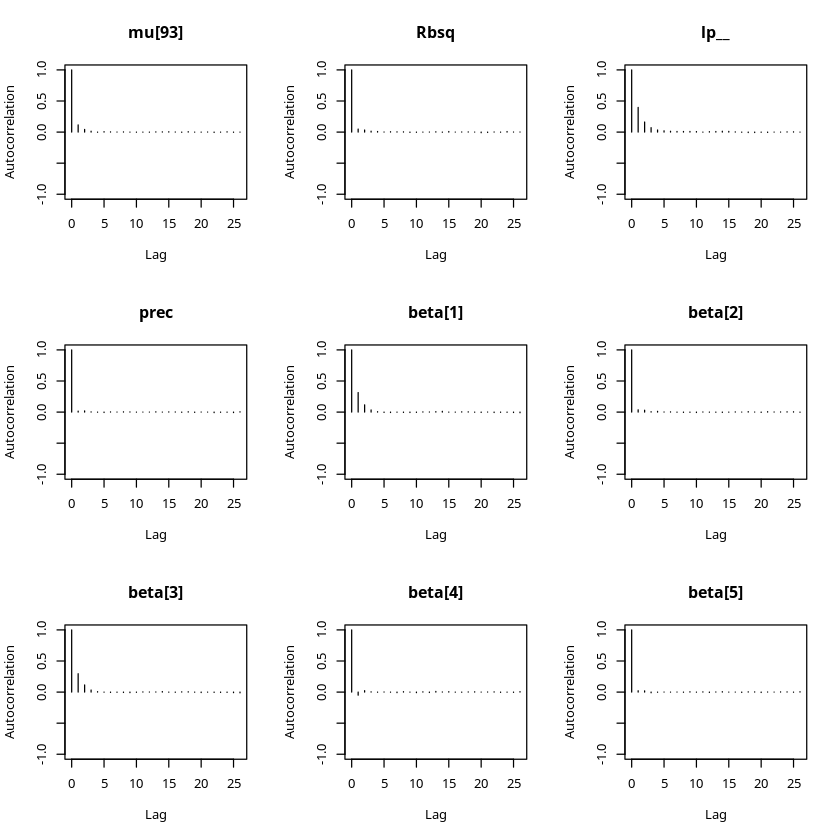

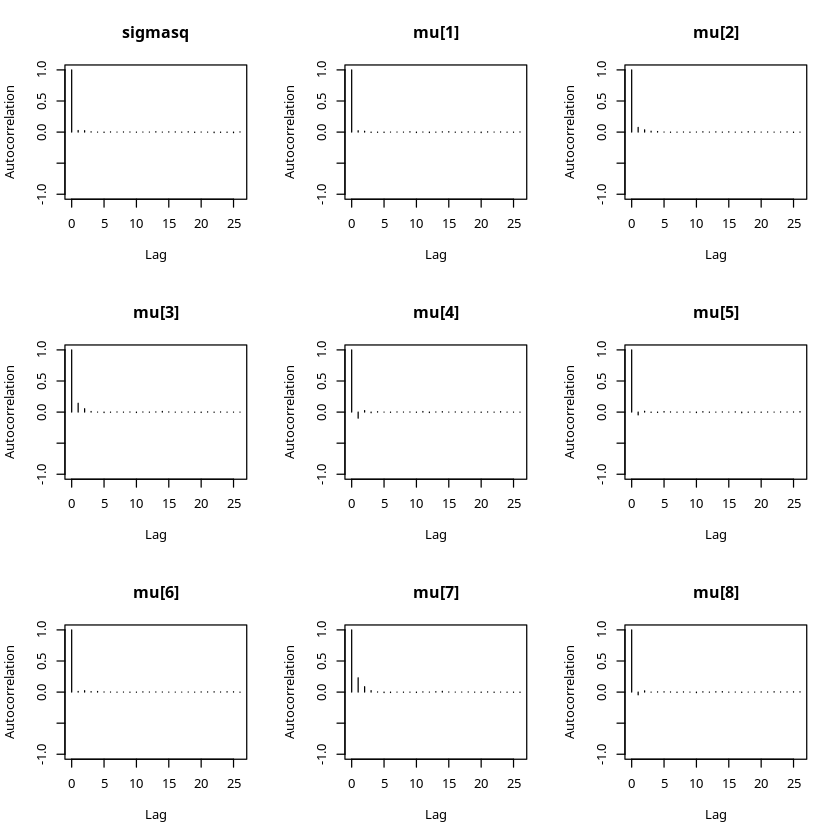

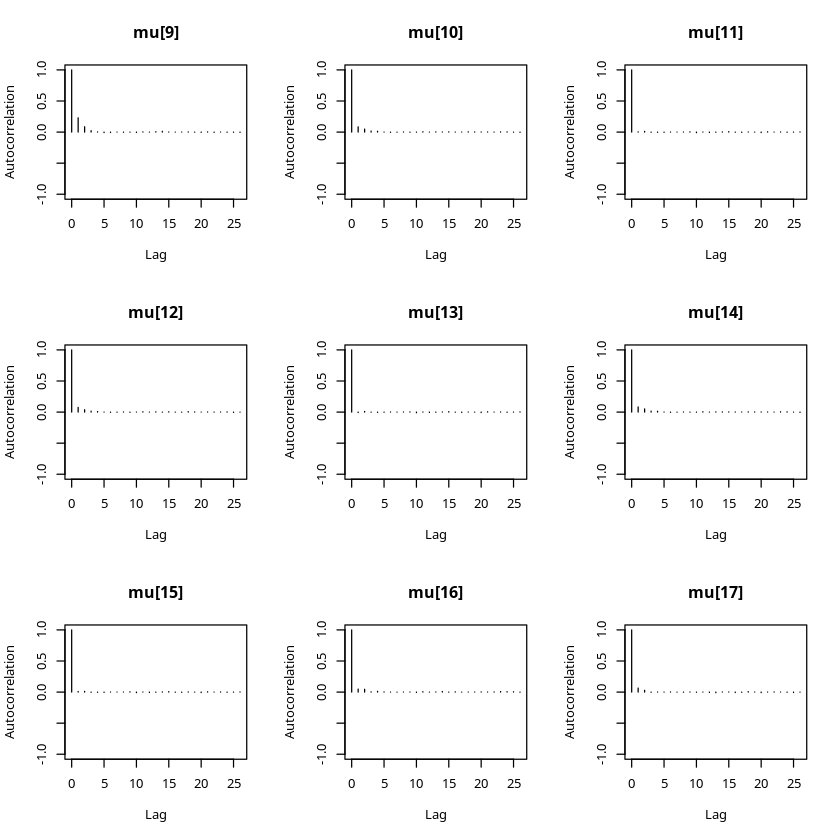

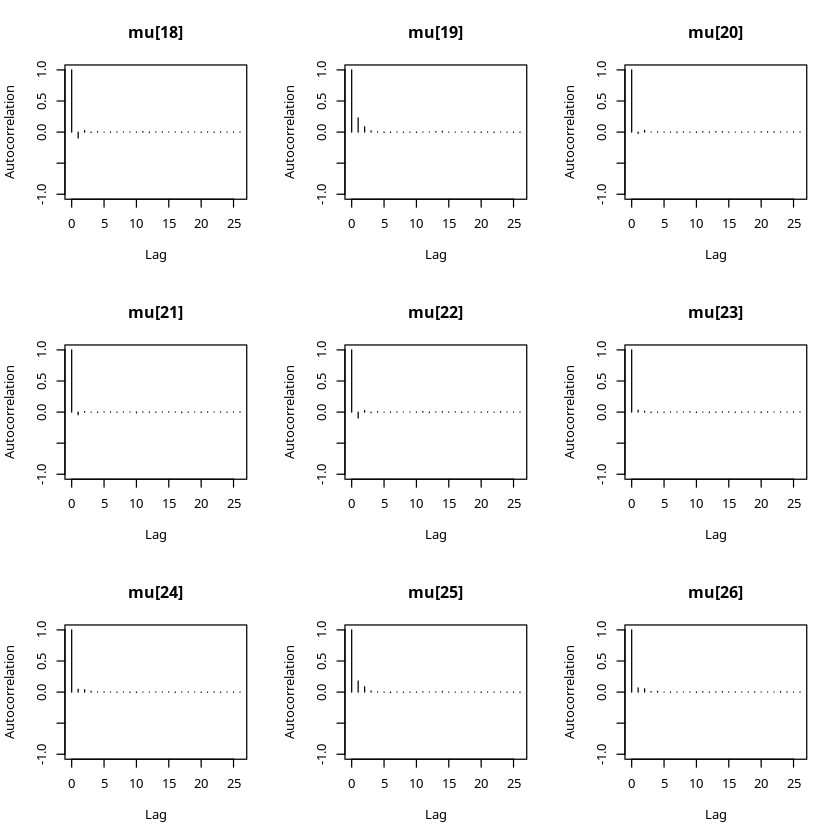

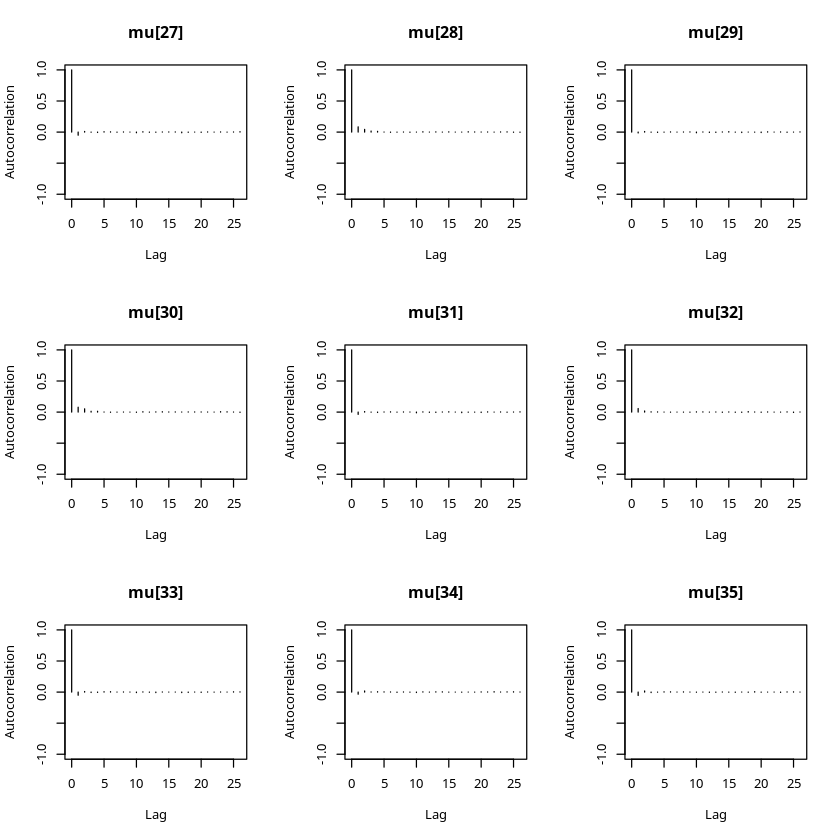

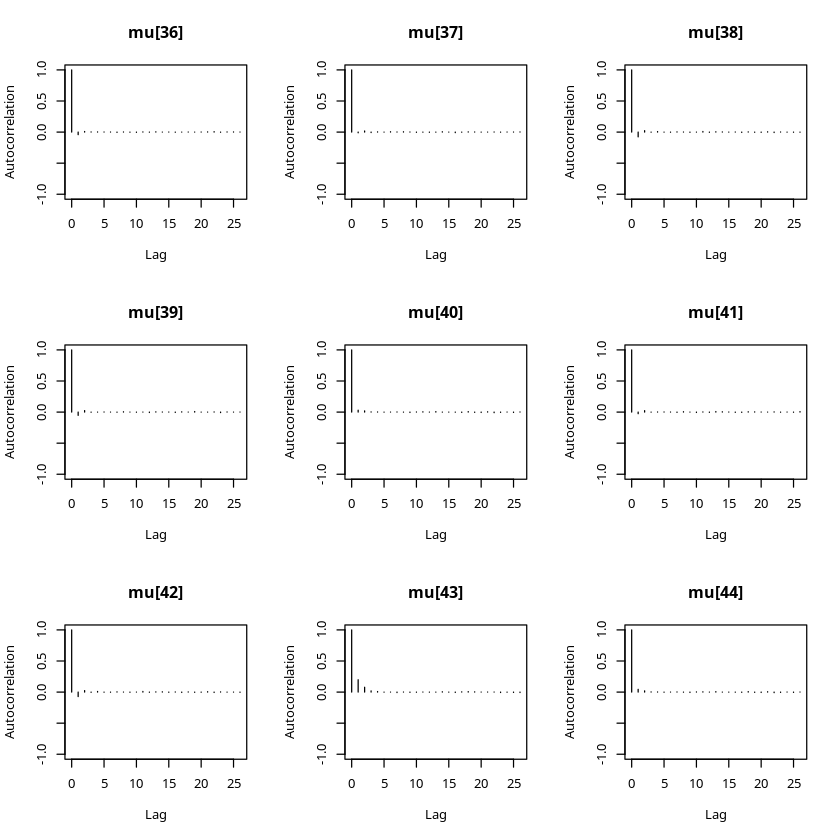

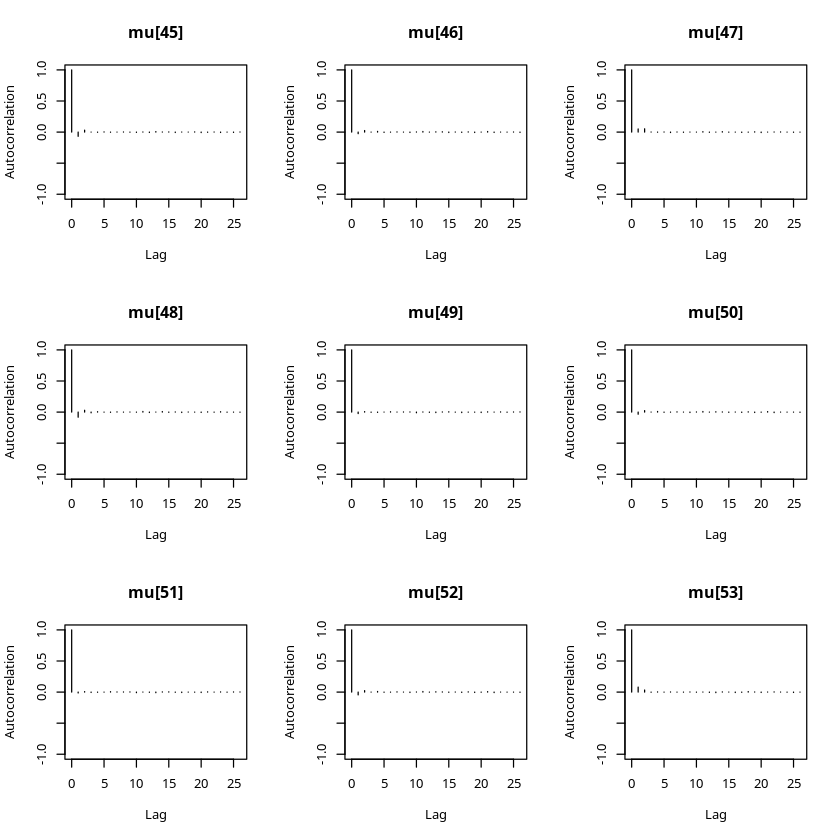

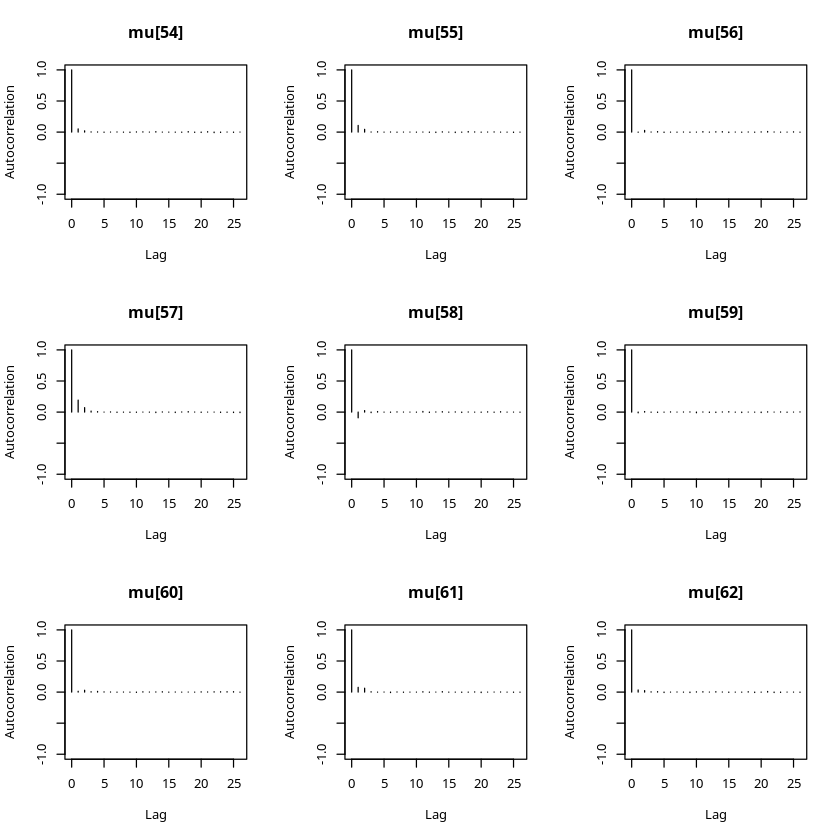

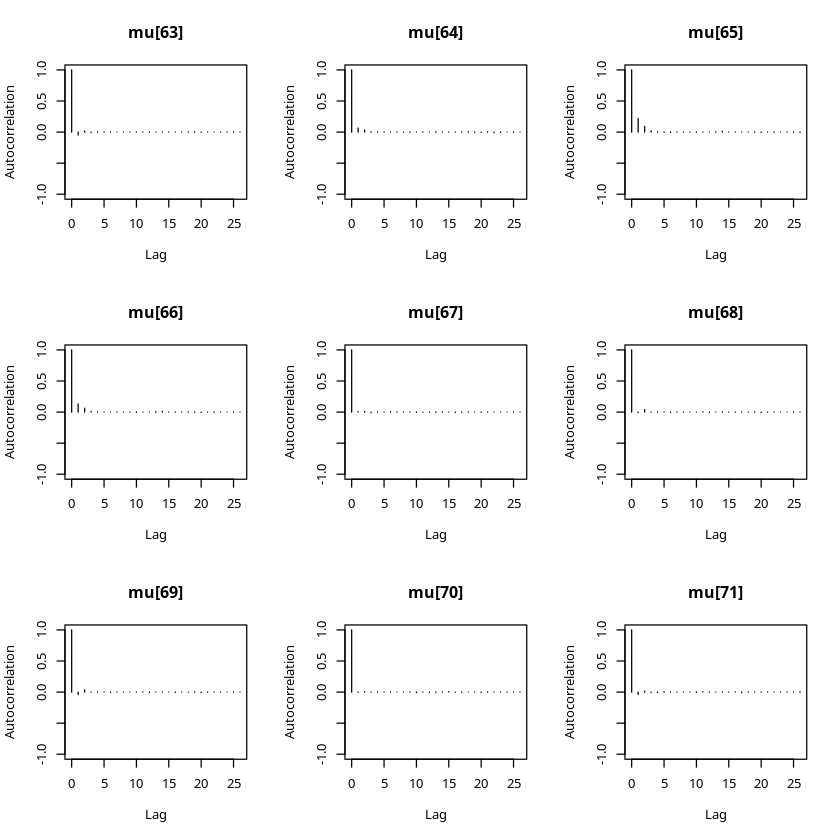

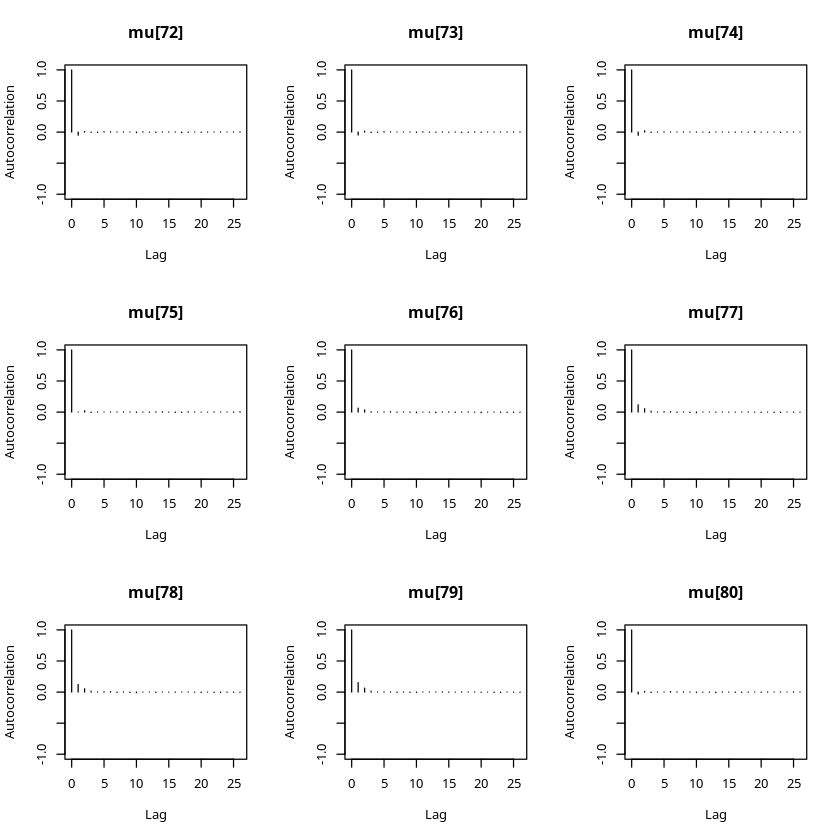

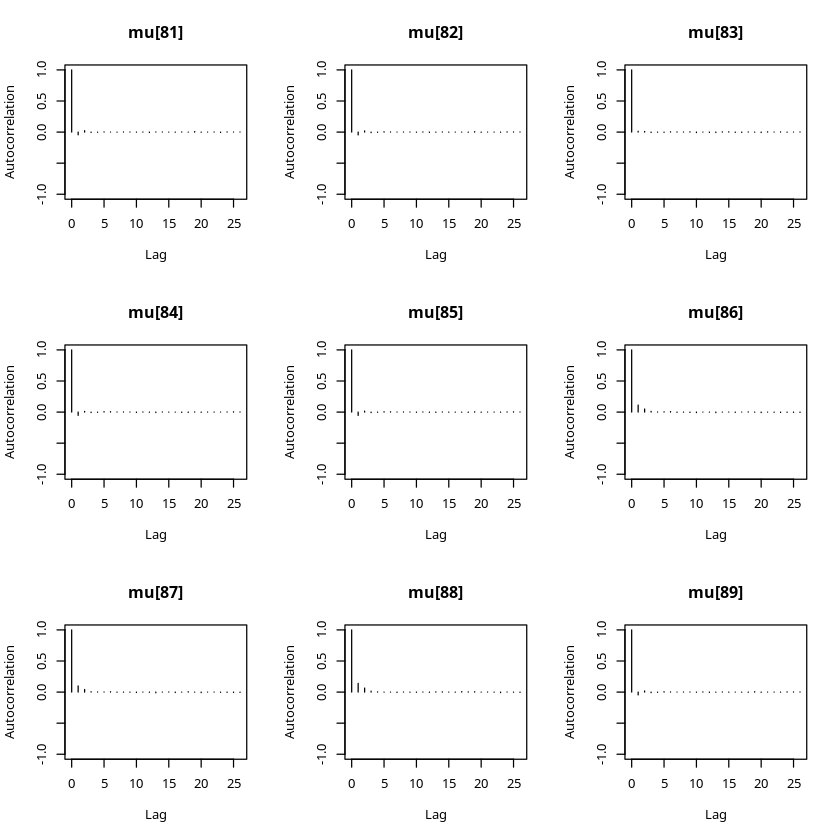

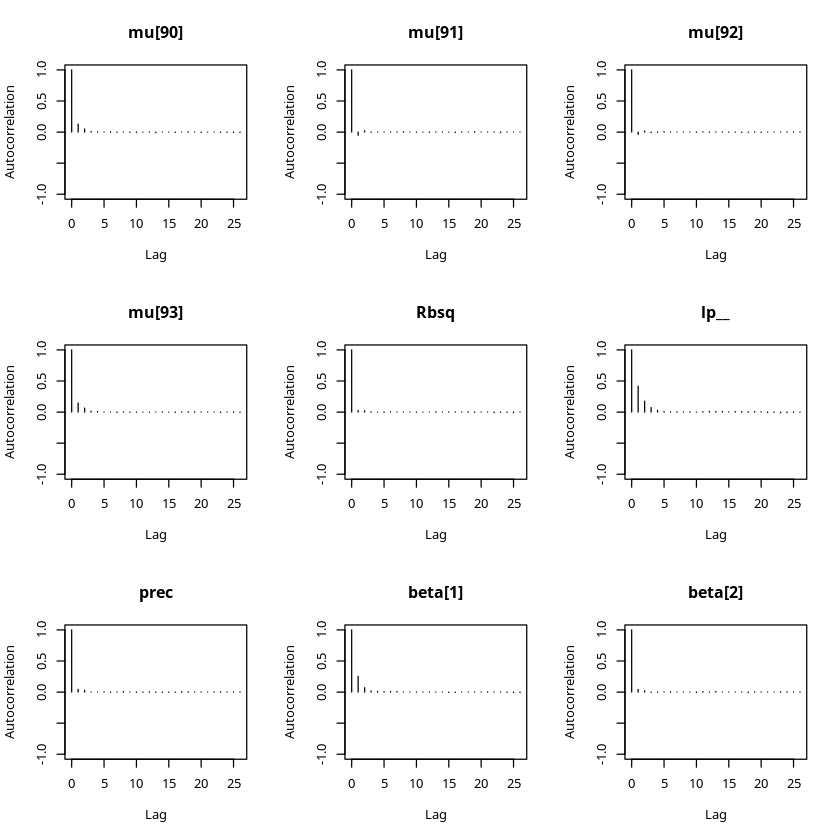

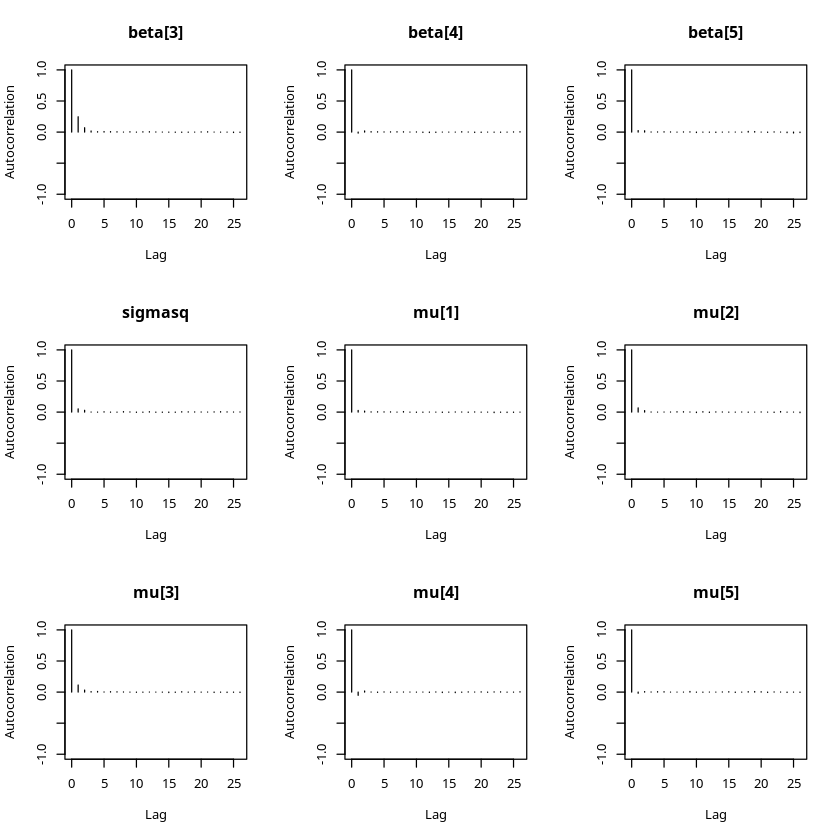

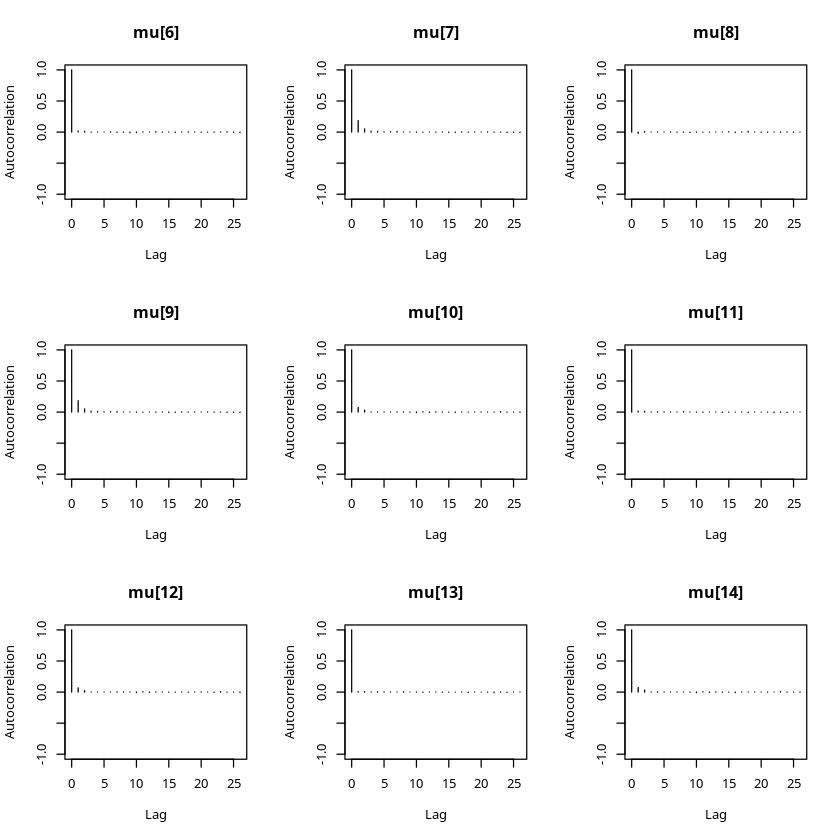

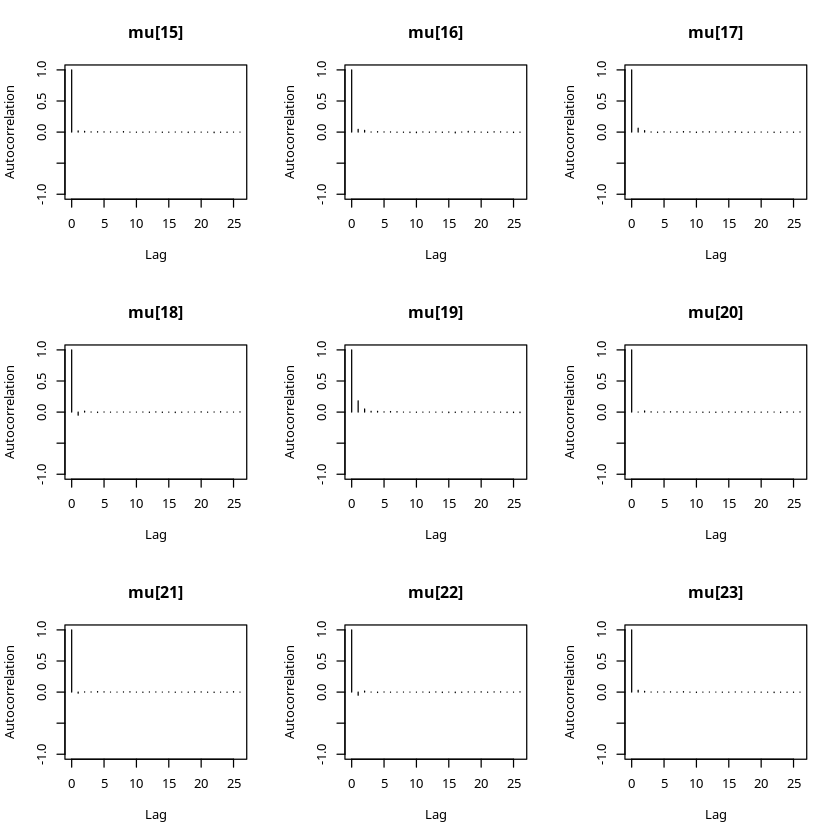

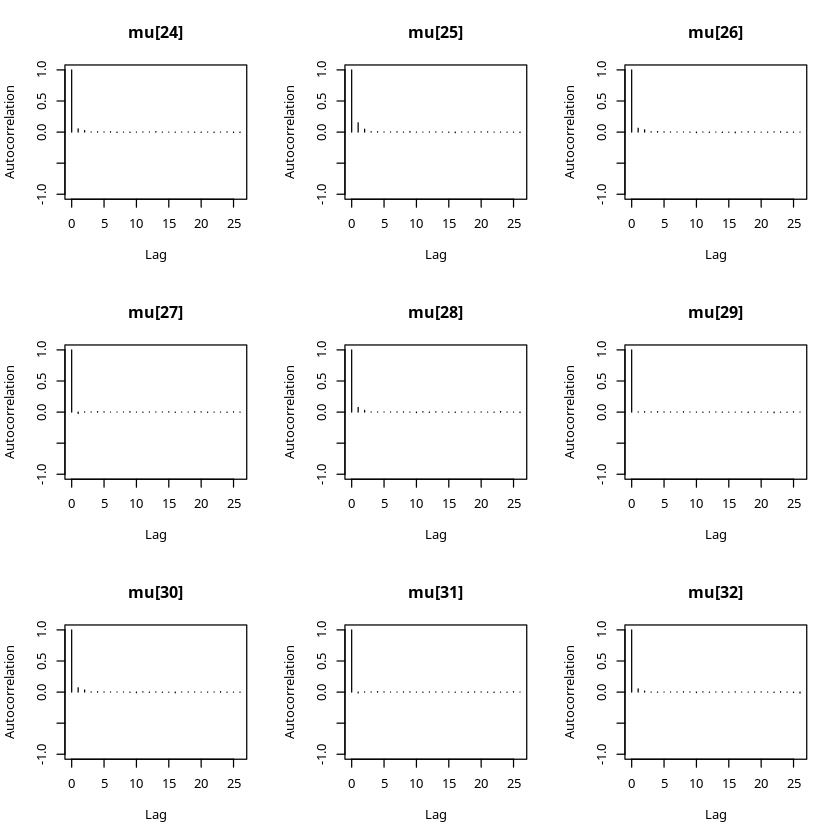

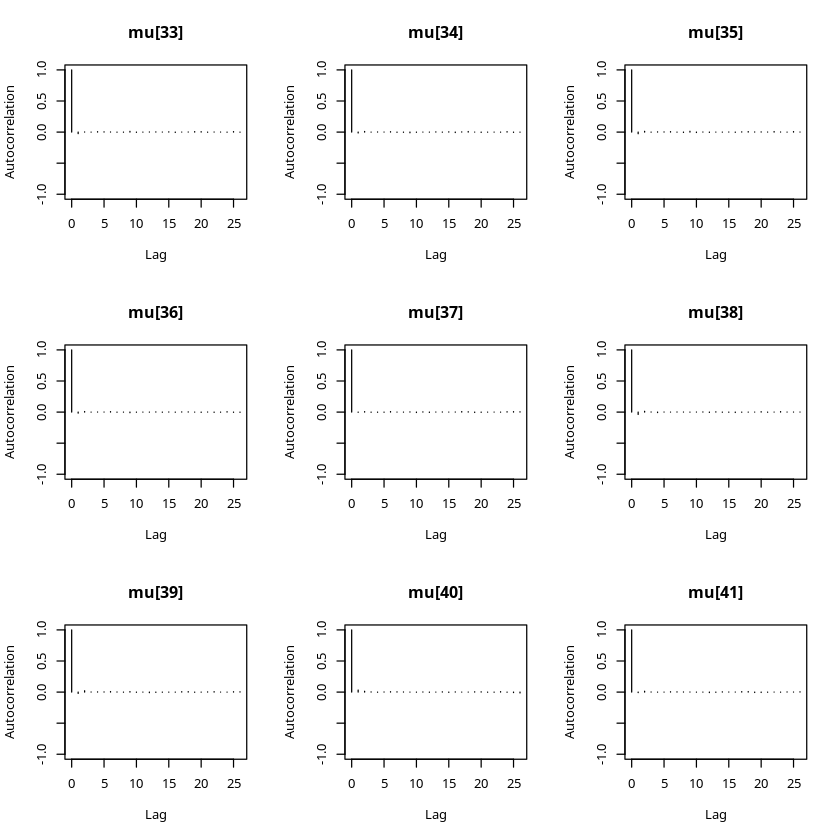

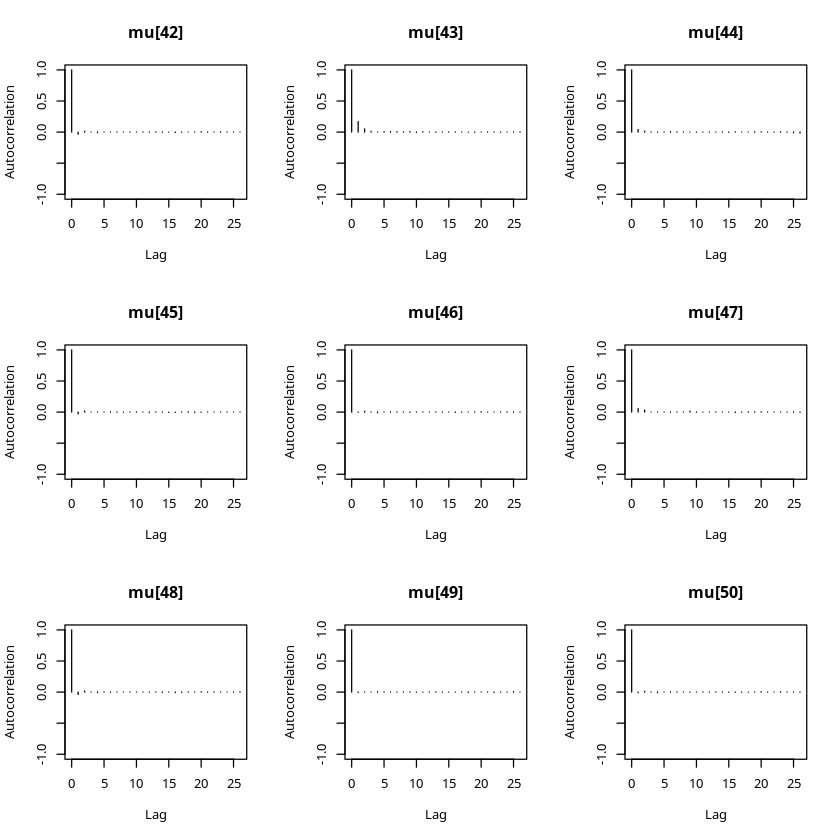

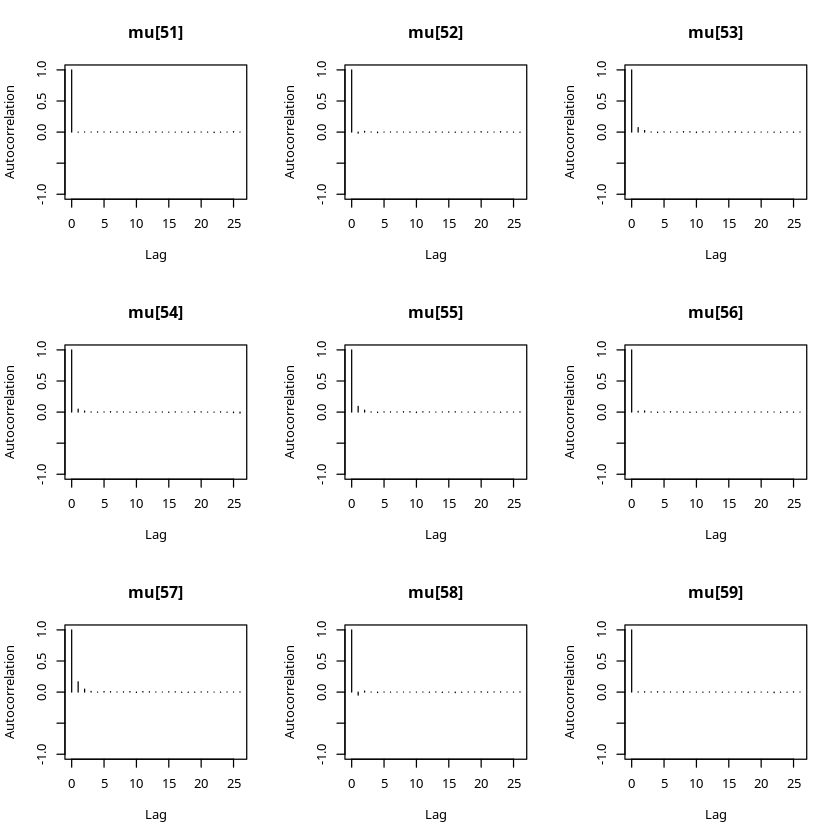

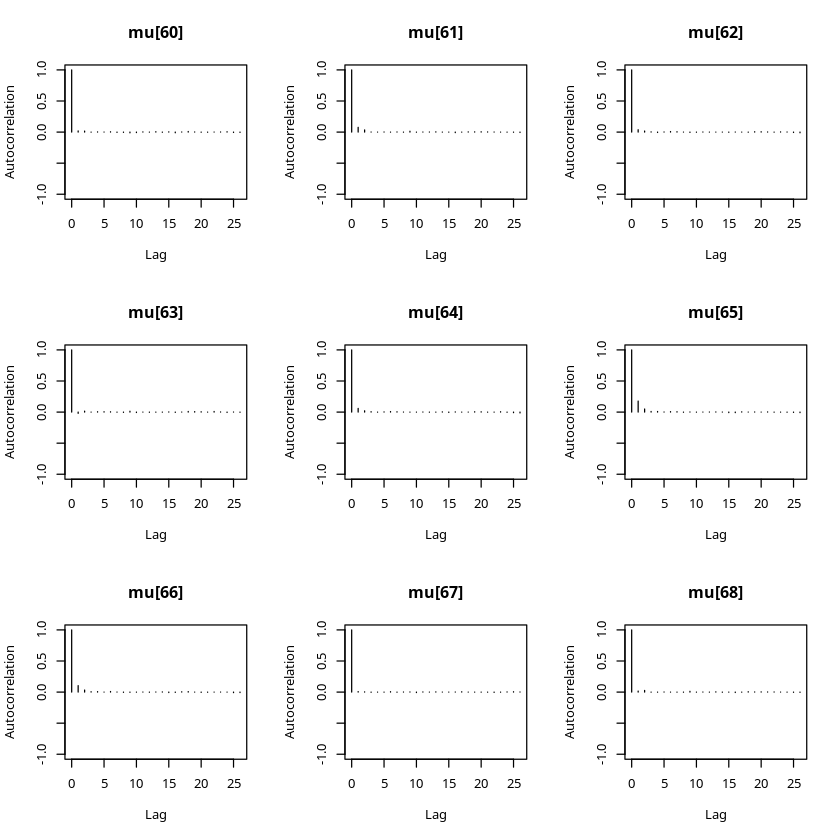

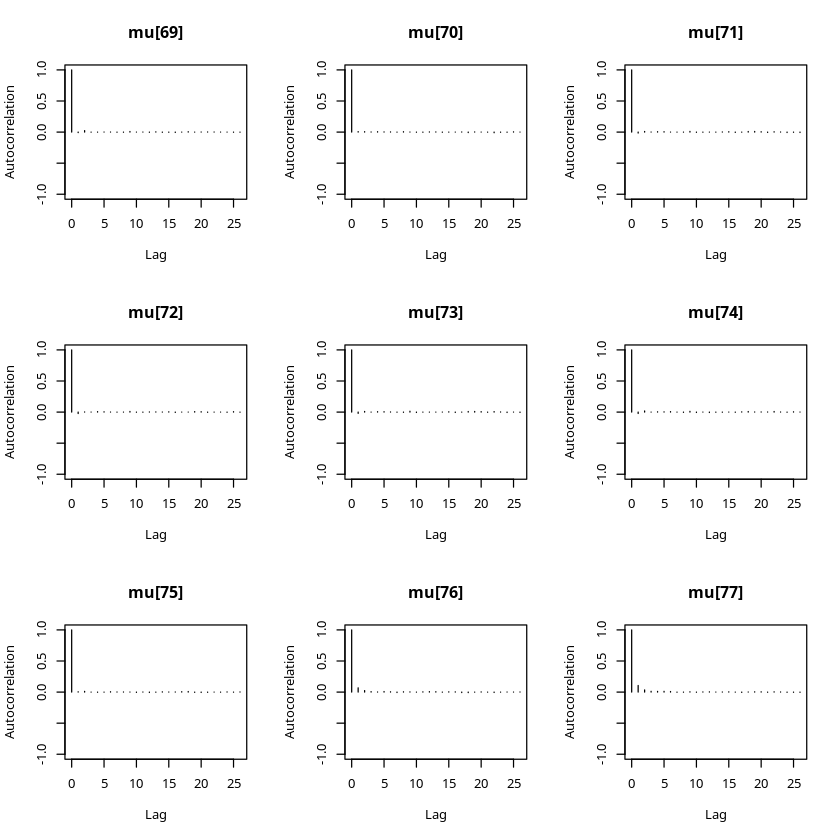

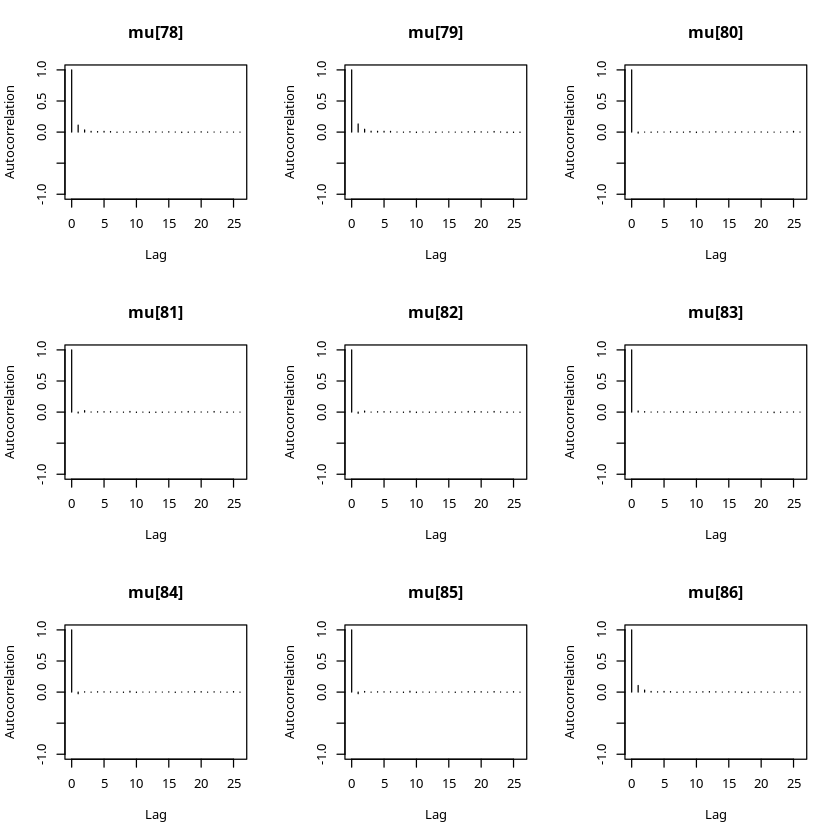

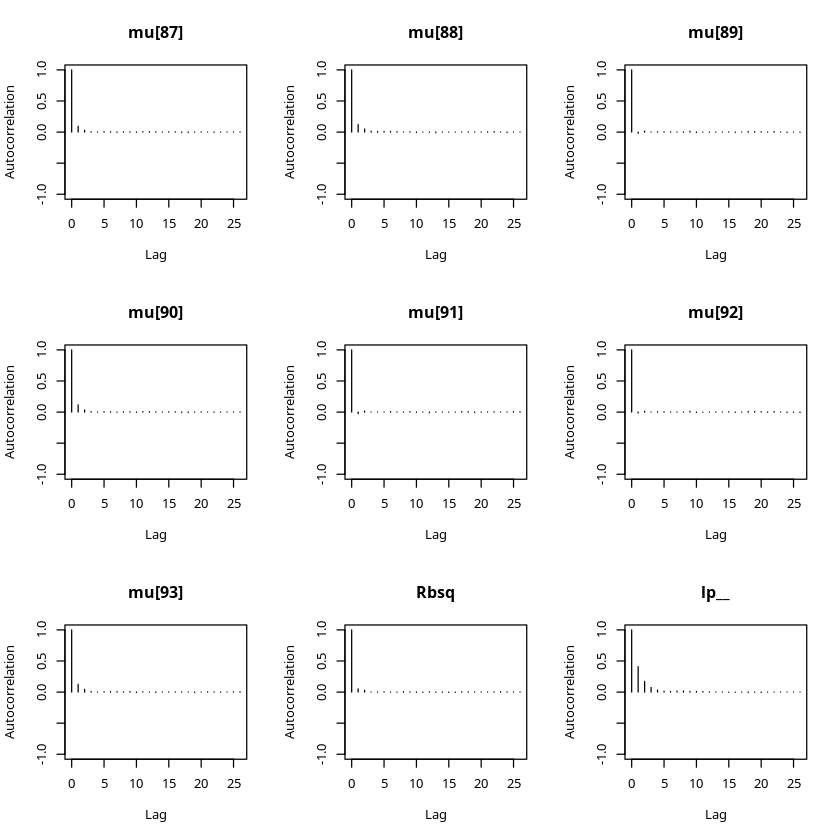

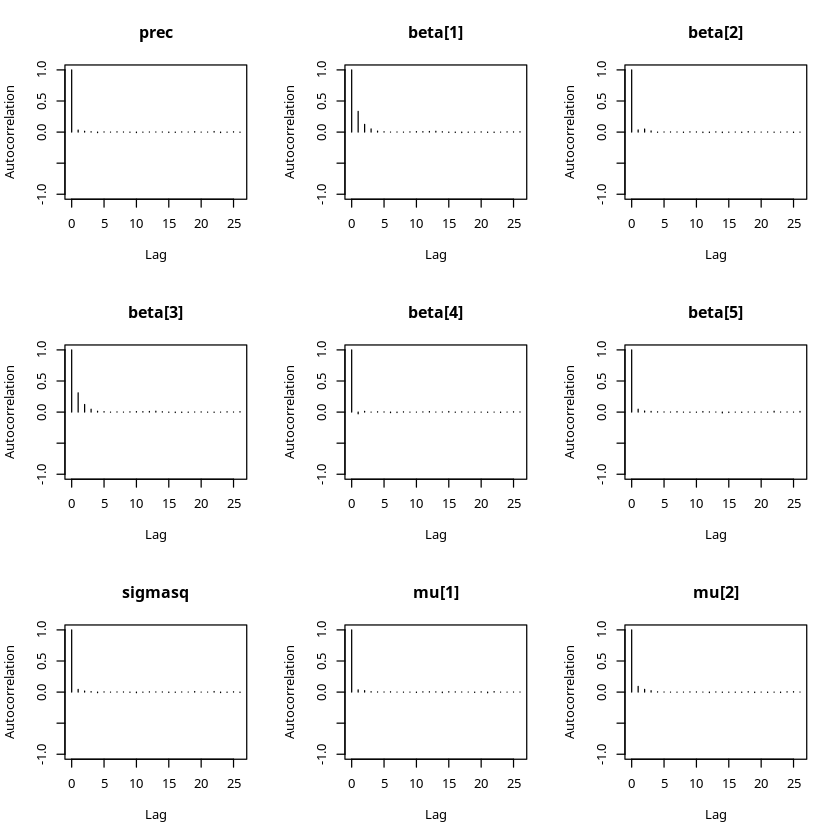

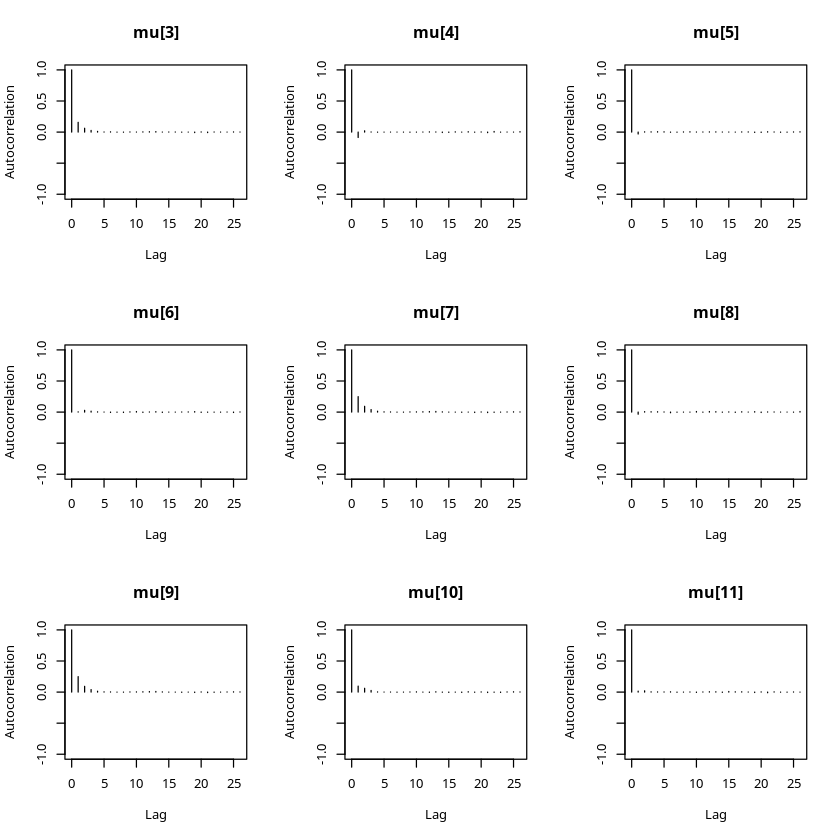

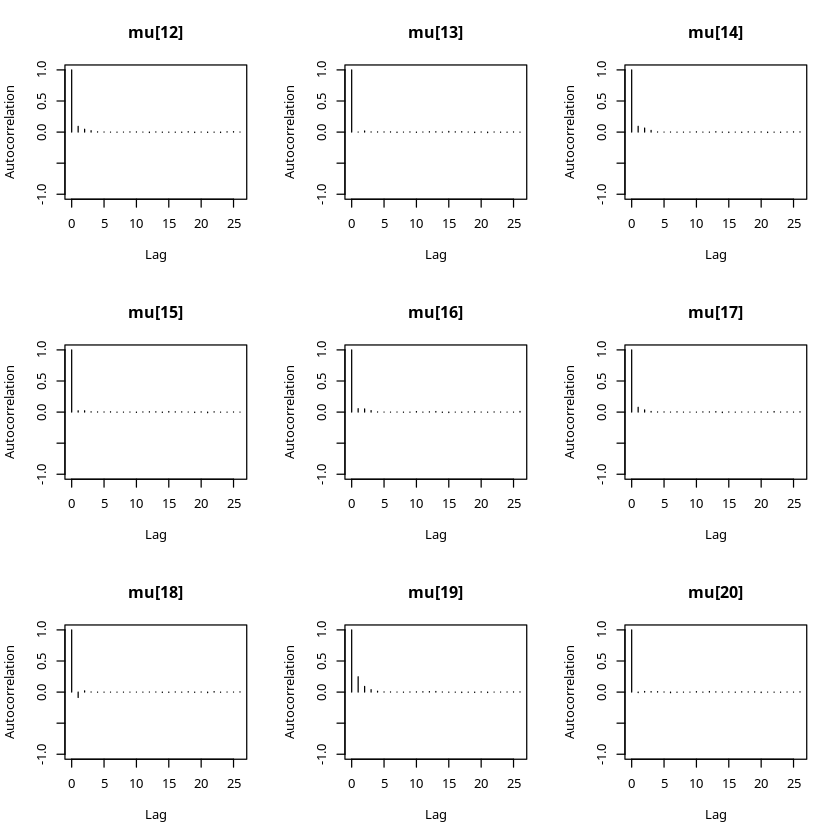

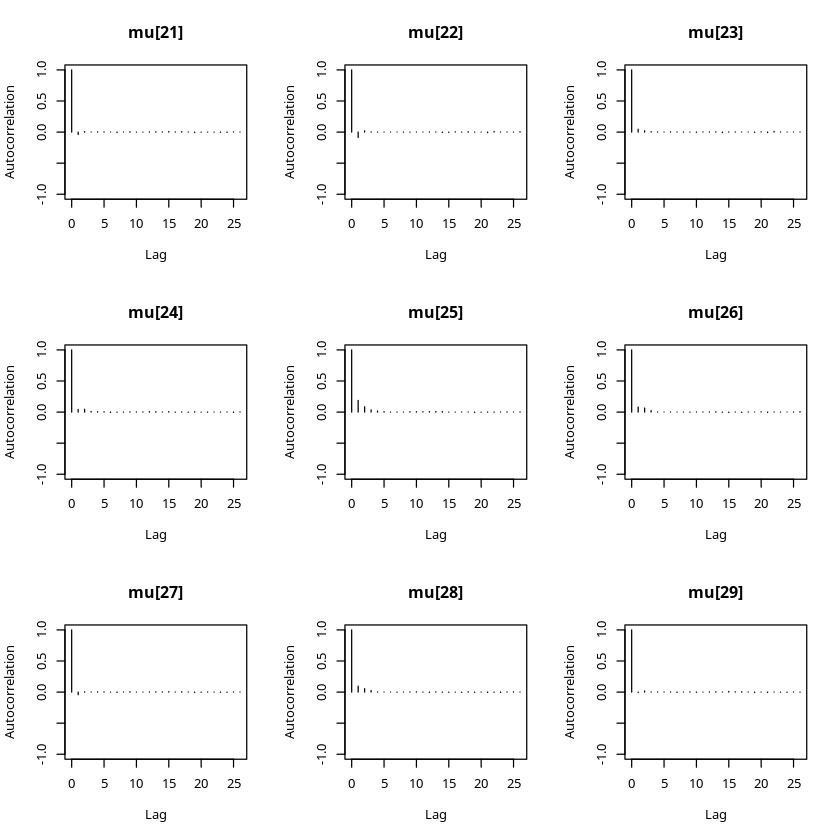

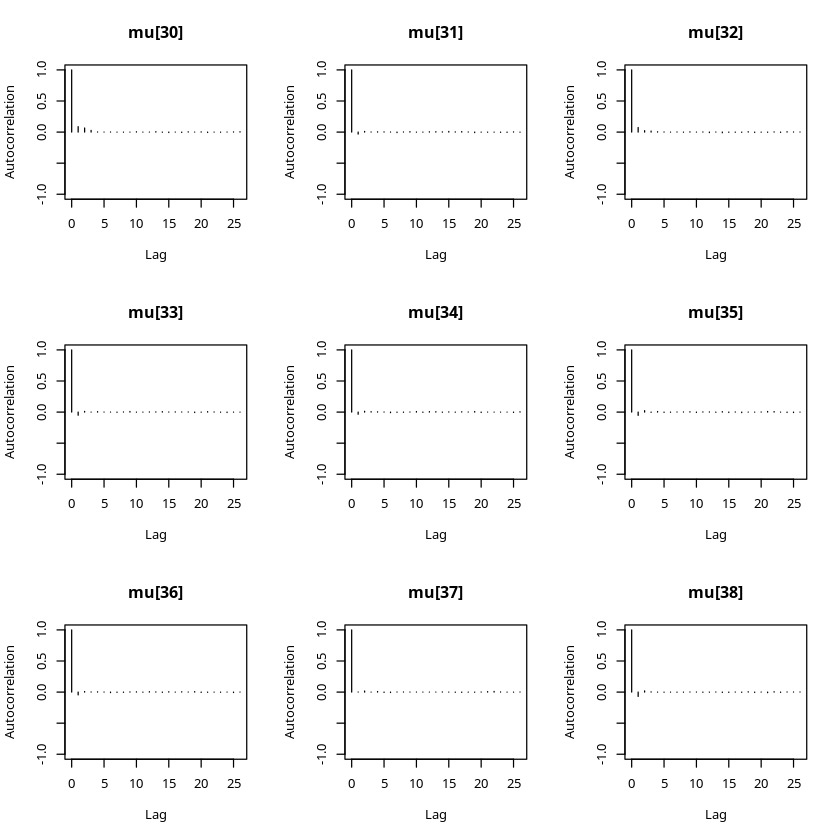

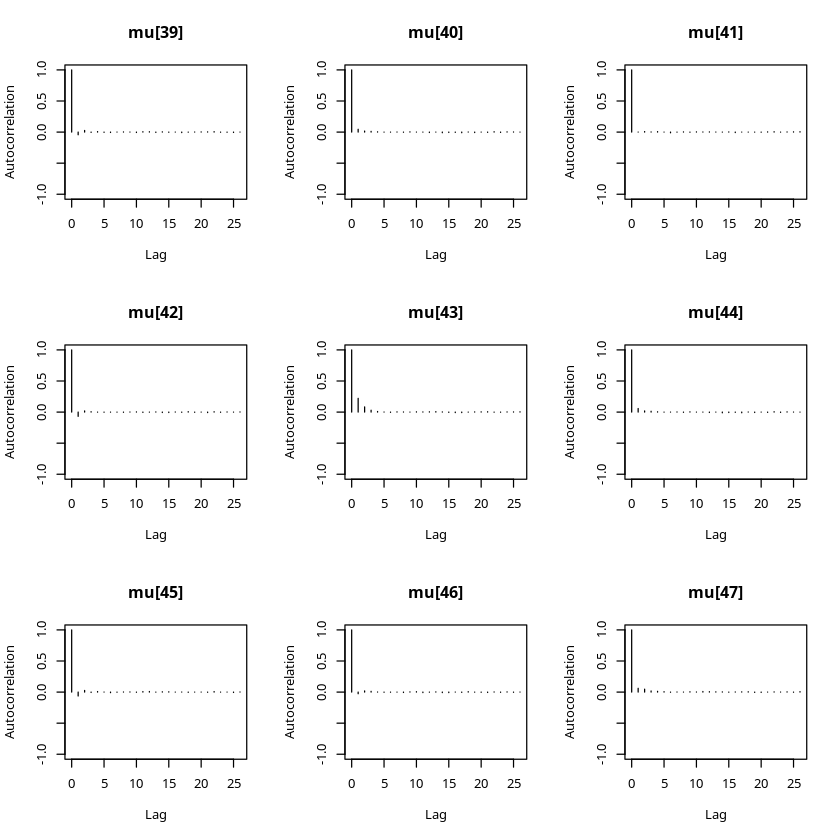

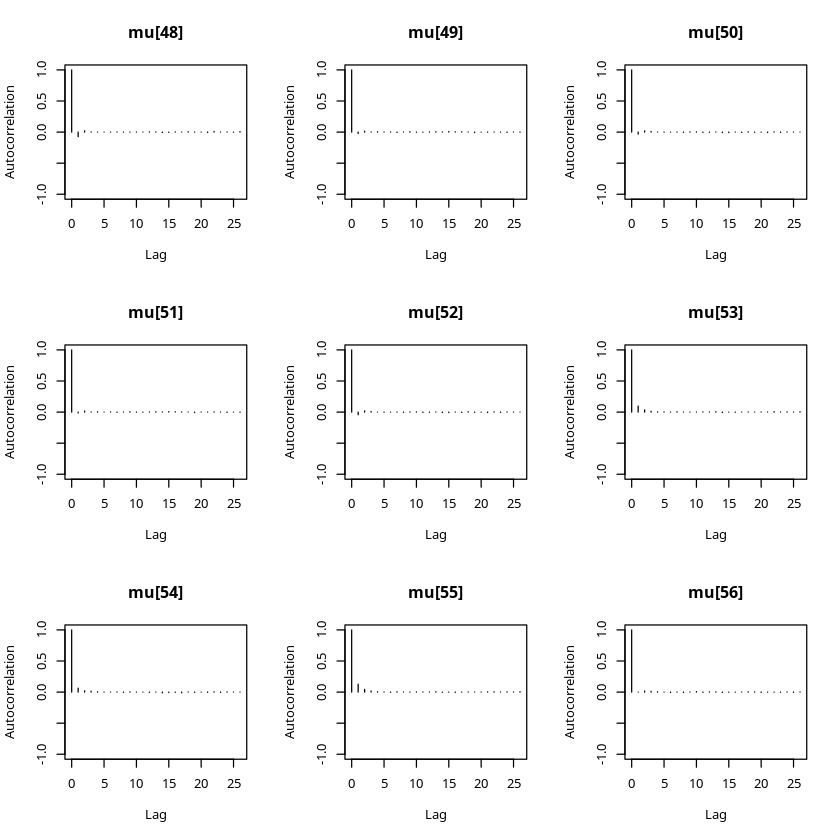

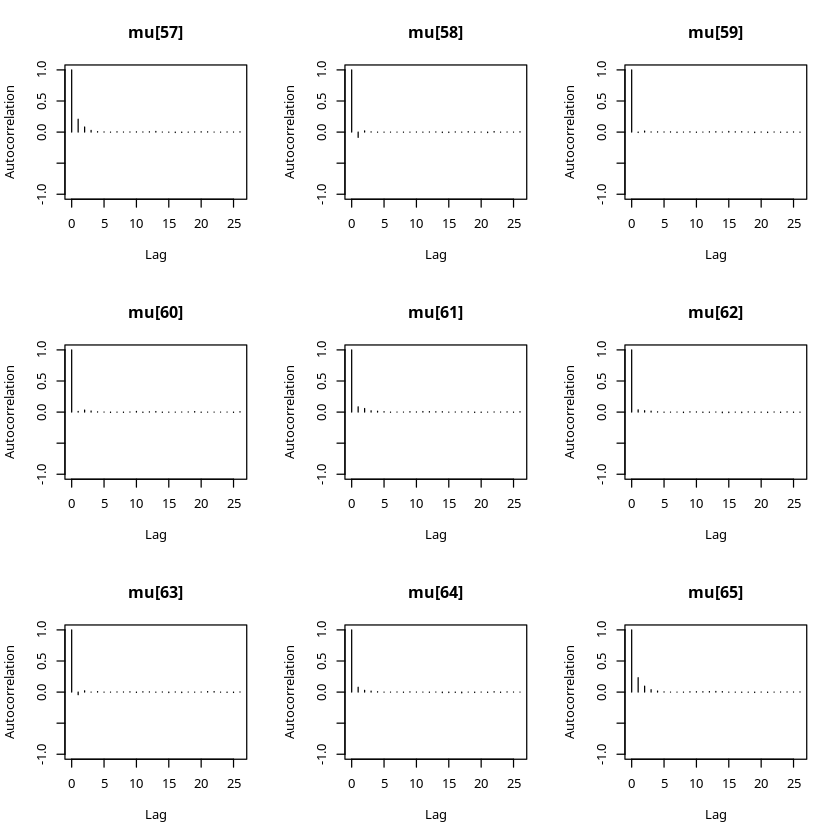

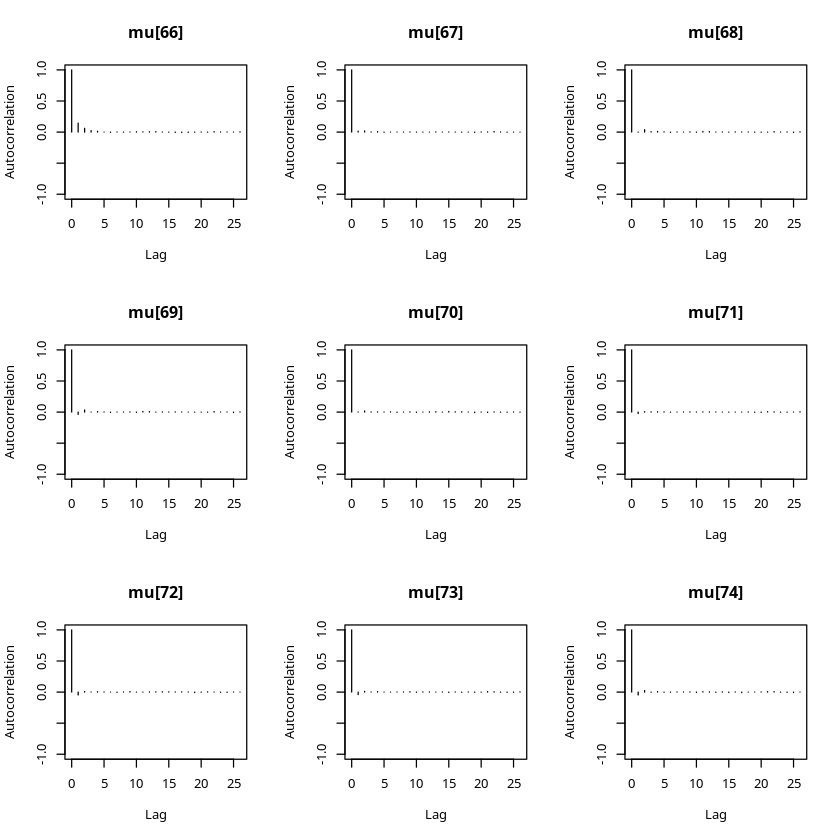

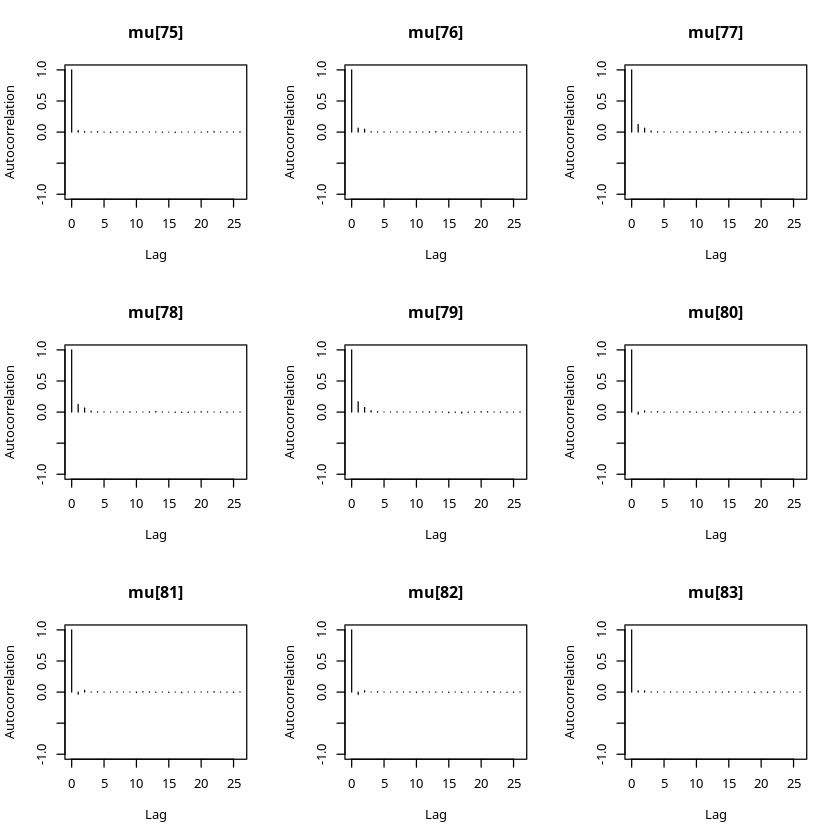

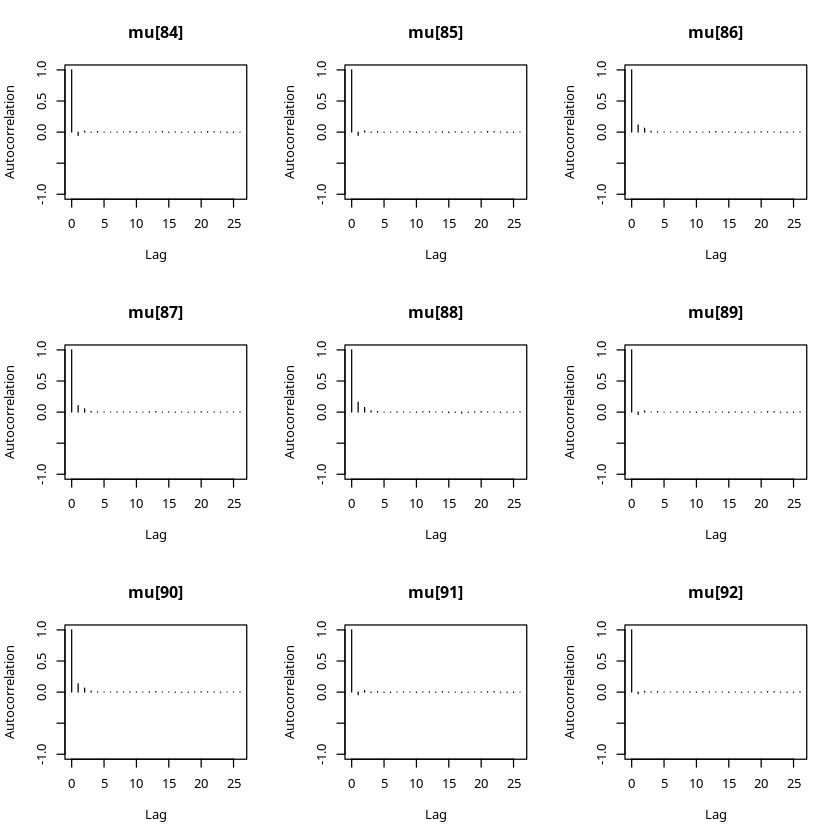

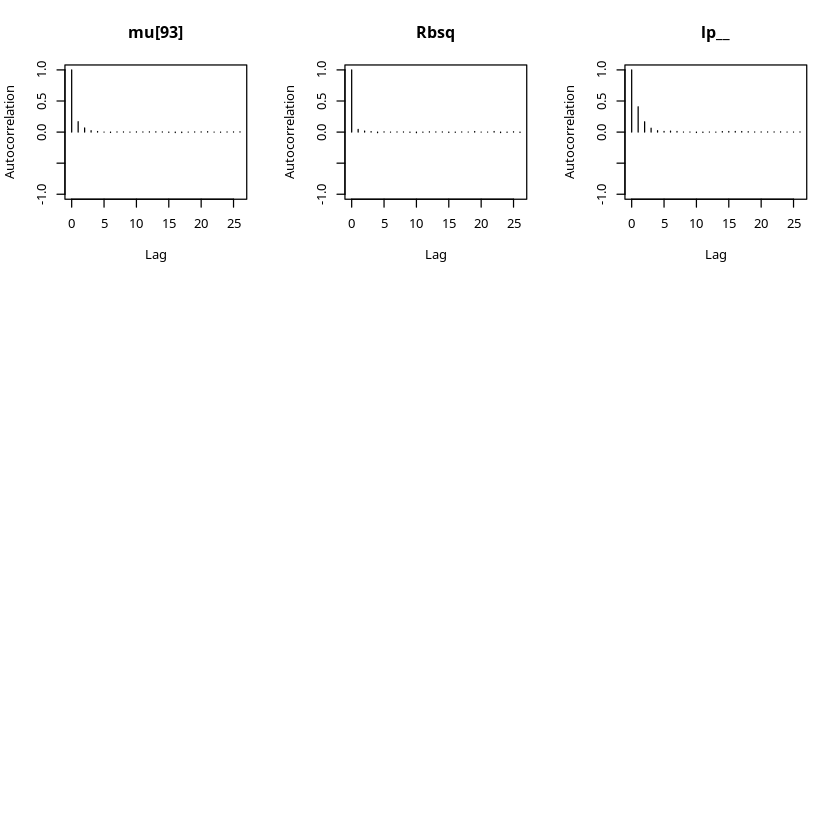

In [30]:
autocorr.plot(stan2coda3(fit2))

## Model 3: Conservative Zellner's g-prior $c^2=1000$

In [31]:
X = cbind(1,df$Sex, df$Educ, df$Exper, df$Time)

In [32]:
# make list stan data and specify the precision:
stan_dat <- list(n = n, y = df$BegSal,
                X = X, mu0 = c(0, 0, 0, 0, 0), V = solve(crossprod(X)), 
                I = diag(n), csq = 1000, v = v)

In [33]:
# fit model using stan with 4 chains
fit3 <- stan(model_code = stanmod, data = stan_dat, 
            iter = 100000, chains = 4)



SAMPLING FOR MODEL '5a2f02ff087d39001b6d13ac91e61ad3' NOW (CHAIN 1).

Chain 1, Iteration:     1 / 100000 [  0%]  (Warmup)
Chain 1, Iteration: 10000 / 100000 [ 10%]  (Warmup)
Chain 1, Iteration: 20000 / 100000 [ 20%]  (Warmup)
Chain 1, Iteration: 30000 / 100000 [ 30%]  (Warmup)
Chain 1, Iteration: 40000 / 100000 [ 40%]  (Warmup)
Chain 1, Iteration: 50000 / 100000 [ 50%]  (Warmup)
Chain 1, Iteration: 50001 / 100000 [ 50%]  (Sampling)
Chain 1, Iteration: 60000 / 100000 [ 60%]  (Sampling)
Chain 1, Iteration: 70000 / 100000 [ 70%]  (Sampling)
Chain 1, Iteration: 80000 / 100000 [ 80%]  (Sampling)
Chain 1, Iteration: 90000 / 100000 [ 90%]  (Sampling)
Chain 1, Iteration: 100000 / 100000 [100%]  (Sampling)
 Elapsed Time: 21.2422 seconds (Warm-up)
               25.8897 seconds (Sampling)
               47.1319 seconds (Total)



The following numerical problems occurred the indicated number of times on chain 1
                                                                                                     count
Exception thrown at line 27: multi_normal_log: Covariance matrix is not symmetric. Covariance matrix    19
When a numerical problem occurs, the Hamiltonian proposal gets rejected.
See http://mc-stan.org/misc/warnings.html#exception-hamiltonian-proposal-rejected
If the number in the 'count' column is small, there is no need to ask about this message on stan-users.



SAMPLING FOR MODEL '5a2f02ff087d39001b6d13ac91e61ad3' NOW (CHAIN 2).

Chain 2, Iteration:     1 / 100000 [  0%]  (Warmup)
Chain 2, Iteration: 10000 / 100000 [ 10%]  (Warmup)
Chain 2, Iteration: 20000 / 100000 [ 20%]  (Warmup)
Chain 2, Iteration: 30000 / 100000 [ 30%]  (Warmup)
Chain 2, Iteration: 40000 / 100000 [ 40%]  (Warmup)
Chain 2, Iteration: 50000 / 100000 [ 50%]  (Warmup)
Chain 2, Iteration: 50001 / 100000 [ 50%]  (Sampling)
Chain 2, Iteration: 60000 / 100000 [ 60%]  (Sampling)
Chain 2, Iteration: 70000 / 100000 [ 70%]  (Sampling)
Chain 2, Iteration: 80000 / 100000 [ 80%]  (Sampling)
Chain 2, Iteration: 90000 / 100000 [ 90%]  (Sampling)
Chain 2, Iteration: 100000 / 100000 [100%]  (Sampling)
 Elapsed Time: 21.5509 seconds (Warm-up)
               23.1444 seconds (Sampling)
               44.6953 seconds (Total)



The following numerical problems occurred the indicated number of times on chain 2
                                                                                                     count
Exception thrown at line 27: multi_normal_log: Covariance matrix is not symmetric. Covariance matrix    18
When a numerical problem occurs, the Hamiltonian proposal gets rejected.
See http://mc-stan.org/misc/warnings.html#exception-hamiltonian-proposal-rejected
If the number in the 'count' column is small, there is no need to ask about this message on stan-users.



SAMPLING FOR MODEL '5a2f02ff087d39001b6d13ac91e61ad3' NOW (CHAIN 3).

Chain 3, Iteration:     1 / 100000 [  0%]  (Warmup)
Chain 3, Iteration: 10000 / 100000 [ 10%]  (Warmup)
Chain 3, Iteration: 20000 / 100000 [ 20%]  (Warmup)
Chain 3, Iteration: 30000 / 100000 [ 30%]  (Warmup)
Chain 3, Iteration: 40000 / 100000 [ 40%]  (Warmup)
Chain 3, Iteration: 50000 / 100000 [ 50%]  (Warmup)
Chain 3, Iteration: 50001 / 100000 [ 50%]  (Sampling)
Chain 3, Iteration: 60000 / 100000 [ 60%]  (Sampling)
Chain 3, Iteration: 70000 / 100000 [ 70%]  (Sampling)
Chain 3, Iteration: 80000 / 100000 [ 80%]  (Sampling)
Chain 3, Iteration: 90000 / 100000 [ 90%]  (Sampling)
Chain 3, Iteration: 100000 / 100000 [100%]  (Sampling)
 Elapsed Time: 20.8994 seconds (Warm-up)
               25.0452 seconds (Sampling)
               45.9446 seconds (Total)



The following numerical problems occurred the indicated number of times on chain 3
                                                                                                     count
Exception thrown at line 27: multi_normal_log: Covariance matrix is not symmetric. Covariance matrix    21
When a numerical problem occurs, the Hamiltonian proposal gets rejected.
See http://mc-stan.org/misc/warnings.html#exception-hamiltonian-proposal-rejected
If the number in the 'count' column is small, there is no need to ask about this message on stan-users.



SAMPLING FOR MODEL '5a2f02ff087d39001b6d13ac91e61ad3' NOW (CHAIN 4).

Chain 4, Iteration:     1 / 100000 [  0%]  (Warmup)
Chain 4, Iteration: 10000 / 100000 [ 10%]  (Warmup)
Chain 4, Iteration: 20000 / 100000 [ 20%]  (Warmup)
Chain 4, Iteration: 30000 / 100000 [ 30%]  (Warmup)
Chain 4, Iteration: 40000 / 100000 [ 40%]  (Warmup)
Chain 4, Iteration: 50000 / 100000 [ 50%]  (Warmup)
Chain 4, Iteration: 50001 / 100000 [ 50%]  (Sampling)
Chain 4, Iteration: 60000 / 100000 [ 60%]  (Sampling)
Chain 4, Iteration: 70000 / 100000 [ 70%]  (Sampling)
Chain 4, Iteration: 80000 / 100000 [ 80%]  (Sampling)
Chain 4, Iteration: 90000 / 100000 [ 90%]  (Sampling)
Chain 4, Iteration: 100000 / 100000 [100%]  (Sampling)
 Elapsed Time: 21.9109 seconds (Warm-up)
               25.6987 seconds (Sampling)
               47.6096 seconds (Total)



The following numerical problems occurred the indicated number of times on chain 4
                                                                                                     count
Exception thrown at line 27: multi_normal_log: Covariance matrix is not symmetric. Covariance matrix    18
When a numerical problem occurs, the Hamiltonian proposal gets rejected.
See http://mc-stan.org/misc/warnings.html#exception-hamiltonian-proposal-rejected
If the number in the 'count' column is small, there is no need to ask about this message on stan-users.


In [34]:
summary(fit3)$summary[1:7,]


,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
prec,3.659598569,1.276708e-03,0.5362434149,2.683027e+00,3.284865671,3.633293299,4.005243452,4.782212964,176417.2,0.9999942
beta[1],3.522357661,1.039082e-03,0.3414350365,2.851026e+00,3.293847714,3.522506090,3.751604213,4.191127208,107973.3,1.0000272
beta[2],0.721428447,3.017830e-04,0.1230771630,4.803642e-01,0.638884556,0.721393016,0.803606906,0.963877569,166328.1,0.9999940
beta[3],0.089974325,7.791634e-05,0.0257061455,3.950578e-02,0.072705518,0.089979483,0.107149862,0.140464381,108847.1,1.0000137
beta[4],0.001267389,1.361616e-06,0.0006089334,7.090803e-05,0.000857123,0.001266851,0.001677128,0.002463227,200000.0,1.0000103
beta[5],0.023405529,1.287210e-05,0.0053977158,1.279308e-02,0.019789991,0.023414037,0.027025187,0.033999444,175841.5,1.0000051
sigmasq,0.279251495,1.006963e-04,0.0418283420,2.091082e-01,0.249672713,0.275232390,0.304426452,0.372713351,172549.8,0.9999954


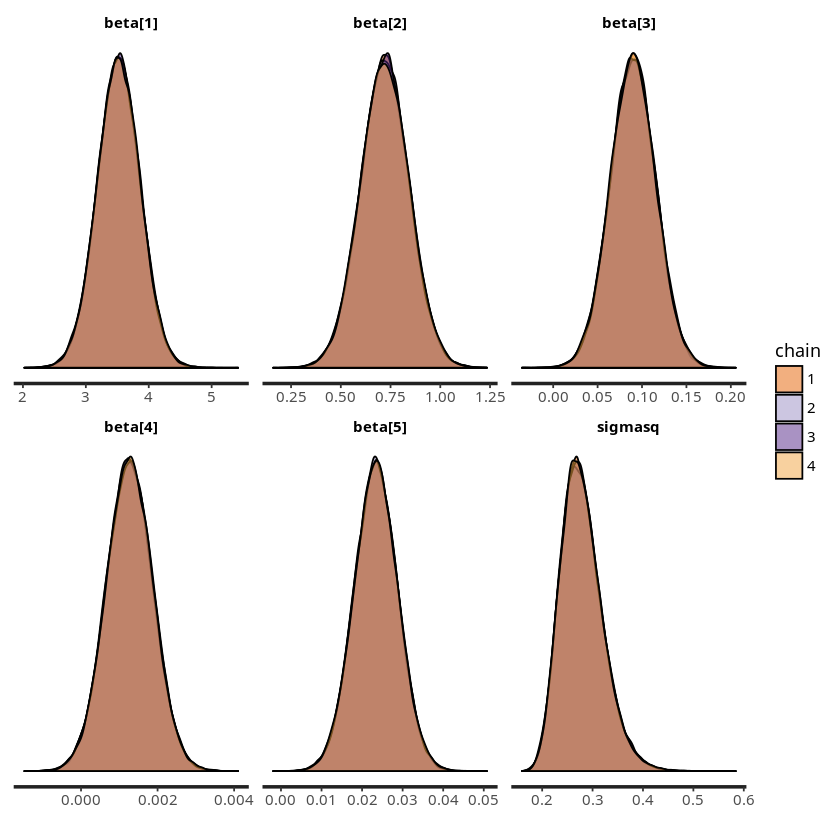

In [35]:
# plot of densities
stan_dens(fit3, par = c("beta", "sigmasq"), separate_chains = TRUE)


In [36]:
summary(fit3)$summary[1:7,"Rhat"]

prec   beta[1]   beta[2]   beta[3]   beta[4]   beta[5]   sigmasq 
0.9999942 1.0000272 0.9999940 1.0000137 1.0000103 1.0000051 0.9999954

In [37]:
# 95% central posterior intervals
summary(fit3)$summary[1:7,c("2.5%", "97.5%")]

,2.5%,97.5%
prec,2.683027e+00,4.782212964
beta[1],2.851026e+00,4.191127208
beta[2],4.803642e-01,0.963877569
beta[3],3.950578e-02,0.140464381
beta[4],7.090803e-05,0.002463227
beta[5],1.279308e-02,0.033999444
sigmasq,2.091082e-01,0.372713351


In [38]:
# posterior means
summary(fit3)$summary[1:7,"mean"]

prec     beta[1]     beta[2]     beta[3]     beta[4]     beta[5] 
3.659598569 3.522357661 0.721428447 0.089974325 0.001267389 0.023405529 
    sigmasq 
0.279251495

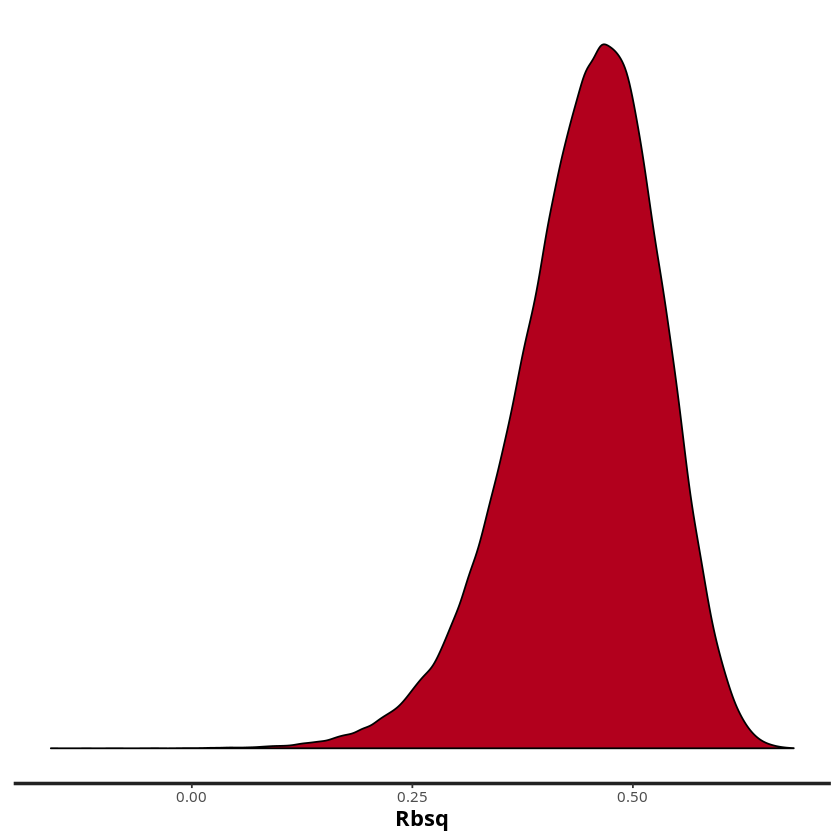

In [39]:
# distribution of Rb^2
stan_dens(fit3, "Rbsq")


In [40]:
#traceplot(fit3,par = c("beta", "sigmasq","prec"))


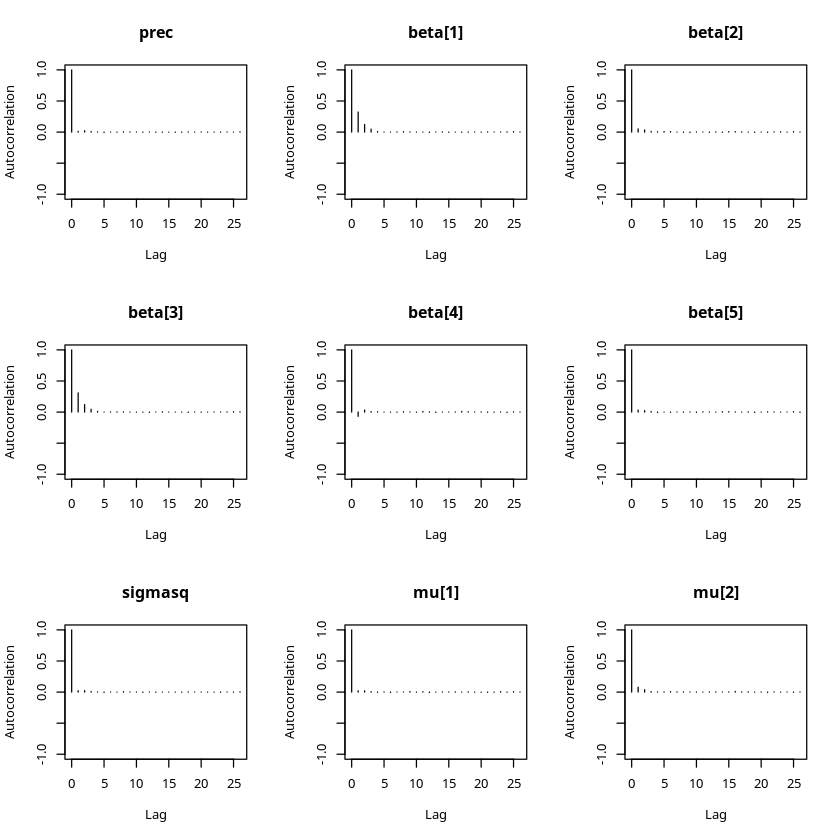

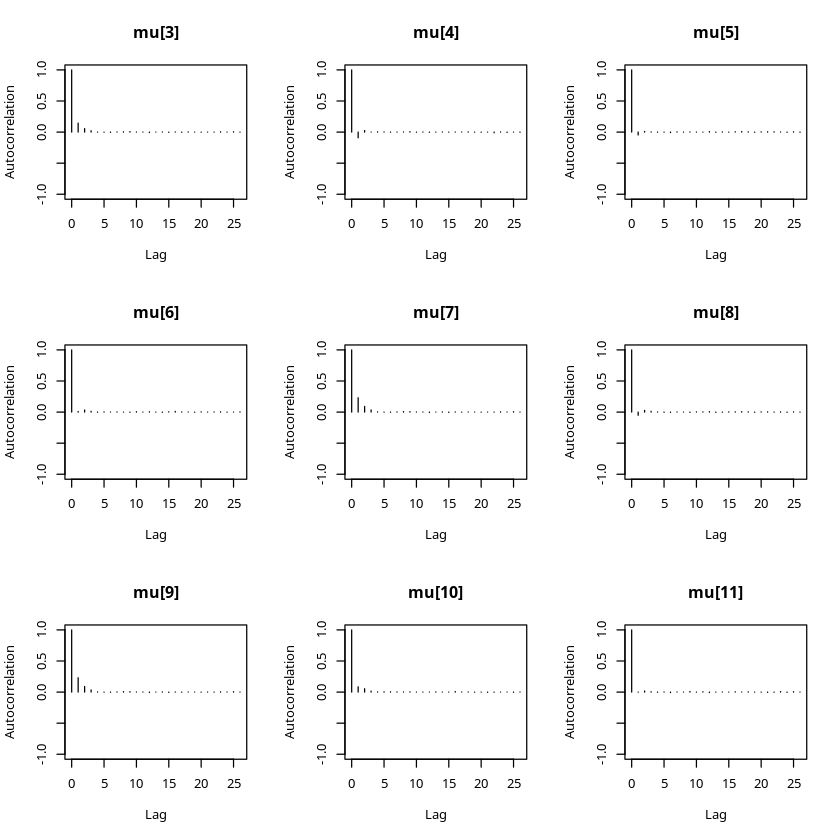

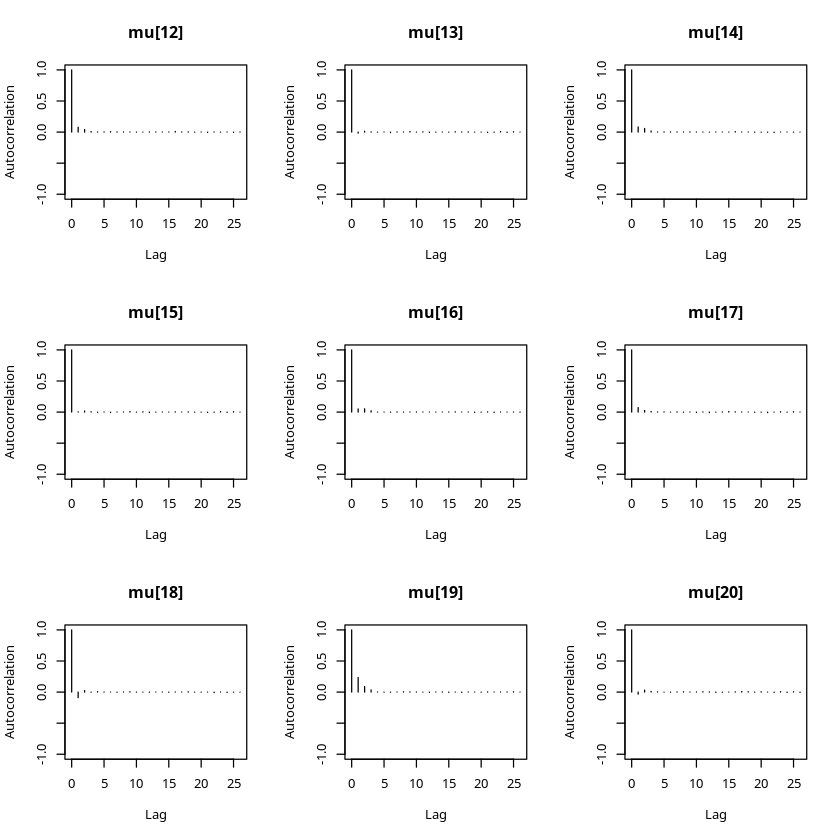

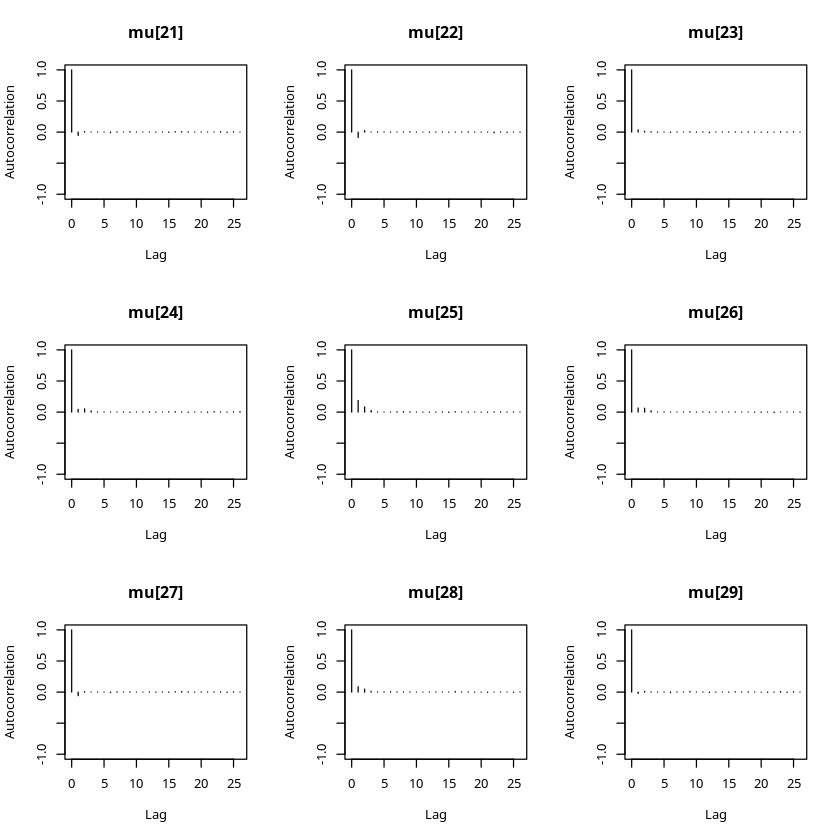

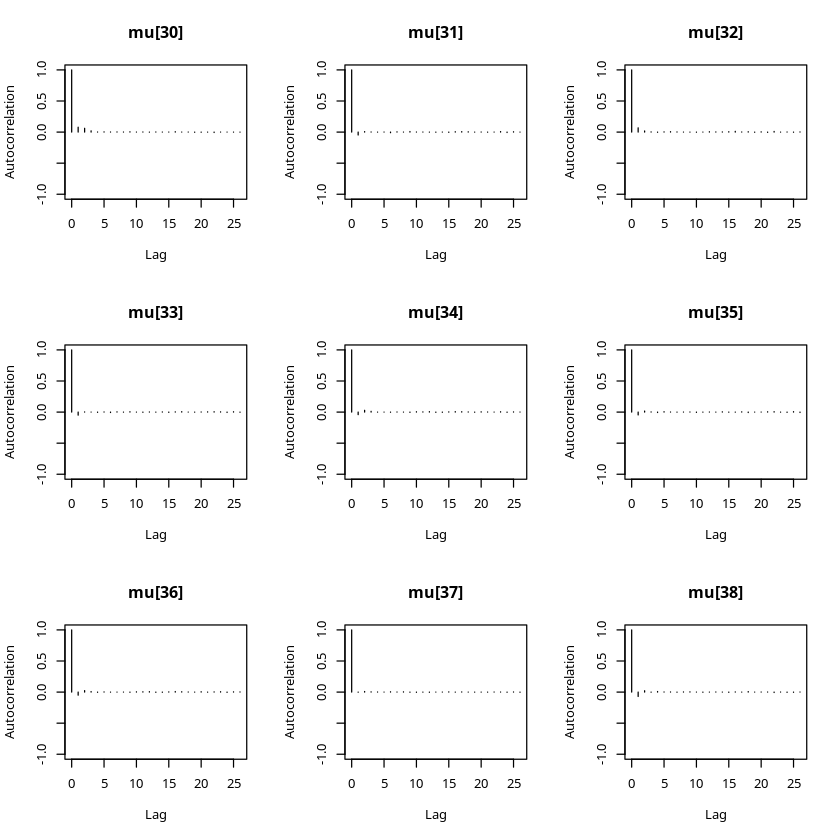

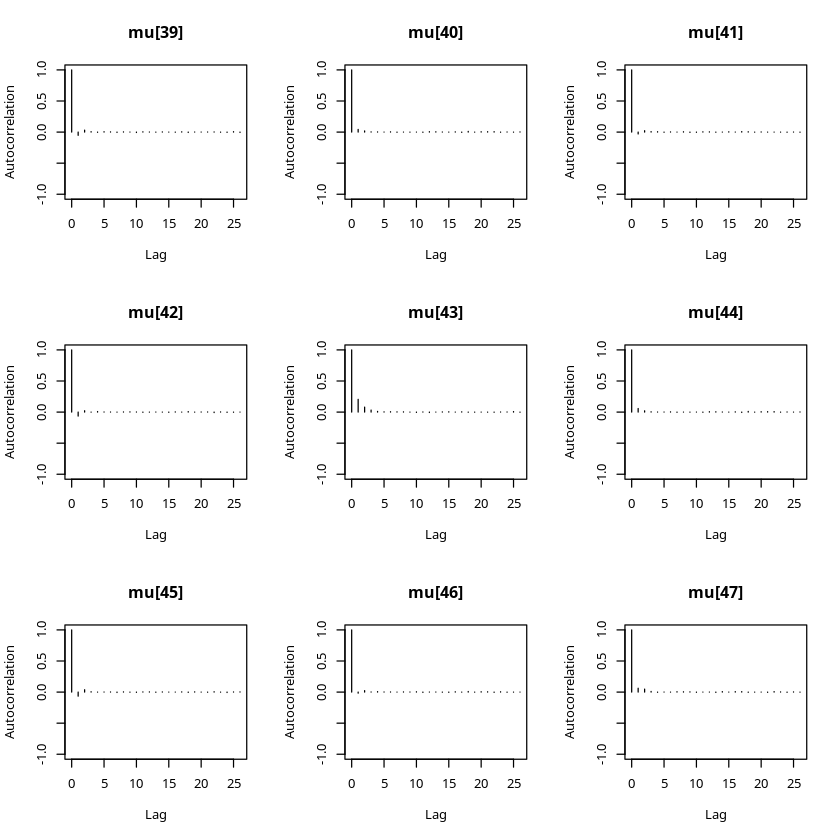

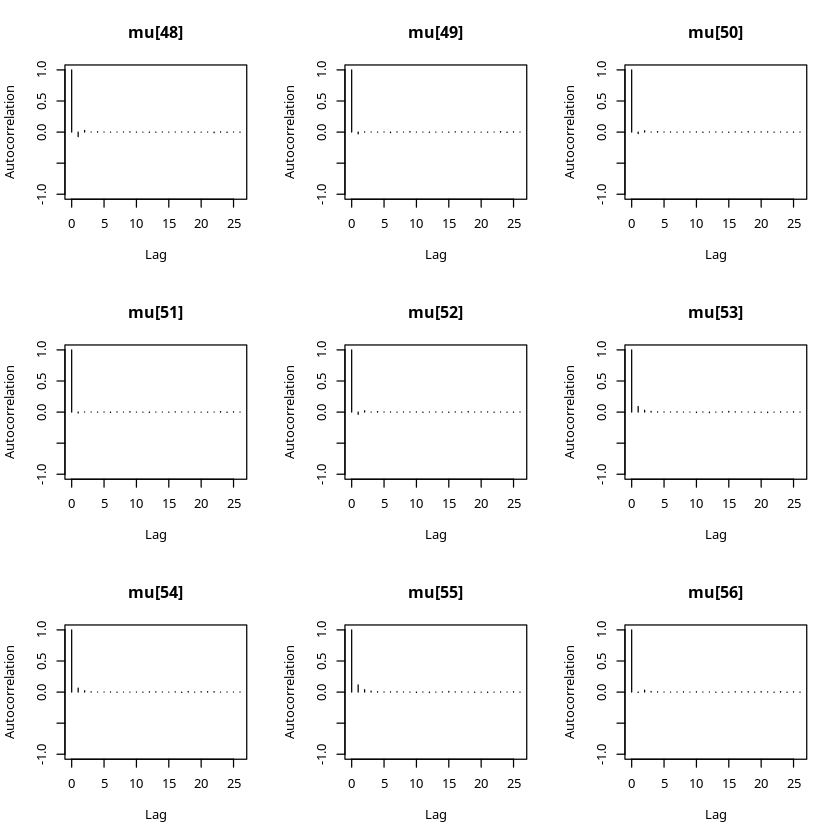

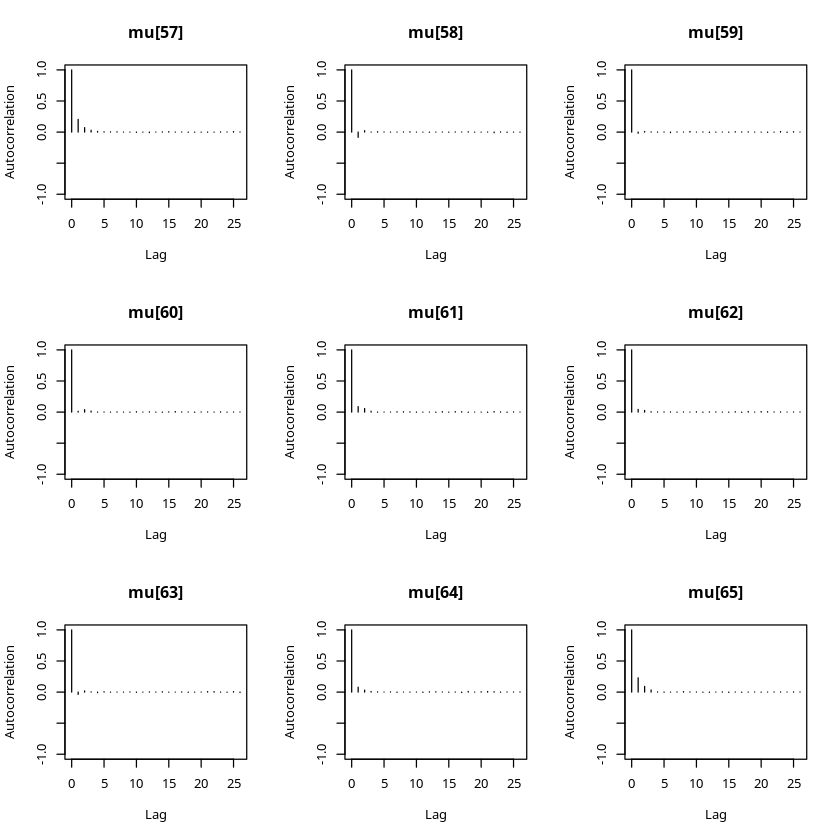

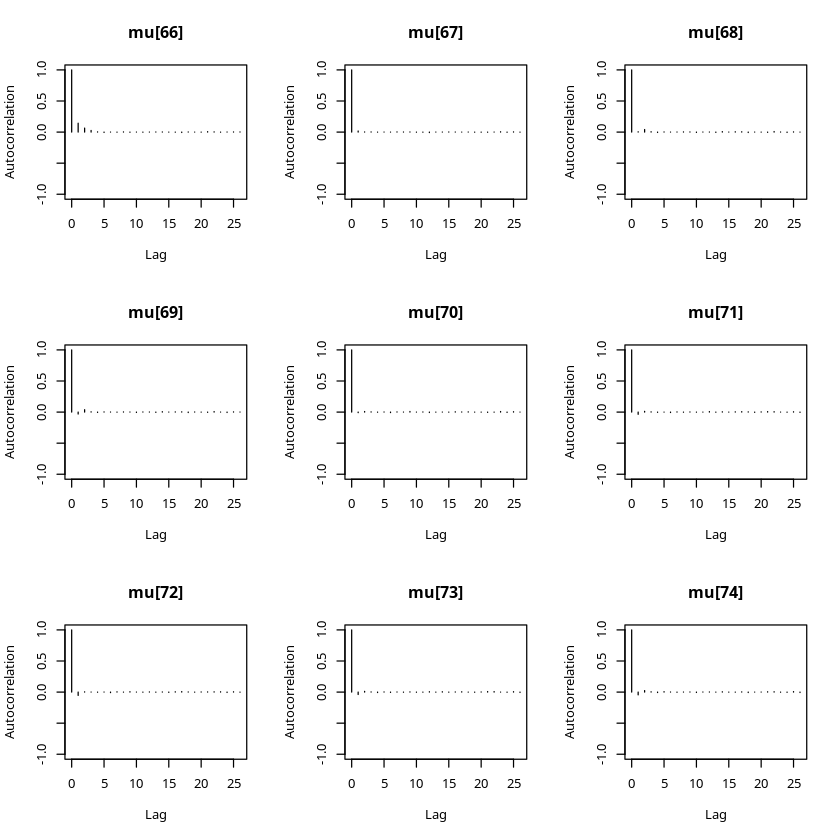

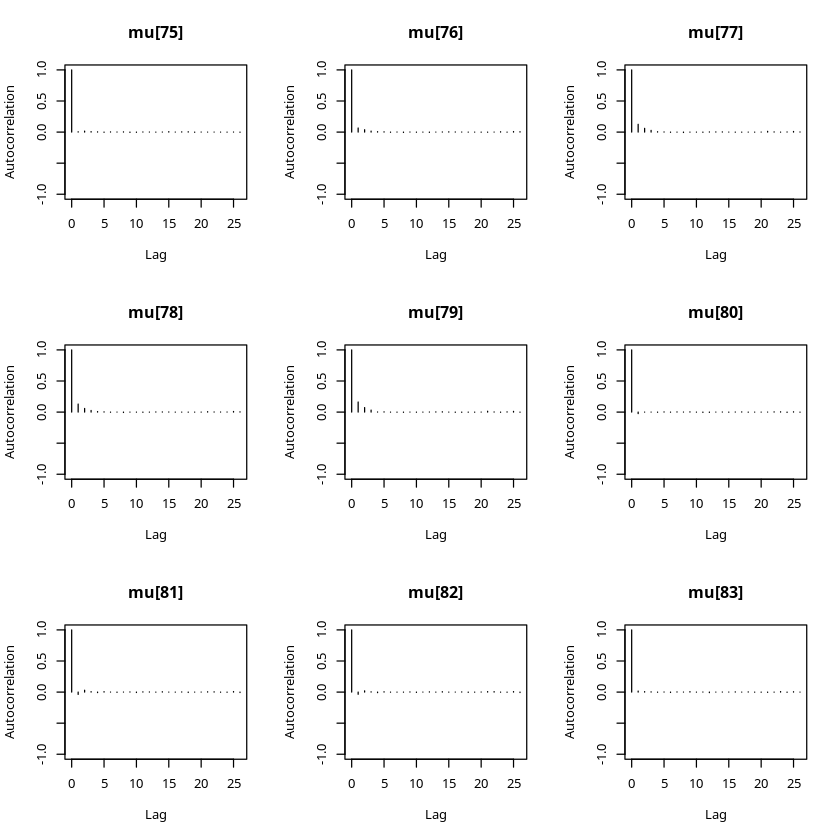

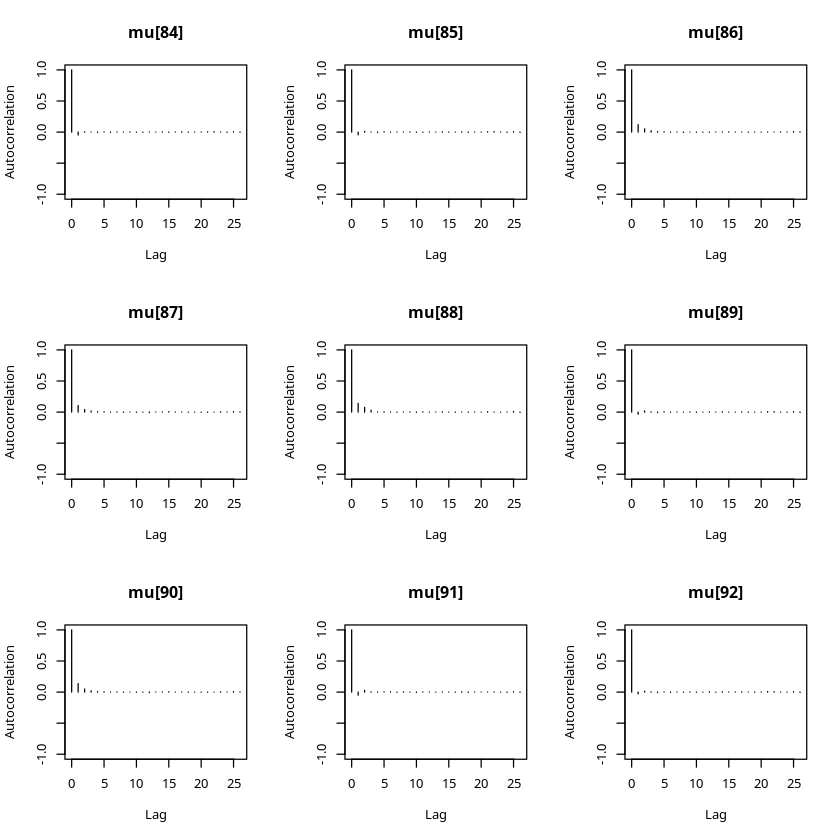

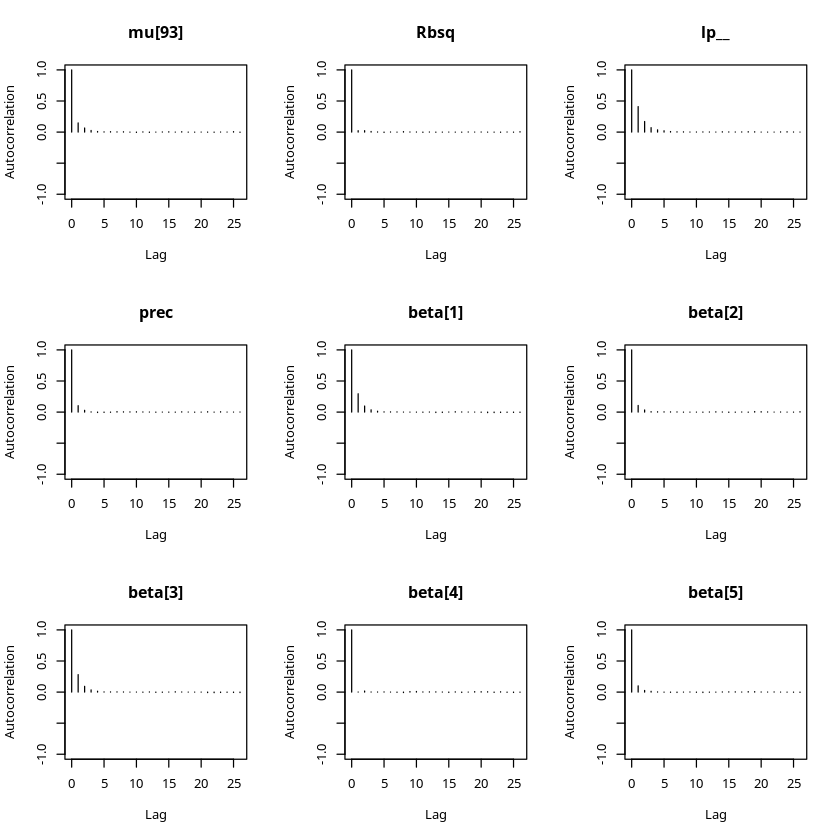

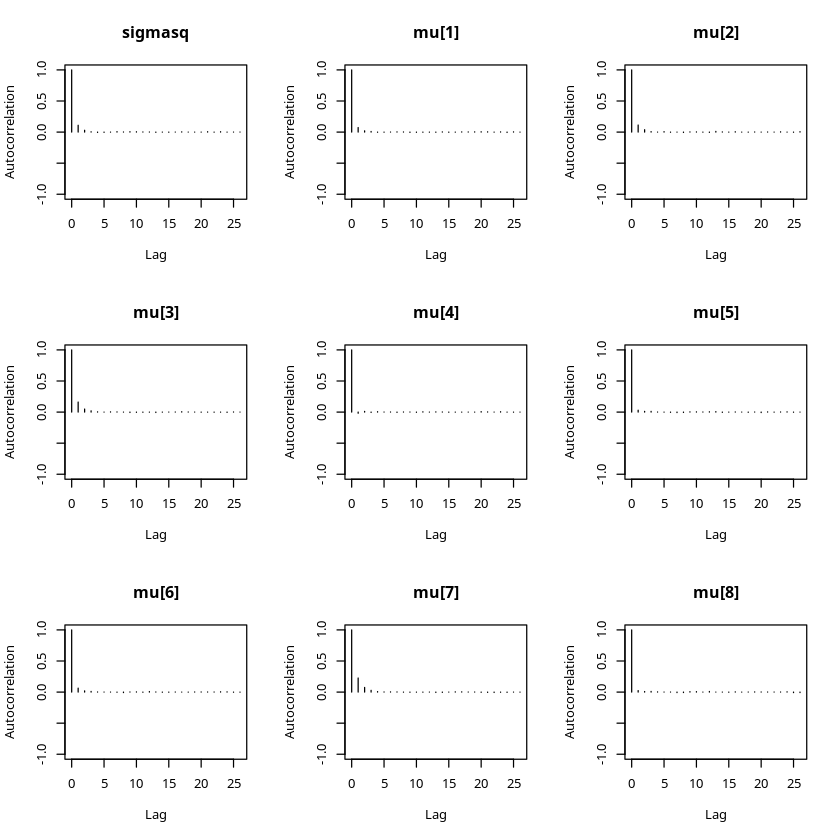

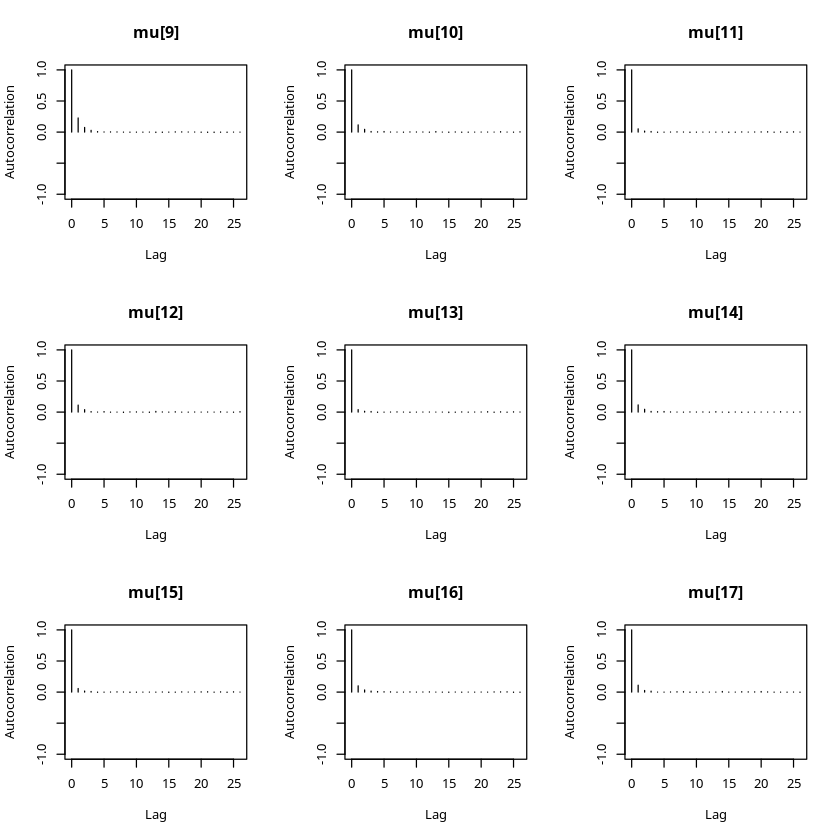

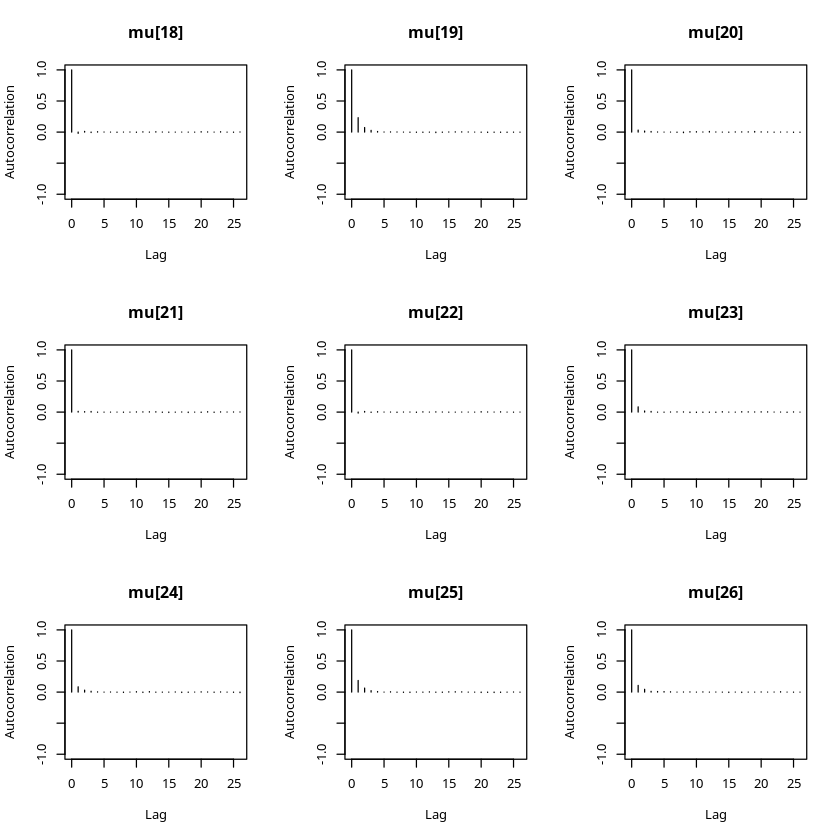

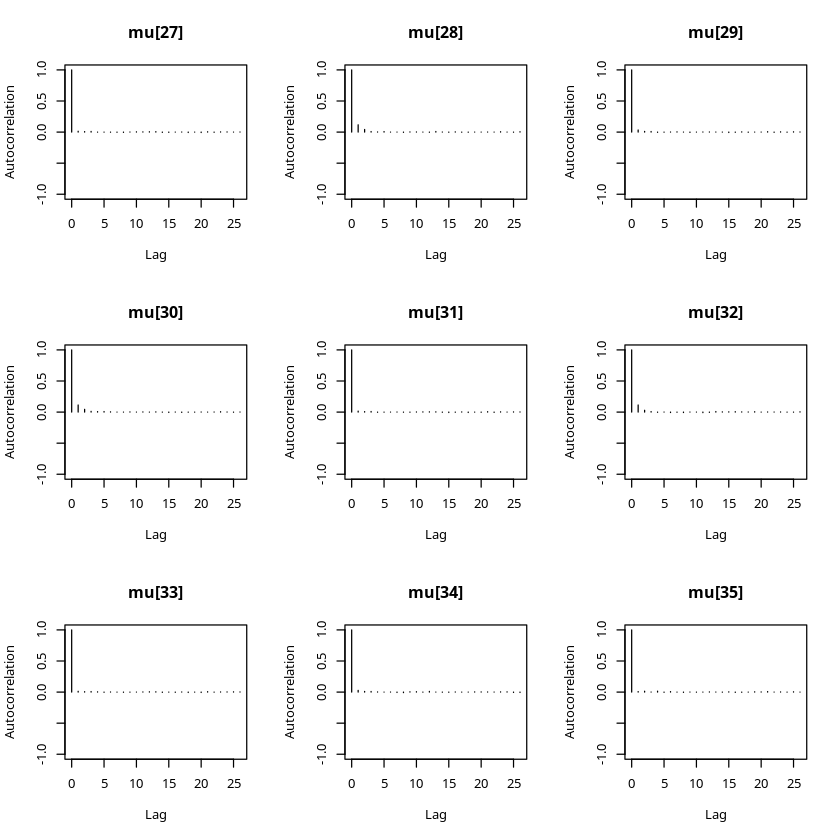

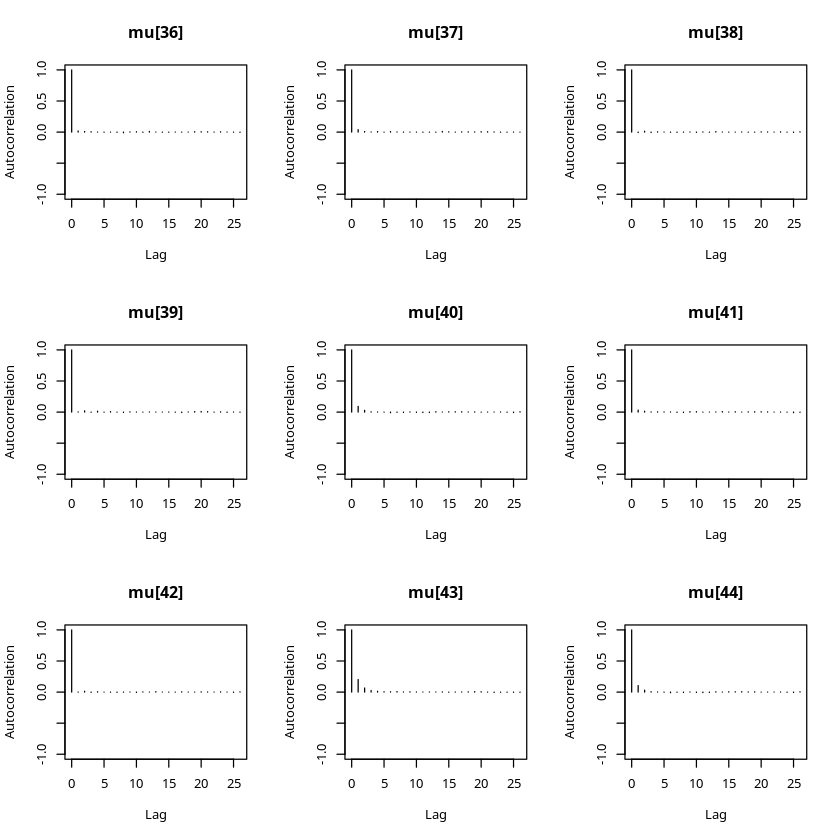

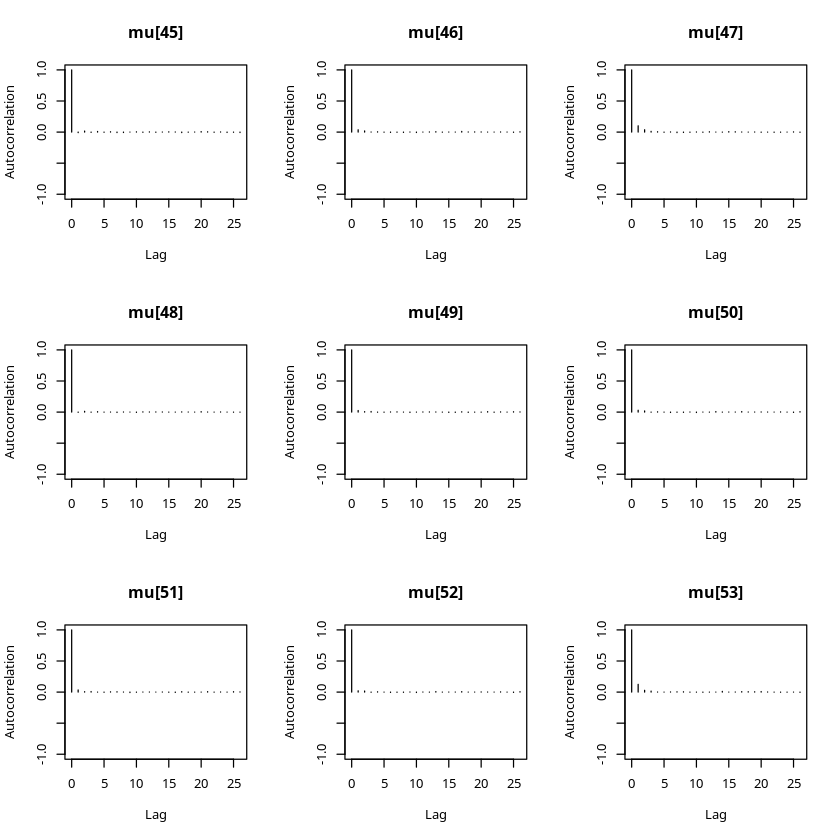

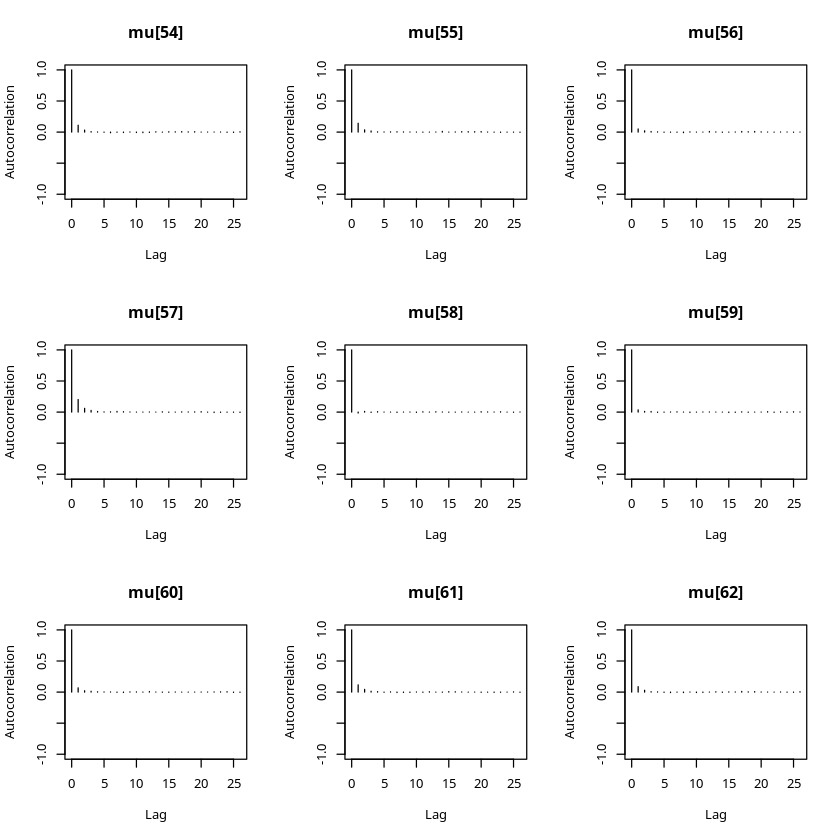

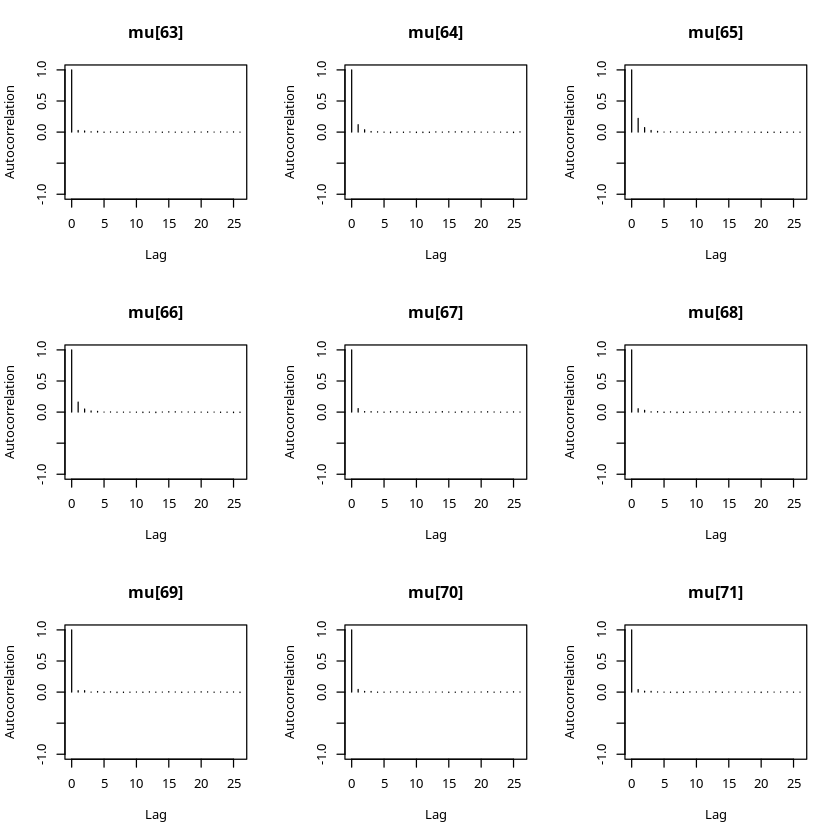

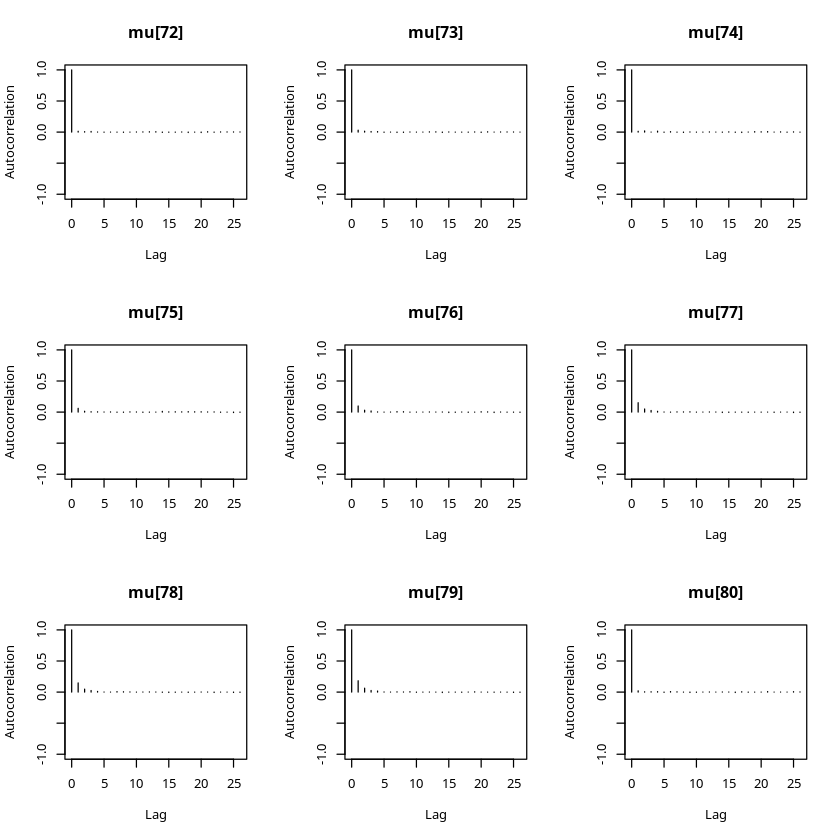

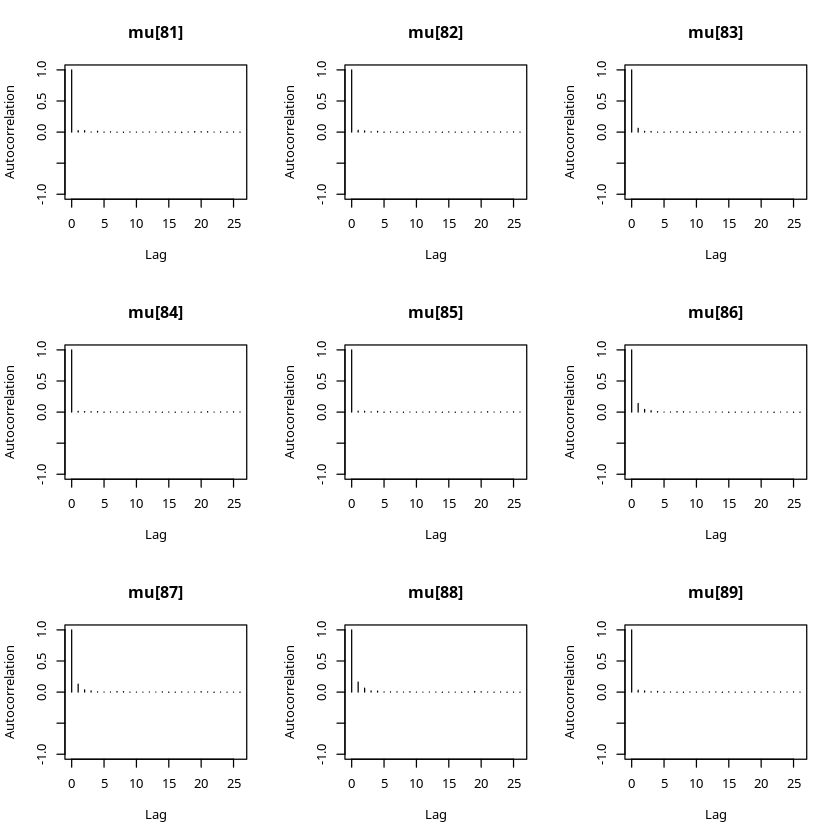

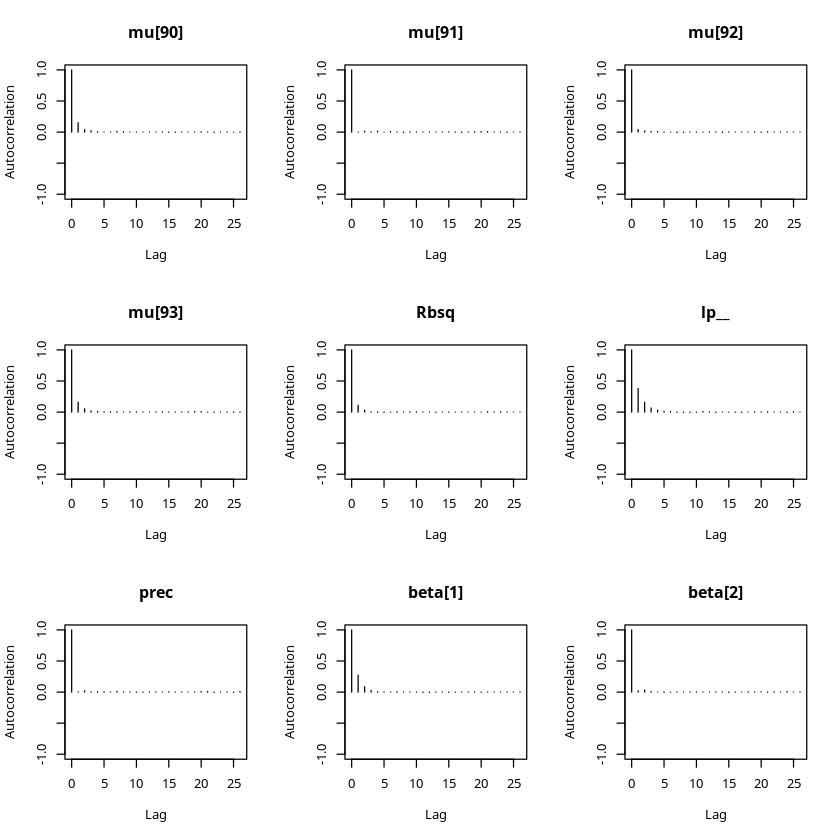

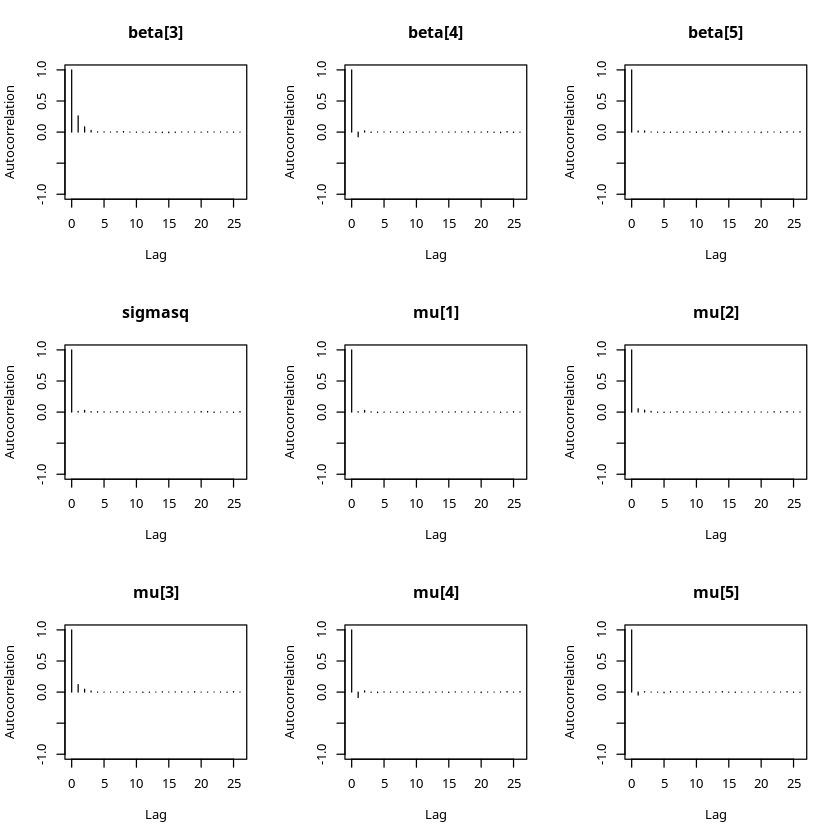

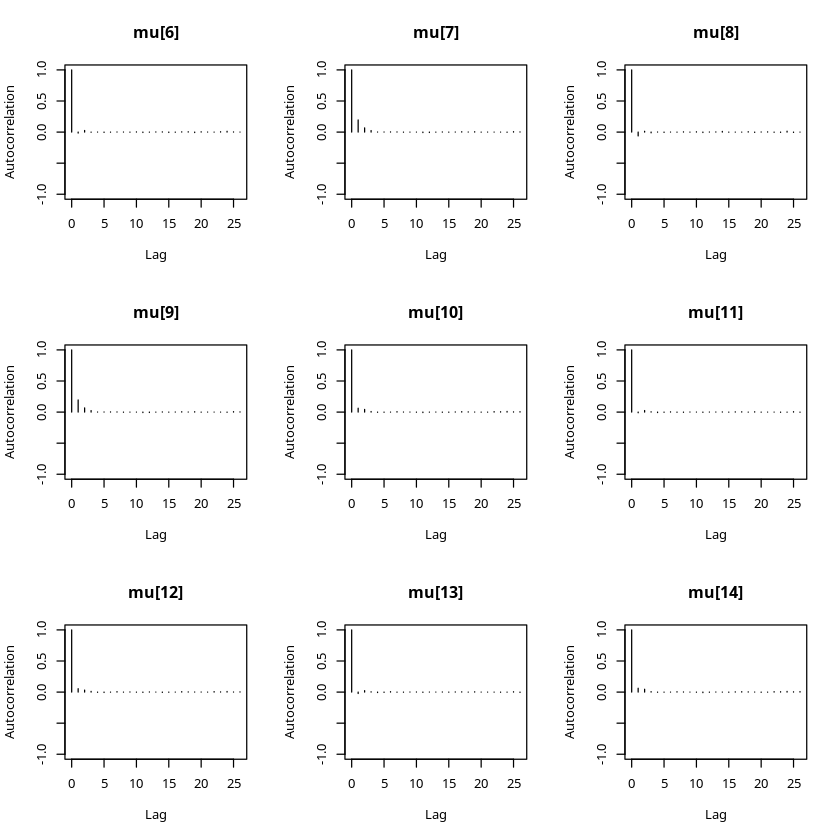

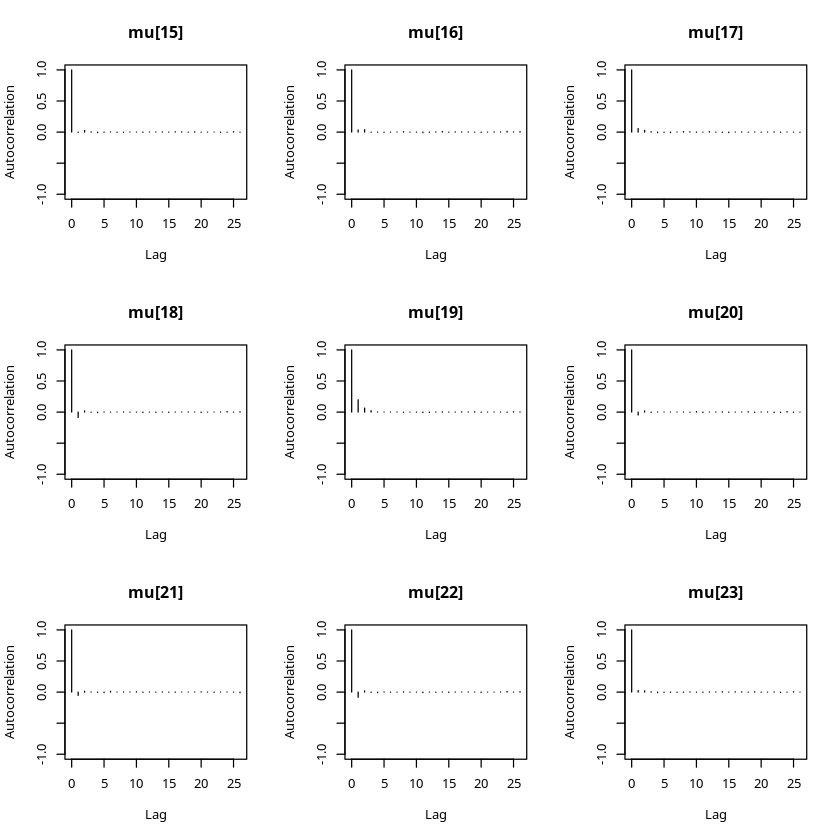

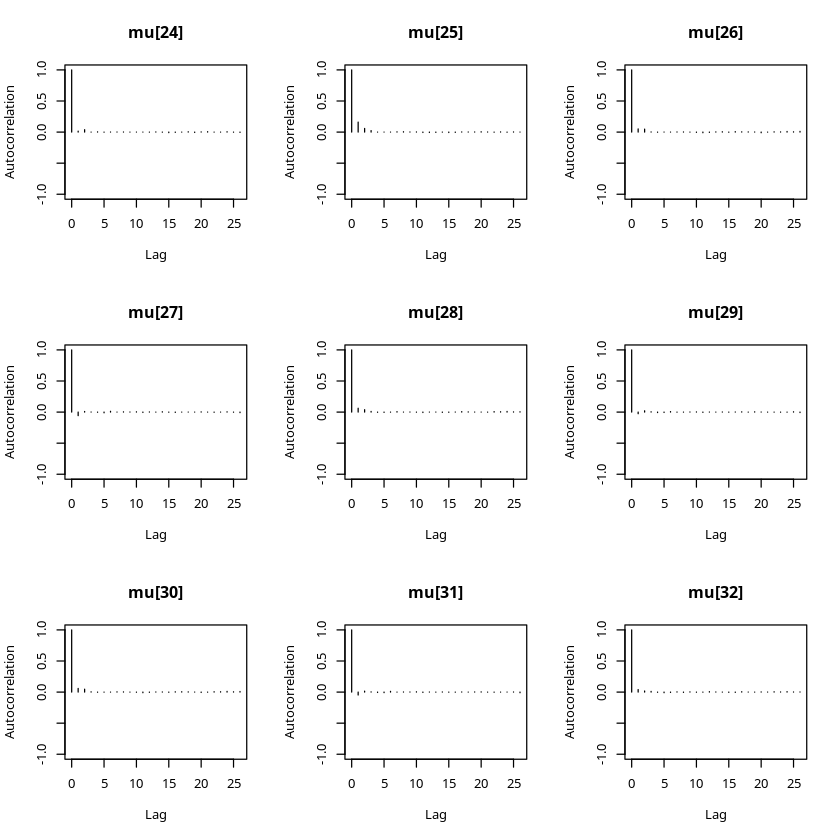

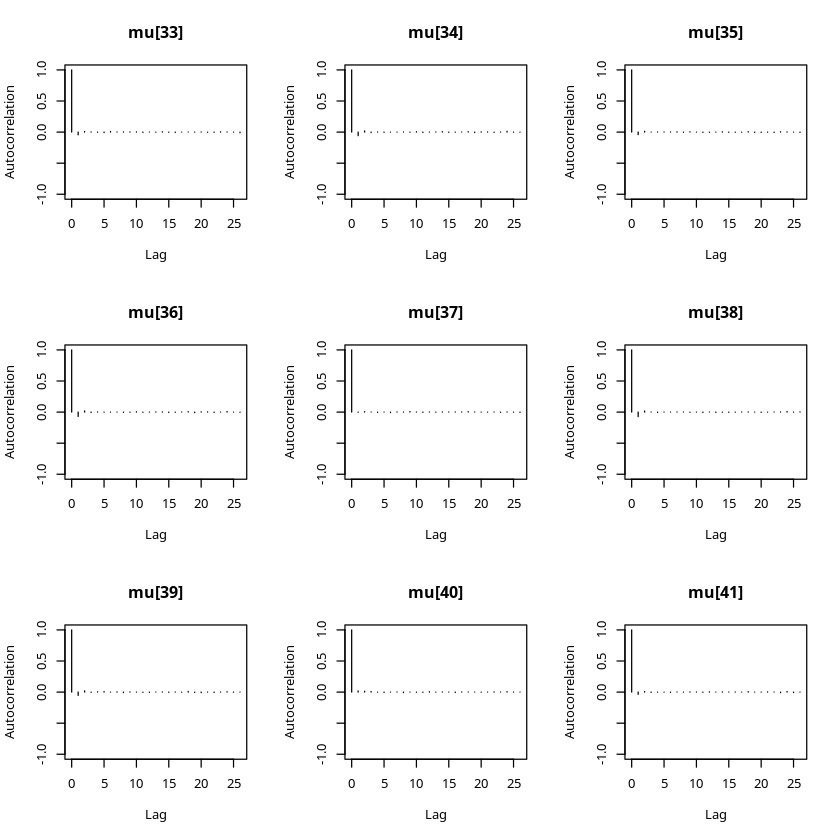

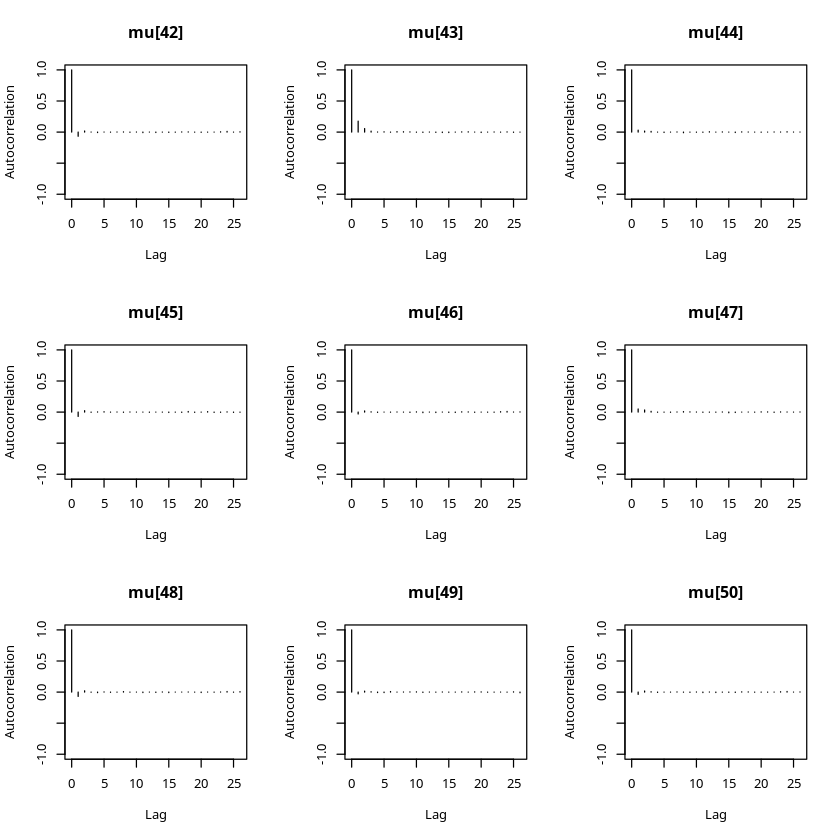

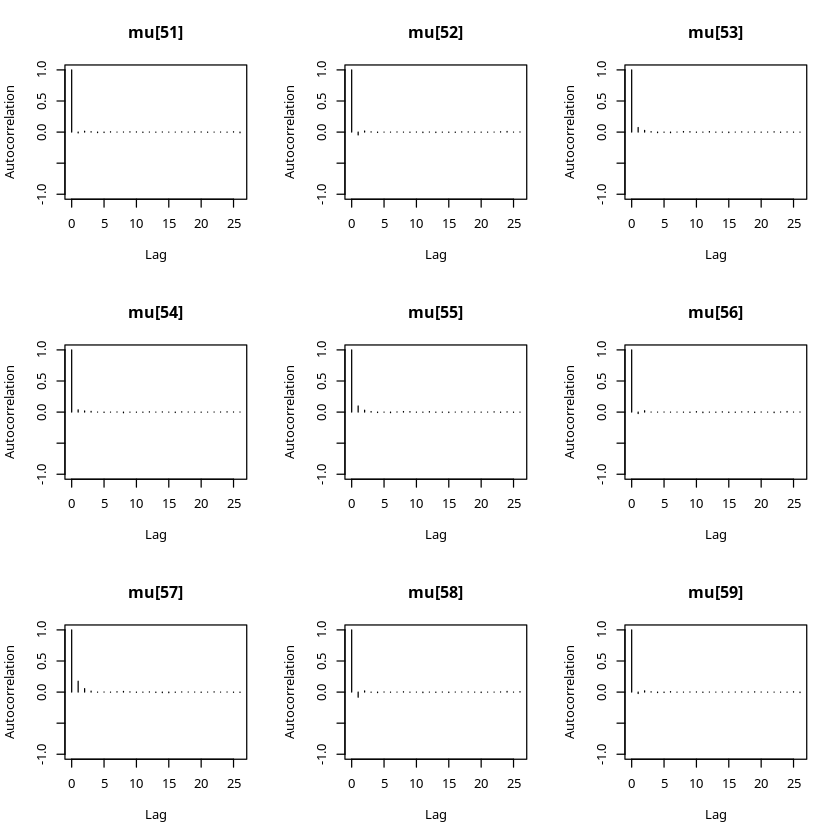

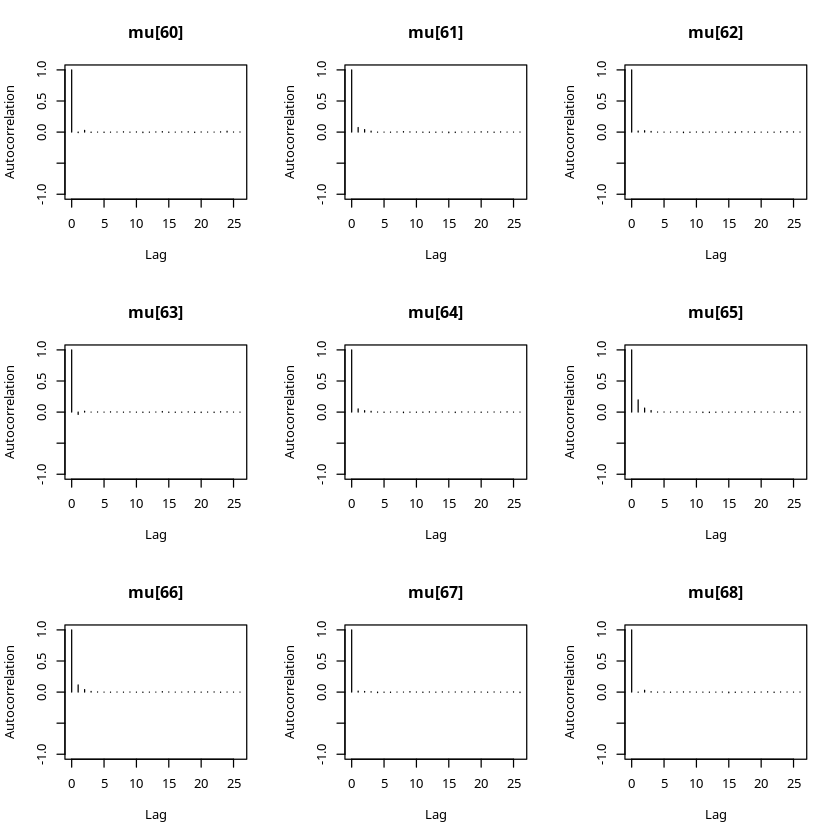

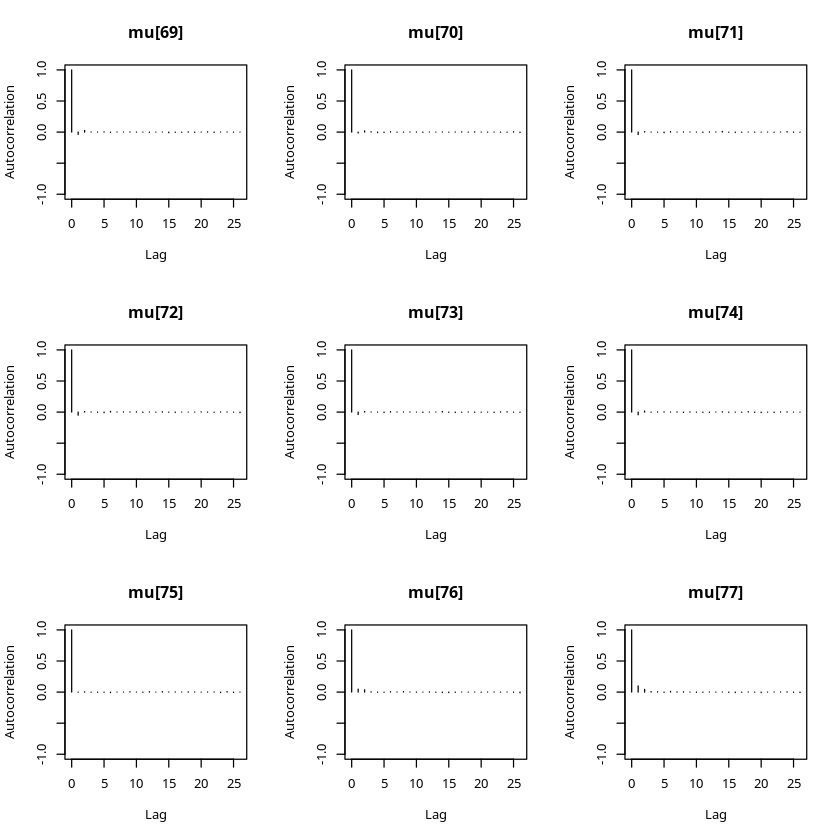

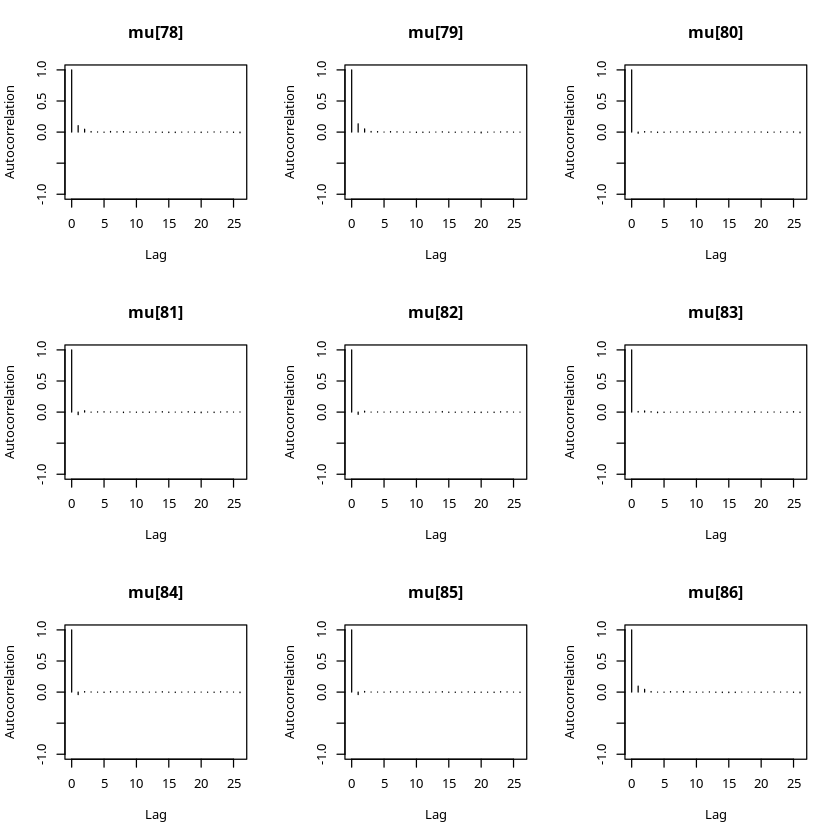

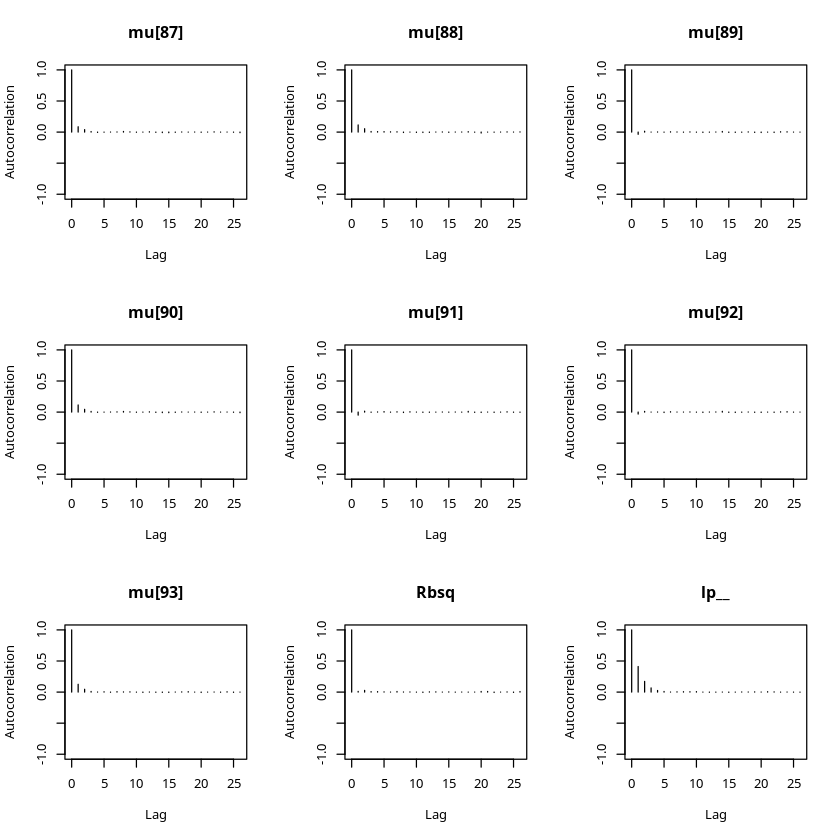

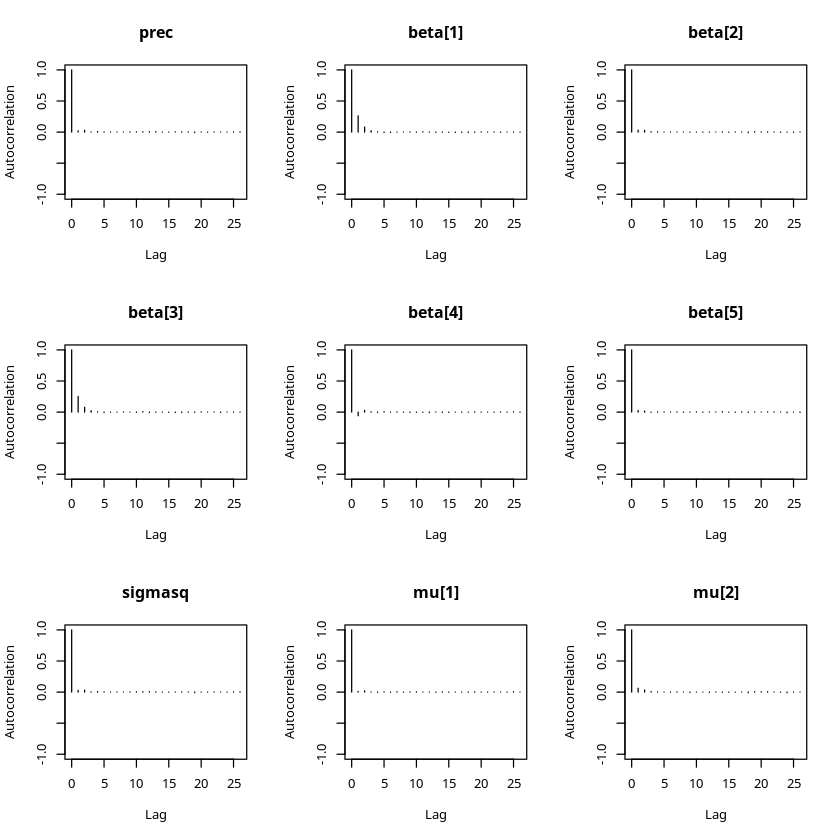

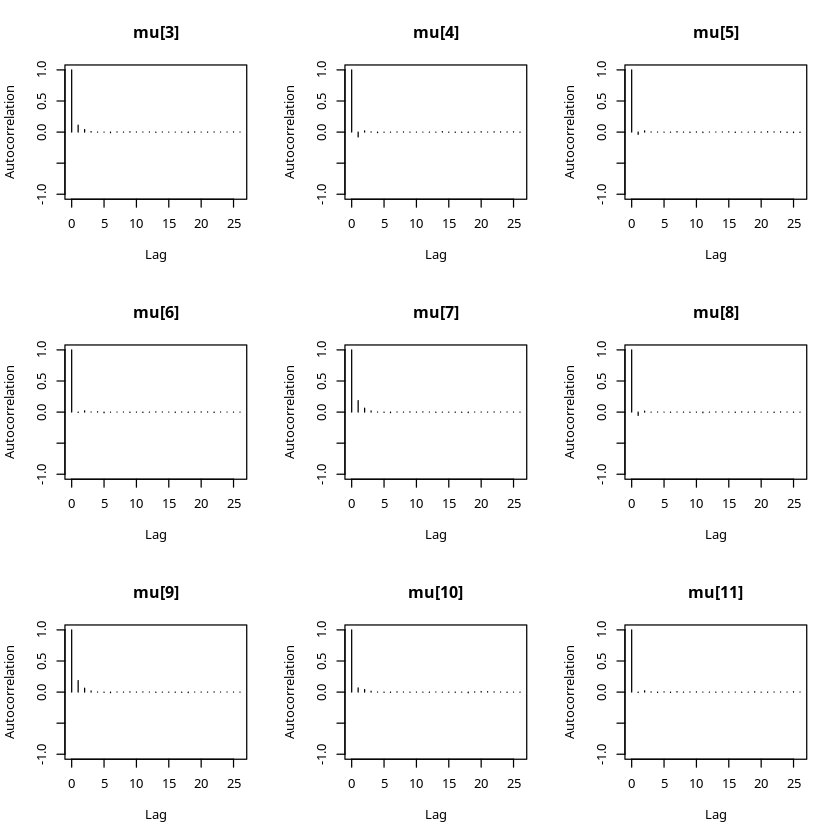

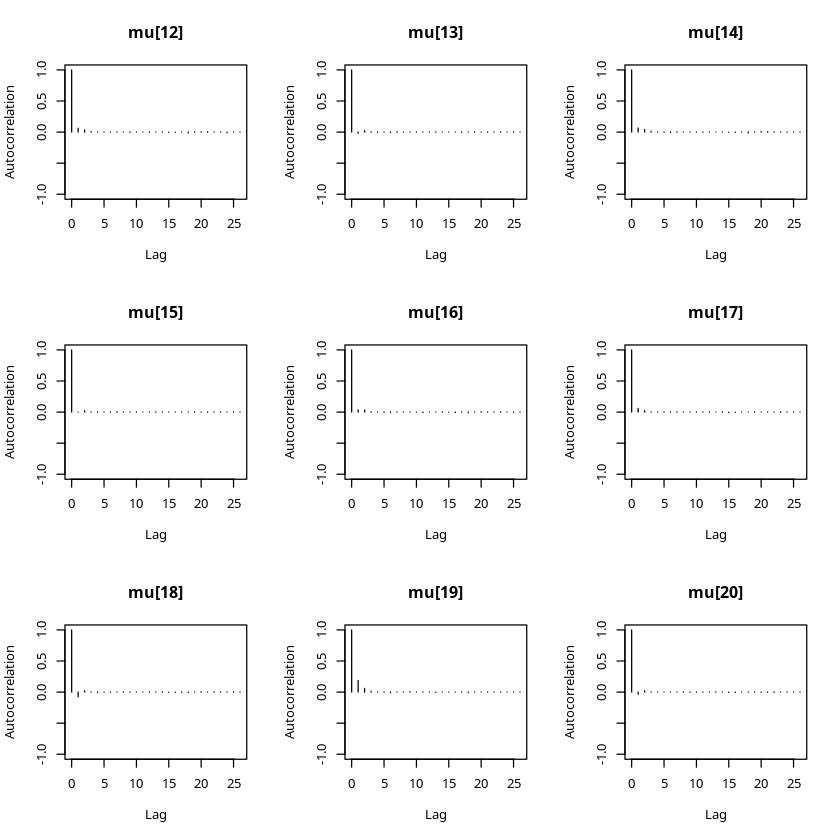

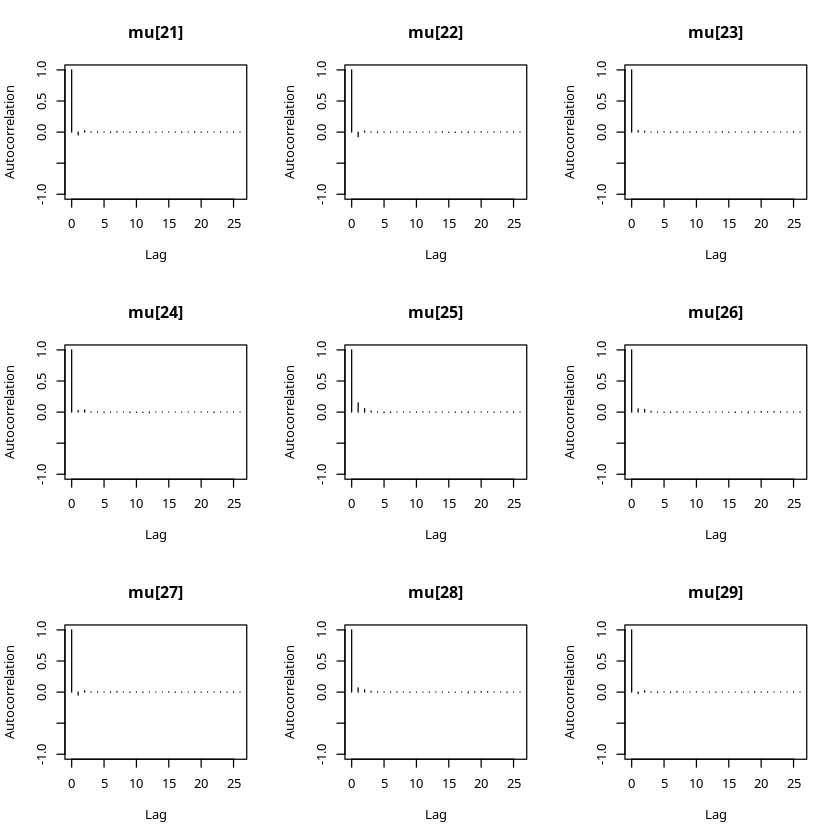

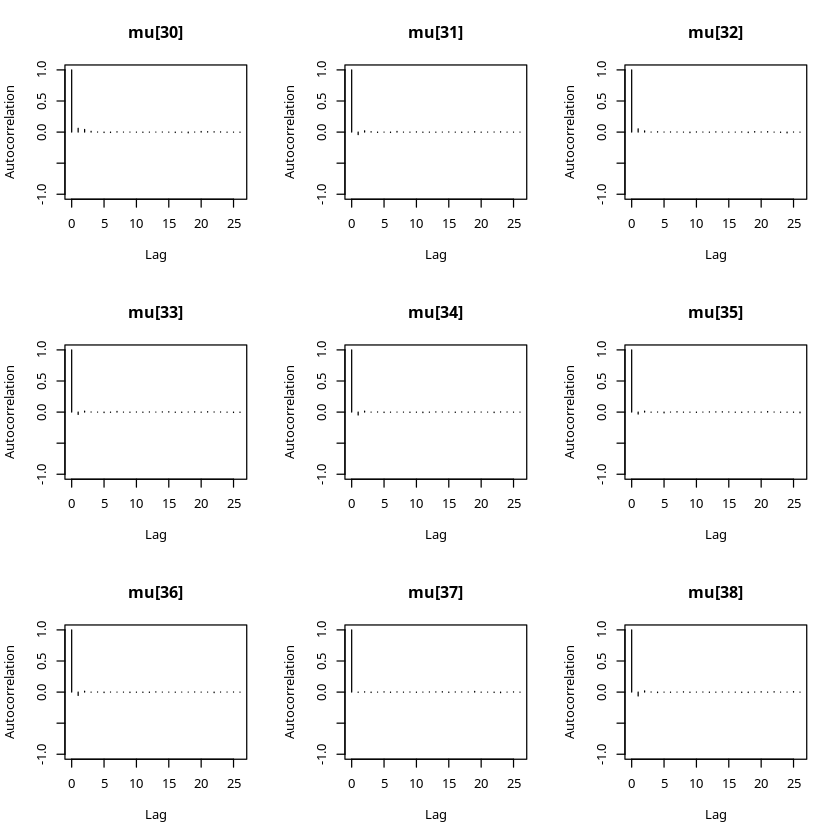

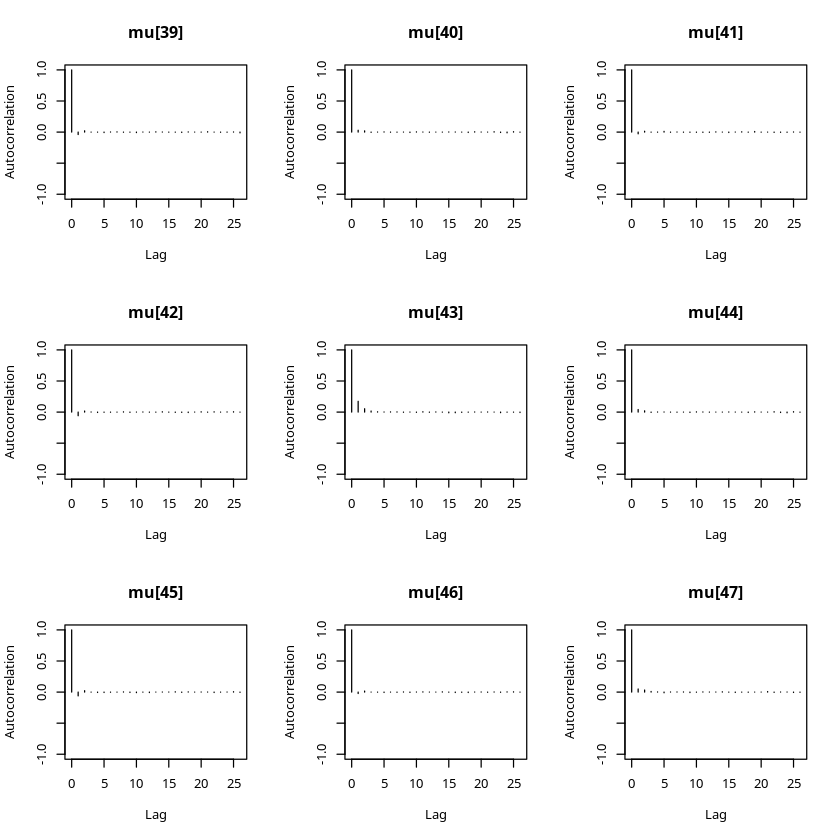

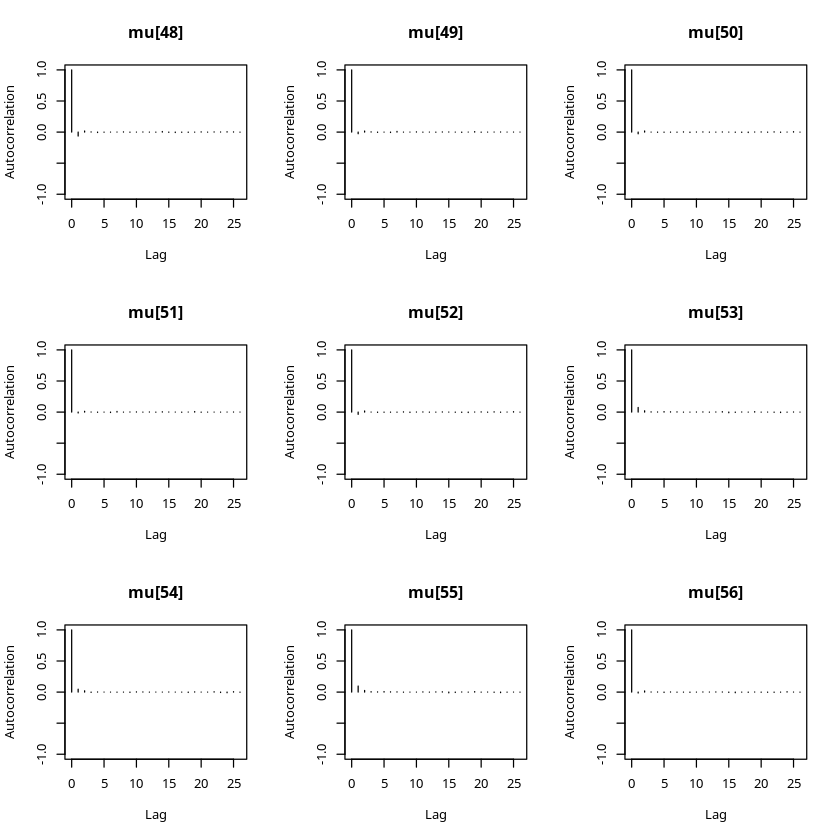

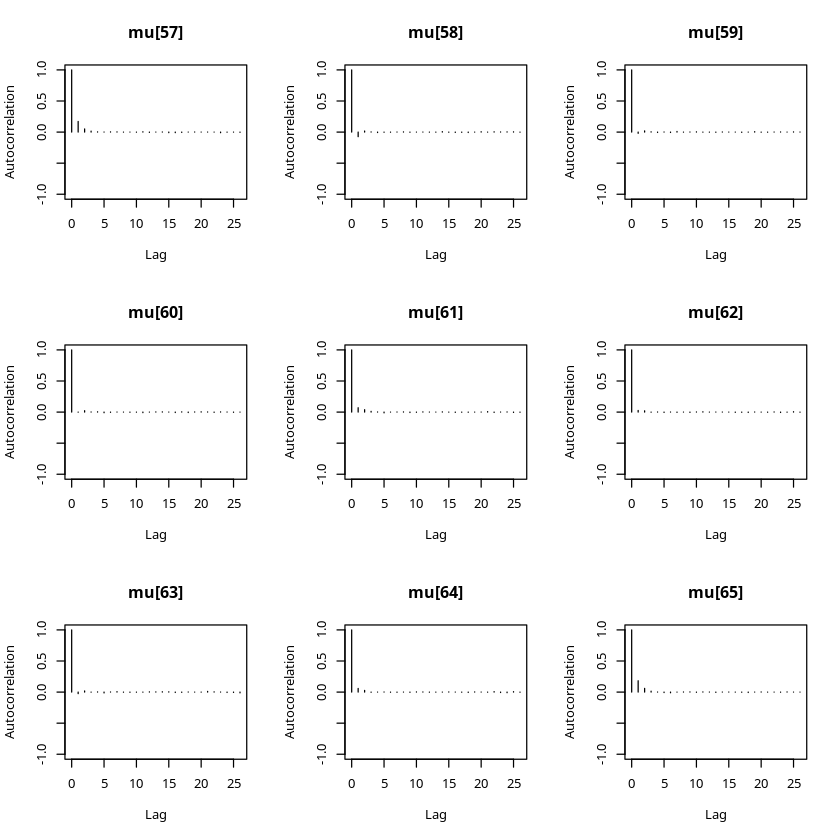

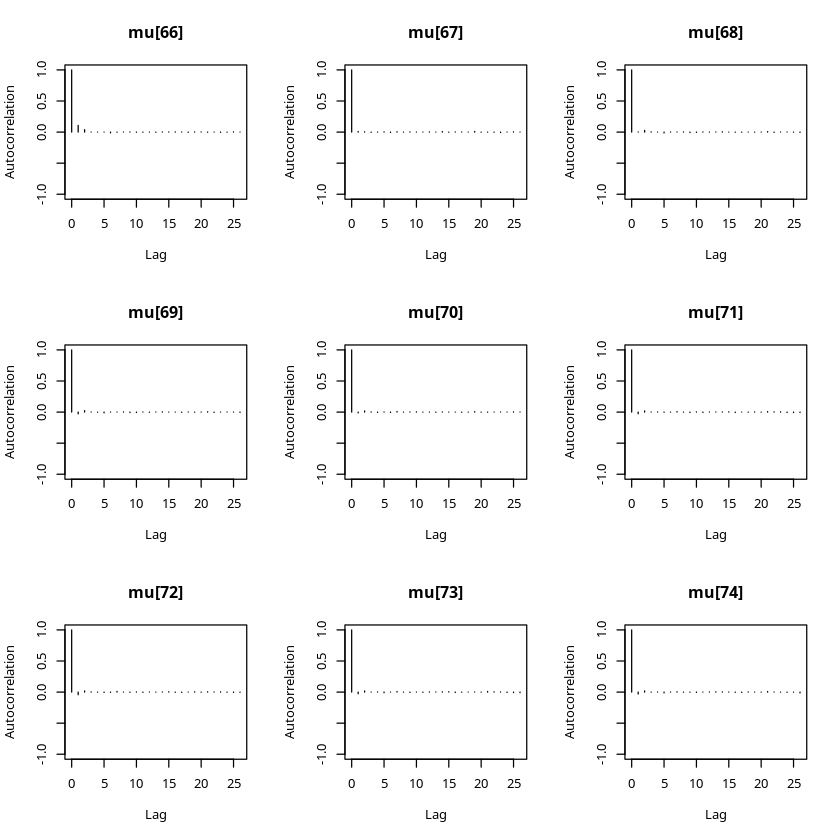

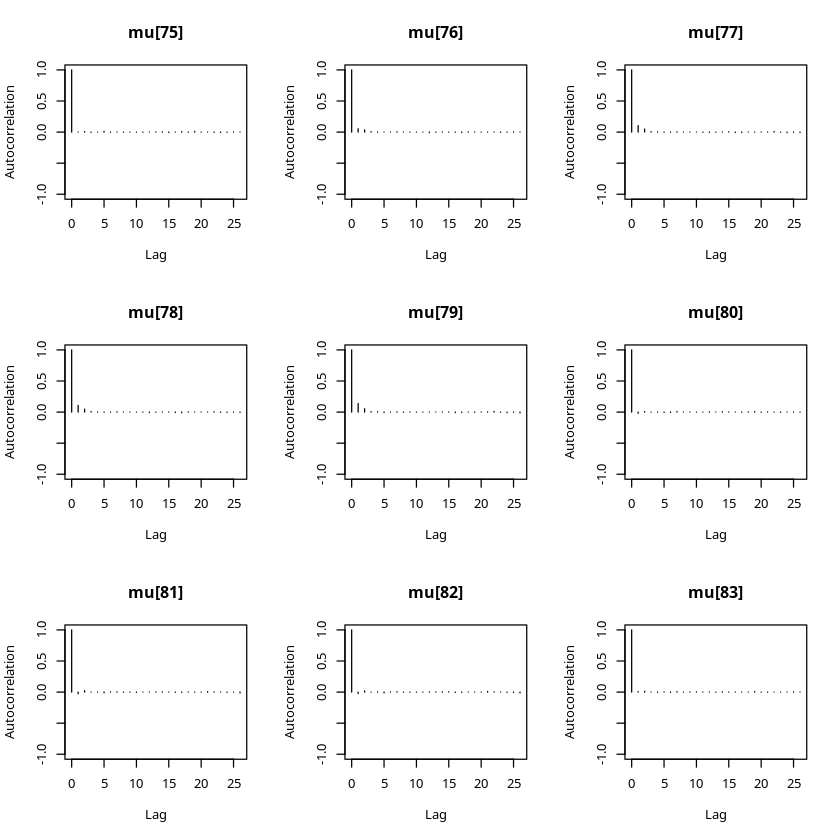

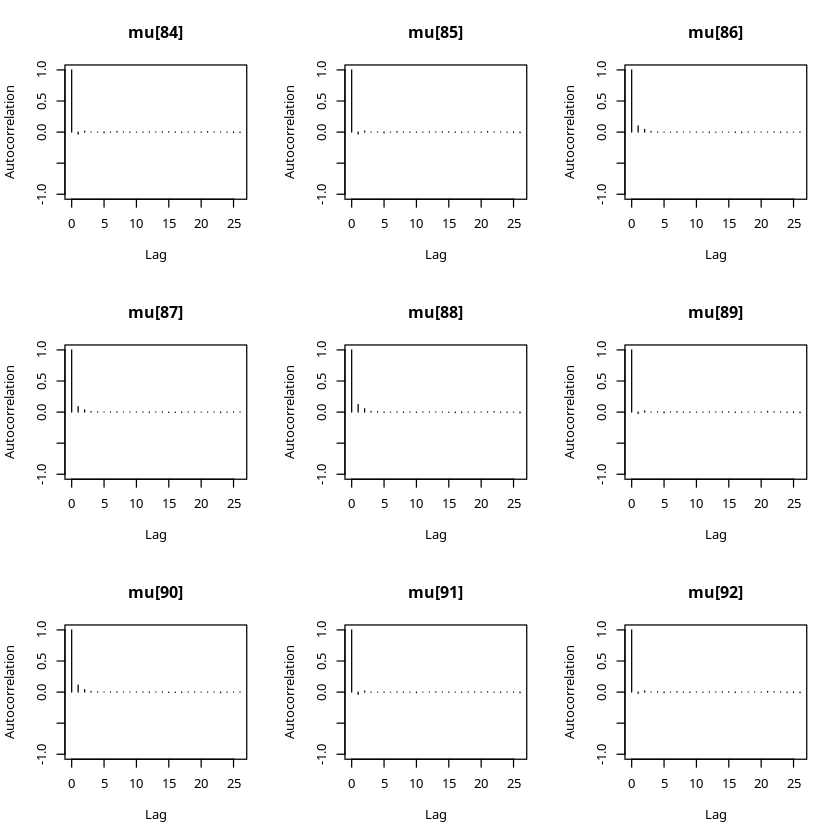

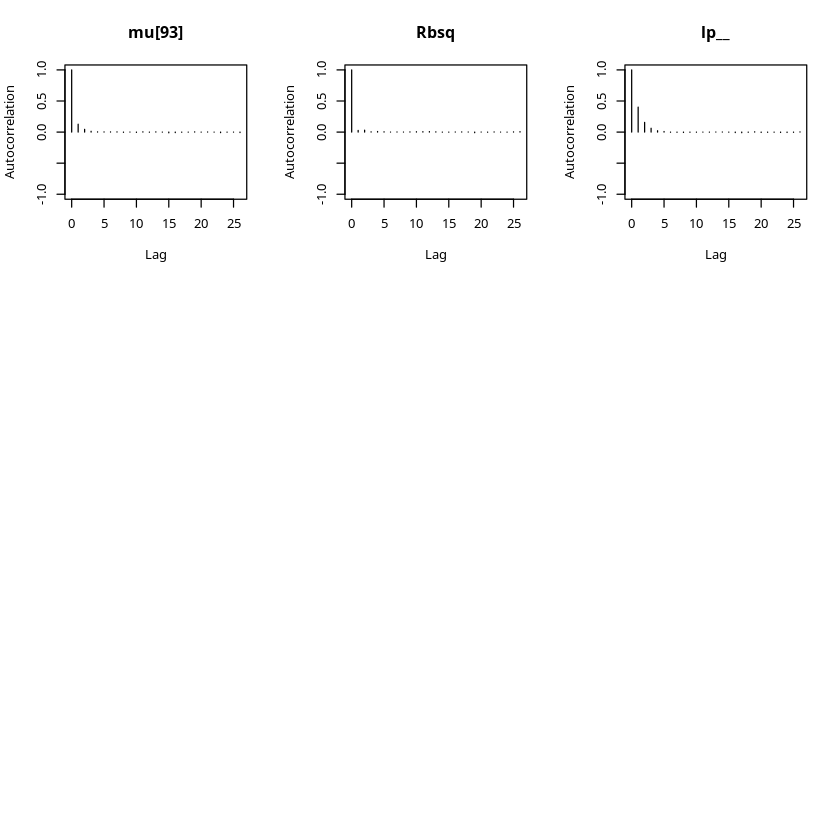

In [41]:
autocorr.plot(stan2coda3(fit3))

## Model Comparison:

### Rbsq Densities:

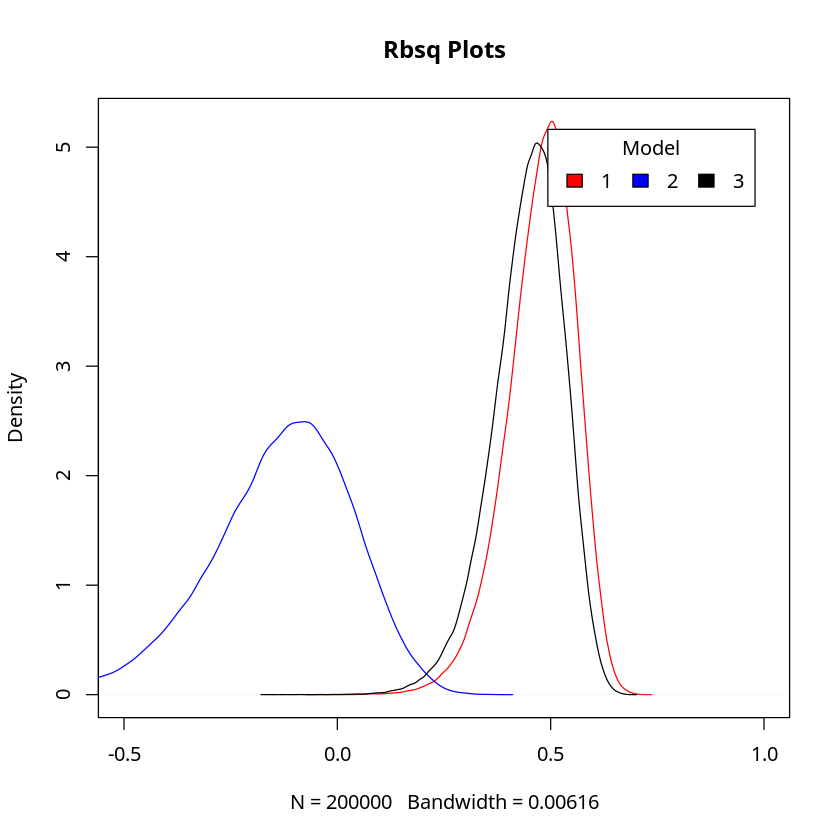

In [47]:
listofdraws1 = extract(fit1)
listofdraws2 = extract(fit2)
listofdraws3 = extract(fit3)


plot(density(listofdraws1$Rbsq),main="Rbsq Plots",col="red",xlim = c(-.5,1))
lines(density(listofdraws2$Rbsq),col="blue")
lines(density(listofdraws3$Rbsq),col="black")
legend("topright", inset=.05, title="Model",
  	c("1","2","3"), fill=c("red","blue","black"), horiz=TRUE)

In [43]:
library(xtable)

In [44]:
print(xtable(cbind(summary(fit1)$summary[1:7,c("mean","50%","2.5%","97.5%")],
                   summary(fit2)$summary[1:7,c("mean","50%","2.5%","97.5%")],
                   summary(fit2)$summary[1:7,c("mean","50%","2.5%","97.5%")])))

% latex table generated in R 3.3.2 by xtable 1.8-2 package
% Thu Apr  6 10:49:16 2017
\begin{table}[ht]
\centering
\begin{tabular}{rrrrrrrrrrrrr}
  \hline
 & mean & 50\% & 2.5\% & 97.5\% & mean & 50\% & 2.5\% & 97.5\% & mean & 50\% & 2.5\% & 97.5\% \\ 
  \hline
prec & 3.88 & 3.85 & 2.83 & 5.10 & 1.79 & 1.78 & 1.31 & 2.34 & 1.79 & 1.78 & 1.31 & 2.34 \\ 
  beta0 & 3.53 & 3.53 & 2.87 & 4.18 & 3.49 & 3.49 & 2.54 & 4.44 & 3.49 & 3.49 & 2.54 & 4.44 \\ 
  beta1 & 0.72 & 0.72 & 0.49 & 0.96 & 0.72 & 0.72 & 0.37 & 1.06 & 0.72 & 0.72 & 0.37 & 1.06 \\ 
  beta2 & 0.09 & 0.09 & 0.04 & 0.14 & 0.09 & 0.09 & 0.02 & 0.16 & 0.09 & 0.09 & 0.02 & 0.16 \\ 
  beta3 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & -0.00 & 0.00 & 0.00 & 0.00 & -0.00 & 0.00 \\ 
  beta4 & 0.02 & 0.02 & 0.01 & 0.03 & 0.02 & 0.02 & 0.01 & 0.04 & 0.02 & 0.02 & 0.01 & 0.04 \\ 
  sigma & 0.51 & 0.51 & 0.44 & 0.59 & 0.57 & 0.56 & 0.43 & 0.76 & 0.57 & 0.56 & 0.43 & 0.76 \\ 
   \hline
\end{tabular}
\end{table}
